# Discretization Classification 2.0(Template) - KFold
## Author: Ming

In [1]:
#Import Package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.calibration import CalibratedClassifierCV

#Discretization
from mdlp.discretization import MDLP
from caimcaim import CAIMD
from scorecardbundle.feature_discretization import ChiMerge as cm
from reportgen import preprocessing #Chimerge


from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, confusion_matrix

from threading import Thread, Lock
lock = Lock()

import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()

#Import Our Class
%run "TEJ Classification Package.ipynb"

## Import Data

In [2]:
# Load Data
data_name = "Bankruptcy"
#Fast: Japanese_Credit Australian_Original Germany_Original Japanese_Bankrupt 
#Slow: USA_Bankrupt

#Discretize Good: Kaggle Tsai Bankruptcy Australia JPNCredit
#
if data_name == "Tsai_Original":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Tsai_BankruptcyData()
elif  data_name == "Germany_Original":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_German_Numeric_CreditData()
elif  data_name == "Germany_700-300(Random)":
    germanData_data_sample, discretize_coloumn = ClassificationDataset().load_German_Numeric_CreditData_Dataframe()
elif  data_name == "Australian_Original":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Australian_CreditData()
elif  data_name == "Australian_Normalize(Old)":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Australian_CreditData_Normalize()
elif  data_name == "Australian_(Dis5Column)Without12":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Australian_CreditData_Different_Continuous_Column()
elif  data_name == "GiveMeSomeCredit":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_GiveMeSomeCredit_CreditData() 
elif  data_name == "Japanese_Credit":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Japanese_CreditData() 
elif  data_name == "Japanese_Bankrupt":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Japanese_BankruptData() 
elif  data_name == "USA_Bankrupt":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_USA_BankruptData()
elif  data_name == "Bankruptcy":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Bankruptcy_Data() 
elif  data_name == "TEJCN":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_TEJCN_Data() 
elif  data_name == "PAKDD":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_PAKDD_Data() 
    
# # Select Data
# data_list = tsaiData_data
# target_list = tsaiData_target
# discretize_coloumn = continuous_coloumn

# Sampling
# large = germanData_data_sample.loc[germanData_data_sample['default'] == 1]
# small = germanData_data_sample.loc[germanData_data_sample['default'] == 2]
# large = large.sample(n=300)
# germanData_data = pd.concat([large, small])
# germanData_data = germanData_data.sample(frac=1).reset_index(drop=True)
# data_list = germanData_data[[i for i in germanData_data.columns if i != 'default']].values
# target_list = germanData_data[[i for i in germanData_data.columns if i == 'default']].values


# Declare Result List (Alogorithm, fold, ACC, AUC)
evaluation_result_list = []

In [3]:
print ("資料筆數 ::", data_list.shape[0])
print ("特徵數量(不含Target) ::", data_list.shape[1])

資料筆數 :: 1321
特徵數量(不含Target) :: 16


大類:1 小類2

In [4]:
unique, counts = np.unique(target_list, return_counts=True)
dict(zip(unique, counts))

{1: 697, 2: 624}

a = pd.DataFrame(data_list)

for idx,classifi in enumerate(a):
    if a[idx].nunique()>10:
        print(str(idx)+"_"+str(a[idx].nunique()))
        #print(str(idx))

## Select Specific Features to Discretization + Discretization Method (MDLP、CAIM、ChiMerge)

In [5]:
class Discretization:
    def __init__(self, training_data, training_target, discretize_coloumn):
        self.training_data = training_data
        self.training_target = training_target
        self.discretize_coloumn = discretize_coloumn
        self.transformer_MDLP = MDLP()
        self.transformer_CAIMD = CAIMD()
        self.transformer_ChiMerge_SC = cm.ChiMerge(output_dataframe=True)
        self.transformer_ChiMerge_RG = preprocessing.Discretization(method='chimerge')

    def SelectFeatures(self): ##Split Specific to Discretize
        idx_IN_columns = self.discretize_coloumn
        idx_OUT_columns = [i for i in range(np.shape(self.training_data)[1]) if i not in idx_IN_columns]
        selectData_list = self.training_data[:,idx_IN_columns]
        disSelectData_list = self.training_data[:,idx_OUT_columns]
        return selectData_list , disSelectData_list
        
    def MDLP(self,selectData_list): 
        selectDataDiscretiz_list = self.transformer_MDLP.fit_transform(selectData_list, self.training_target)
        return selectDataDiscretiz_list
    
    def MDLP_transform(self,selectData_test_list): 
        selectDataDiscretiz_list = self.transformer_MDLP.transform(selectData_test_list)
        return selectDataDiscretiz_list

    def CAIMD(self,selectData_list):  #CAIMD
        selectDataDiscretiz_list = self.transformer_CAIMD.fit_transform(selectData_list, self.training_target)
        return selectDataDiscretiz_list
    
    def CAIMD_transform(self,selectData_test_list):  #CAIMD
        selectDataDiscretiz_list = self.transformer_CAIMD.transform(selectData_test_list)
        return selectDataDiscretiz_list
    
    def ChiMerge_SC(self,selectData_list):  #Chimerge
        selectDataDiscretiz_list = self.transformer_ChiMerge_SC.fit_transform(selectData_list, self.training_target.squeeze())
        return self.Box_Transform(selectDataDiscretiz_list)
    
    def ChiMerge_SC_transform(self,selectData_test_list):  #Chimerge
        selectDataDiscretiz_list = self.transformer_ChiMerge_SC.transform(selectData_test_list)
        return self.Box_Transform(selectDataDiscretiz_list)
    
    def ChiMerge_RG(self,selectData_list):  #Chimerge
        selectDataDiscretiz_list = self.transformer_ChiMerge_RG.fit_transform(selectData_list, self.training_target.squeeze())
        return self.Box_Transform(selectDataDiscretiz_list)
    
    def ChiMerge_RG_transform(self,selectData_test_list):  #Chimerge
        selectDataDiscretiz_list = self.transformer_ChiMerge_RG.transform(selectData_test_list)
        return self.Box_Transform(selectDataDiscretiz_list)
    
    def Box_Transform(self,discretize_list):
        for i in discretize_list.columns:
            replace_coloumn = discretize_list[i].unique()
            replace_coloumn.sort()
            lst = list(replace_coloumn)
            ip_dict = dict(zip(lst, range(len(lst))))
            discretize_list[i] = discretize_list[i].replace(ip_dict)
        return discretize_list
    
    def MergeFeatures(self,selectDataDiscretiz_list,disSelectData_list):  ## Merge Discretized Data with Original Data
        self.dataDiscretize_list = np.concatenate([selectDataDiscretiz_list,disSelectData_list],axis = 1)
        return self.dataDiscretize_list

## rpy2 Discretization

In [6]:
class Discretization_rpy2:
    def __init__(self, training_data, training_target, discretize_coloumn):
        self.training_data = training_data
        self.training_target = training_target
        self.discretize_coloumn = discretize_coloumn
        self.transformer_MDLP = MDLP()
        self.transformer_CAIMD = CAIMD()
        self.transformer_ChiMerge_SC = cm.ChiMerge(output_dataframe=True)
        self.transformer_ChiMerge_RG = preprocessing.Discretization(method='chimerge')

    def SelectFeatures(self): ##Split Specific to Discretize
        idx_IN_columns = self.discretize_coloumn
        idx_OUT_columns = [i for i in range(np.shape(self.training_data)[1]) if i not in idx_IN_columns]
        selectData_list = self.training_data[:,idx_IN_columns]
        disSelectData_list = self.training_data[:,idx_OUT_columns]
        return selectData_list , disSelectData_list
    
     

## KFoldFuntion

In [7]:
class KFoldFuntion:
    # linear_svc,'linear_svc','baseline', data_list, target_list, fold
    def __init__(self, classifier, classifier_name, method, data_list, target_list, fold, discretize_coloumn):
        self.X = data_list
        self.y = target_list
        self.fold = fold
        self.outcomes_acc = []
        self.outcomes_auc = []
        self.outcomes_typeII = []
        self.outcomes_typeI = []
        self.fold_result_list = []
        self.outcomes_minority = []
        self.outcomes_majority = []
        self.method = method  # (Baseline, MDLP, CAIM)
        self.classifier = classifier
        self.classifier_name = classifier_name
        self.discretize_coloumn = discretize_coloumn
    
    def Classify(self):
        kf = KFold(n_splits=self.fold,random_state=np.random, shuffle=True)
        #kf = StratifiedKFold(n_splits=self.fold)
        #for train_index, test_index in kf.split(self.X,self.y):
        for train_index, test_index in kf.split(self.X):
            X_train, X_test = self.X[train_index], self.X[test_index] #X_train: training data X_test: testing data
            y_train, y_test = self.y[train_index], self.y[test_index] #y_train: training data answer y_test: testing data answer
            
            if self.method == 'Baseline':
                
                # Convert to Dataframe
                X_train_dataframe = pd.DataFrame(X_train)
                X_test_dataframe  = pd.DataFrame(X_test)
                y_train_dataframe = pd.DataFrame(y_train)
                y_test_dataframe  = pd.DataFrame(y_test)
                predictions,proba = self.Classification(X_train_dataframe,y_train_dataframe,X_test_dataframe,y_test_dataframe)
                self.StoreFoldResult(y_test_dataframe,predictions,proba)
            else:

                # -------------------------------------Discretize Training Data--------------------------------------
                # Declare Training Data Discretizer_rpy2  ------OK
                discretize_train = Discretization_rpy2(X_train,y_train,self.discretize_coloumn)

                # Select Continuous Feature (Training Data Continuous Feature)   ------OK
                ## Return: List of data
                X_train_continuousData_list, X_train_catrgorialData_list  = discretize_train.SelectFeatures() #Devide Discretize Coloumns

                
                # Convert data to Dataframe for R Package "Discretization"
                ## R require Select Continuous Data(X_Train_SelectData) and Target(y_Train) in the last column
                X_train_continuousData_dataframe = pd.DataFrame(X_train_continuousData_list)
                y_train_dataframe = pd.DataFrame(y_train)
    
                # Combine Select Continuous with Target
                X_y_train_continuousData_dataframe = pd.concat([X_train_continuousData_dataframe, y_train_dataframe],axis=1)
                X_y_train_continuousData_dataframe.columns = range(X_y_train_continuousData_dataframe.shape[1])
                print("[X_y_train_continuousData_dataframe]")
                #print(X_y_train_continuousData_dataframe.head(5))
                
                
                # Import R Package
                discretization = importr("discretization")
                disc_Topdown = robjects.r("disc.Topdown")
                
                print("-------------------------------"+self.method+" -----------------------------")
                # Discretize (R Package)
                ## Input: pandas.DataFrame  Output: rpy2.DataFrame
                if self.method == 'MDLP_R':
                    X_y_train_disData_rpy2dataframe = discretization.mdlp(X_y_train_continuousData_dataframe)
                elif self.method == 'CAIM_R':
                    X_y_train_disData_rpy2dataframe = discretization.disc_Topdown(X_y_train_continuousData_dataframe, method=1)
                elif self.method == 'ChiMerge_R':
                    X_y_train_disData_rpy2dataframe = discretization.chiM(X_y_train_continuousData_dataframe, alpha = 0.05)
                elif self.method == 'CACC_R':
                    X_y_train_disData_rpy2dataframe = discretization.disc_Topdown(X_y_train_continuousData_dataframe, method=2)
                elif self.method == 'Chi2_R':
                    X_y_train_disData_rpy2dataframe = discretization.chi2(X_y_train_continuousData_dataframe,0.5,0.05)
                    
                # Transfer rpy2.DataFrame to pandas.DataFrame
                X_y_train_disData_dataframe = pandas2ri.ri2py(X_y_train_disData_rpy2dataframe[1])
                
                
                print("[X_y_train_disData_dataframe]")
                #print(X_y_train_disData_dataframe.head(5))
                
                # Select the data(without target) in Combine_X_y_train_dis_dataframe 
                X_train_disData_dataframe = X_y_train_disData_dataframe.iloc[:,:-1]
                print("[X_train_disData_dataframe]")
                #print(X_train_disData_dataframe.head(5))
                
                
                # Merge dis_feature & categeorial_feature
                X_train_categorialData_dataframe = pd.DataFrame(X_train_catrgorialData_list)
                print("[X_train_categorialData_dataframe]")
                #print(X_train_categorialData_dataframe.head(5))
                
                Discretize_X_train_dataframe = pd.concat([X_train_disData_dataframe, X_train_categorialData_dataframe],axis = 1)
                Discretize_X_train_dataframe.columns = range(Discretize_X_train_dataframe.shape[1])
                print("[Discretize_X_train_dataframe]")
                #print(Discretize_X_train_dataframe.head(5))
                
                
                # --------------------------------------Discretize Testing Data----------------------------------------------------
                
                # Enable Cutpoint for X_test (No Target)
                
                ## Declare Training Data Discretizer_rpy2  ------OK
                discretize_test = Discretization_rpy2(X_test,y_test,discretize_coloumn)
                
                ## Select Continuous Feature (Testing Data Continuous Feature)   ------OK
                ## Return: List of data
                X_test_continuousData_list, X_test_catrgorialData_list  = discretize_test.SelectFeatures() #Devide Discretize Coloumns
                
                
                ## Prepare X_test to enable cutpoint
                X_test_continuousData_dataframe  = pd.DataFrame(X_test_continuousData_list)
                print("X_test_continuousData_dataframe")
                #print(X_test_continuousData_dataframe.head(5))
                
                ## Get Cutpoint (Transfer to numpy array)
                cutpoint_bins = X_y_train_disData_rpy2dataframe[0]
                #cutpoint_bins = np.array(cutpoint)
                #print("Original Cutbins")
                #print(cutpoint_bins)
                
                
                ## Declare dataframe for store data after discretize
                X_test_disData_dataframe = pd.DataFrame()

                
                for idx, val in enumerate(X_test_continuousData_dataframe):
                    if cutpoint_bins[idx][0] == "All":
                        print(str(idx)+"_ALL")
                        X_test_disData_dataframe[idx] = pd.cut(X_test_continuousData_dataframe.iloc[:,idx], bins =1 , labels = [1],include_lowest=True )    
                    else:        
                        print(str(idx)+"_NOTALL")
                        cutpoint_bins[idx] = np.sort(cutpoint_bins[idx])
                        #print(type(cutpoint_bins[idx]))
                        cutpoint_with_infiniti = np.insert (np.insert(cutpoint_bins[idx],0, (-np.inf),0),len(cutpoint_bins[idx])+1,(np.inf))
                        cutpoint_labels = list(range(1, len(cutpoint_with_infiniti)))
                        #print(cutpoint_labels)
                        
                        X_test_disData_dataframe[idx] = pd.cut(X_test_continuousData_dataframe.iloc[:,idx], bins = cutpoint_with_infiniti,labels=cutpoint_labels,include_lowest=True)
                print("X_test_disData_dataframe")
                #print(X_test_disData_dataframe.head(5))    
                    
                    
                # Merge dis_feature & categeorial_feature
                X_test_categorialData_dataframe = pd.DataFrame(X_test_catrgorialData_list)
                print("X_test_categorialData_dataframe")
                #print(X_test_categorialData_dataframe.head(5))
                
                Discretize_X_test_dataframe = pd.concat([X_test_disData_dataframe, X_test_categorialData_dataframe],axis=1)
                Discretize_X_test_dataframe.columns = range(Discretize_X_test_dataframe.shape[1])
                
                print("Discretize_X_test_dataframe")
                #print(Discretize_X_test_dataframe.head(5))
                
        
                # Convert Target to Dataframe
                y_train_dataframe = pd.DataFrame(y_train)
                y_test_dataframe = pd.DataFrame(y_test)
                

                # Prediction (Discretize_X_train_dataframe, y_train_dataframe, Discretize_X_test_dataframe, y_test_dataframe)
                predictions,proba = self.Classification(Discretize_X_train_dataframe,y_train_dataframe,
                                                        Discretize_X_test_dataframe,y_test_dataframe)
                self.StoreFoldResult(y_test_dataframe,predictions,proba)
                
                print("-------------------------------NEXT ROUND-----------------------------")
        return self.PrintTotalResult()   
                      
    def Classification(self,X_train_dataframe,y_train_dataframe,X_test_dataframe,y_test_dataframe):
        
         # Convert Dataframe column from int to str (for xgboost)
        X_train_dataframe.columns = X_train_dataframe.columns.astype(str)
        y_train_dataframe.columns = y_train_dataframe.columns.astype(str)
        X_test_dataframe.columns = X_test_dataframe.columns.astype(str)
        y_test_dataframe.columns = y_test_dataframe.columns.astype(str)
        
        X_train_dataframe = X_train_dataframe.astype('float')
        y_train_dataframe = y_train_dataframe.astype('float')
        X_test_dataframe = X_test_dataframe.astype('float')
        y_test_dataframe = y_test_dataframe.astype('float')
        
        
        clf = self.classifier
        clf.fit(X_train_dataframe, y_train_dataframe["0"].ravel())
        predictions = clf.predict(X_test_dataframe)
        proba = clf.predict_proba(X_test_dataframe)[:, 1]
        return predictions,proba

    
    def StoreFoldResult(self,y_test_dataframe,predictions,proba):
        
        #Accuracy Score
        accuracy = accuracy_score(y_test_dataframe, predictions)
        self.outcomes_acc.append(accuracy)
        
        #AUC Score
        auc = roc_auc_score(y_test_dataframe, proba)
        self.outcomes_auc.append(auc)
        
        #Type II Error
        TN, FP, FN, TP = confusion_matrix(y_test_dataframe, predictions).ravel()
        typeII = FN/(TP+FN)
        typeI = FP/(FP+TN)
        self.outcomes_typeII.append(typeII)
        self.outcomes_typeI.append(typeI)
        
        #Majority, Minority (Count)
        unique, counts = np.unique(y_test_dataframe, return_counts=True)
        dict(zip(unique, counts))
        
        proportion = np.unique(y_test_dataframe, return_counts=True)
        majority_proportion = proportion[1][0]/(self.X.shape[0]/self.fold)
        minority_proportion = proportion[1][1]/(self.X.shape[0]/self.fold)
        self.outcomes_majority.append(proportion[1][0])
        self.outcomes_minority.append(proportion[1][1])

        
        # Plot fold_result_list 
        each_fold_result_list = [accuracy,auc,typeI,typeII,majority_proportion,minority_proportion]
        self.fold_result_list.append(each_fold_result_list)
    
    def PrintTotalResult(self):
        
        mean_outcome_acc = np.mean(self.outcomes_acc)
        print("Mean Accuracy: {0}".format(mean_outcome_acc))
        print("Mean Accuracy"+ str(self.outcomes_acc))
        
        mean_outcome_auc = np.mean(self.outcomes_auc)
        print("Mean Auc: {0}".format(mean_outcome_auc))
        print("Mean Auc"+ str(self.outcomes_auc))
        
        mean_outcomes_typeII = np.mean(self.outcomes_typeII)
        print("Mean TypeII: {0}".format(mean_outcomes_typeII))
        print("Mean TypeII"+ str(self.outcomes_typeII))
        
        mean_outcomes_typeI = np.mean(self.outcomes_typeI)
        print("Mean TypeI: {0}".format(mean_outcomes_typeI))
        print("Mean TypeI"+ str(self.outcomes_typeI))
        
        lock.acquire()
        
        # Print Each Fold Plot
        self.PrintPlotEachFold(self.fold_result_list,"Result")
        
        lock.release()
        
        return mean_outcome_acc, mean_outcome_auc, mean_outcomes_typeI, mean_outcomes_typeII
    
    def PrintPlotEachFold(self,plot_data,metrics_name):
        
        #Trasnfer Type 
        plot_data = np.array(plot_data)
        
        #Set Each Line Data
        plt.plot(plot_data[:,0],label='acc')
        plt.plot(plot_data[:,1],label='auc')
        plt.plot(plot_data[:,2],label='type I')
        plt.plot(plot_data[:,3],label='type II')
        plt.plot(plot_data[:,4],label='maj', marker='o')
        plt.plot(plot_data[:,5],label='min', marker='o')
        
        #Set Graph Information
        title = '{metrics_name} with {fold} folds-{method}-{classifier_name}'.format(
            metrics_name=metrics_name, fold=self.fold,method=self.method,classifier_name=self.classifier_name )
        plt.title(title)
        plt.xlabel('Folds')
        plt.ylabel('percertange')
        plt.legend(loc='upper right')
        plt.show()
    

## Graph

In [8]:
def CompareMethodMeanResult(data_name, clf_name, rounds,result_10times_baseline,result_10times_MDLP,result_10times_CAIM,result_10times_ChiMerge_SC,result_10times_CACC,result_10times_Chi2):
    #Labels
    labels = ['ACC', 'AUC', 'TYPEI', 'TYPEII']
    x = np.arange(len(labels))  # the label locations
    width = 0.15  # the width of the bars

    result_10times_baseline_mean = np.around( np.mean(result_10times_baseline, axis=0), decimals=3)
    result_10times_MDLP_mean =  np.around( np.mean(result_10times_MDLP, axis=0), decimals=3)
    result_10times_CAIM_mean =  np.around( np.mean(result_10times_CAIM, axis=0), decimals=3)
    result_10times_ChiMerge_SC_mean =  np.around( np.mean(result_10times_ChiMerge_SC, axis=0), decimals=3)
    result_10times_CACC_mean =  np.around( np.mean(result_10times_CACC, axis=0), decimals=3)
    result_10times_Chi2_mean =  np.around( np.mean(result_10times_Chi2, axis=0), decimals=3)
    #result_10times_ChiMerge_RG_mean =  np.around( np.mean(result_10times_ChiMerge_RG, axis=0), decimals=3)

    fig, ax = plt.subplots(figsize=(15, 10))
    rects1 = ax.bar(x , result_10times_baseline_mean, width, label='Baseline')
    rects2 = ax.bar(x +width, result_10times_MDLP_mean, width, label='MDLP_R')
    rects3 = ax.bar(x +width*2, result_10times_CAIM_mean, width, label='CAIM_R')
    rects4 = ax.bar(x +width*3, result_10times_ChiMerge_SC_mean, width, label='ChiMerge_R')
    rects5 = ax.bar(x +width*4, result_10times_CACC_mean, width, label='CACC_R')
    rects6 = ax.bar(x +width*5, result_10times_Chi2_mean, width, label='Chi2_R')
    #rects5 = ax.bar(x +width*4, result_10times_ChiMerge_RG_mean, width, label='ChiMerge_RG')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Percentage')
    data_name, clf_name, rounds
    title = 'Compare Result-{data_name}-{classifier_name}'.format(data_name=data_name,classifier_name=clf_name)
    ax.set_title(title)
    ax.set_xticks(x+width*2)
    ax.set_xticklabels(labels)
    ax.legend(bbox_to_anchor=(1, 0.5))

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 5),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', size = 12)
    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    autolabel(rects4)
    autolabel(rects5)
    autolabel(rects6)
    
    fig.tight_layout()
    file_time = time.strftime("%Y-%m-%d-%H%M%S", time.localtime()) 
    file_name = "results/{title}_{file_timeA}.png".format(file_timeA = file_time, title= title)
    print(title)
    fig.savefig(file_name)
    plt.show()

In [9]:
def ResultEachMethodLineChart(result, method_name,data_name, classifier_name):
    result = np.array(result)
    
    plt.plot(result[:,0], label='Acc', marker='o')
    plt.plot(result[:,1], label='Auc', marker='o')
    plt.plot(result[:,2], label='TypeI', marker='o')
    plt.plot(result[:,3], label='TypeII', marker='o')
    plt.legend(bbox_to_anchor=(1, 0.5))
    plt.ylabel('Percertange')
    plt.xlabel('Rounds')
    title = 'Each Rounds-{data_name}-{method_name}-{classifier_name}'.format(data_name=data_name,method_name=method_name,classifier_name=classifier_name)
    plt.title(title)
    
    
    file_time = time.strftime("%Y-%m-%d-%H%M%S", time.localtime()) 
    #plt.savefig('results/{title}_{file_timeA}.png'.format(file_timeA = file_time, title= title, method_name=method_name, classifier_name=classifier_name), bbox_inches='tight')
    plt.show()
    
    plt.close

## Import Classification Package

In [10]:
from sklearn.svm import SVC, LinearSVC , libsvm
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from logitboost import LogitBoost
from sklearn.ensemble import AdaBoostClassifier

## Start Classify

## Run 10 Times


程式開始


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarn

Mean Accuracy: 0.6548084619782732
Mean Accuracy[0.6528301886792452, 0.6856060606060606, 0.625, 0.6704545454545454, 0.6401515151515151]
Mean Auc: 0.7067295703408651
Mean Auc[0.6989173789173789, 0.7110218140068887, 0.7201169590643275, 0.734025234025234, 0.6695664656904967]
Mean TypeII: 0.02575568630812607
Mean TypeII[0.015384615384615385, 0.014925373134328358, 0.02631578947368421, 0.02564102564102564, 0.046511627906976744]
Mean TypeI: 0.6320862840862841
Mean TypeI[0.6666666666666666, 0.6230769230769231, 0.64, 0.5714285714285714, 0.6592592592592592]
Mean Accuracy: 0.8849685534591195
Mean Accuracy[0.8415094339622642, 0.9128787878787878, 0.8939393939393939, 0.8939393939393939, 0.8825757575757576]
Mean Auc: 0.8828342271242583
Mean Auc[0.8423962608299134, 0.9128013777267509, 0.8862391803568274, 0.8941628881363713, 0.8785714285714286]
Mean TypeII: 0.1432442152616821
Mean TypeII[0.19117647058823528, 0.08208955223880597, 0.16216216216216217, 0.13533834586466165, 0.14545454545454545]
Mean TypeI: 

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fall

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Fallin

Mean Accuracy: 0.8963007432818753
Mean Accuracy[0.8830188679245283, 0.8712121212121212, 0.9166666666666666, 0.9015151515151515, 0.9090909090909091]
Mean Auc: 0.9525252109702714
Mean Auc[0.9448870801329818, 0.9315689217270838, 0.9712339789643083, 0.957406230133503, 0.9575298438934803]
Mean TypeII: 0.09167665009222445
Mean TypeII[0.06557377049180328, 0.13934426229508196, 0.05511811023622047, 0.10743801652892562, 0.09090909090909091]
Mean TypeI: 0.11437294072227763
Mean TypeI[0.16083916083916083, 0.11971830985915492, 0.10948905109489052, 0.09090909090909091, 0.09090909090909091]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\User

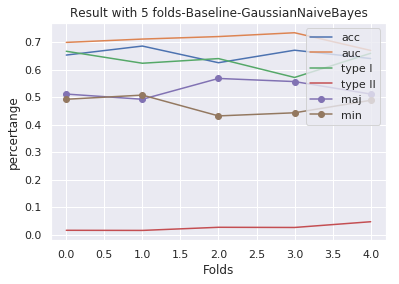

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Mean : [0.65480846 0.70672957 0.63208628 0.02575569]
[X_y_train_continuousData_dataframe]
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packa

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_ALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_ALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning: invalid value encount

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------MDLP_R -----------------------------
Mean Accuracy: 0.6918753573470555
Mean Accuracy[0.7245283018867924, 0.6287878787878788, 0.7007575757575758, 0.7083333333333334, 0.696969696969697]
Mean Auc: 0.8388647516087528
Mean Auc[0.8441491788321168, 0.8102210737869652, 0.853029951242164, 0.8618371486525646, 0.8250864055299539]
Mean TypeII: 0.6219055397278892[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]

X_test_continuousData_dataframe
0_ALLMean TypeII[0.5546875, 0.7185185185185186, 0.6271186440677966, 0.5882352941176471, 0.6209677419354839]
Mean TypeI: 0.025260297394096843
Mean TypeI[0.014598540145985401, 0.007751937984496124, 0.03424657534246575, 0.04827586206896552, 0.02142857142857143]

1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
1

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------MDLP_R -----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packa

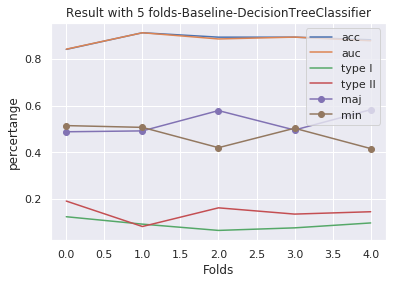

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


X_test_continuousData_dataframe
0_ALL
1_NOTALL
2_NOTALL
Mean : [0.88496855 0.88283423 0.09108733 0.14324422]
3_NOTALL
[X_y_train_continuousData_dataframe]
-------------------------------MDLP_R -----------------------------
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_ALL
1_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

9_NOTALL
10_NOTALL
11_NOTALL2_NOTALL

12_NOTALL
3_NOTALL
13_NOTALL
4_NOTALL14_NOTALL

5_NOTALL
6_NOTALL15_NOTALL

7_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
8_NOTALL
Discretize_X_test_dataframe
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans


-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------MDLP_R -----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_ALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
-------------------------------NEXT ROUND-----------------------------
5_NOTALL
6_NOTALL
[X_y_train_continuousData_dataframe]7_NOTALL

-------------------------------MDLP_R -----------------------------8_NOTALL

9_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

[X_y_train_disData_dataframe]10_NOTALL

11_NOTALL
[X_train_disData_dataframe]12_NOTALL

13_ALL
[X_train_categorialData_dataframe]14_NOTALL
15_NOTALL
[Discretize_X_train_dataframe]
X_test_disData_dataframe

X_test_continuousData_dataframeX_test_categorialData_dataframe
0_ALL
1_NOTALL

2_NOTALL
Discretize_X_test_dataframe
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_ALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_ALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
-------------------------------NEXT ROUND-----------------------------
5_NOTALL[X_y_train_continuousData_dataframe]
-------------------------------MDLP_R -----------------------------

6_NOTALL
7_NOTALL
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_ALL
1_NOTALL
8_NOTALL
2_NOTALL
Mean Accuracy: 0.9091538021726701
Mean Accuracy[0.9169811320754717, 0.9166666666666666, 0.8863636363636364, 0.8977272727272727, 0.928030303030303]
Mean Auc: 0.9694398294050848
Mean Auc[0.9734809177908452, 0.9693466758684149, 0.9635188178249826, 0.9626355966251506, 0.9782171389160298]
Mean TypeII: 0.07651207760406413
Mean TypeII[0.059322033898305086, 0.07936507936507936, 0.07377049180327869, 0.09923664122137

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

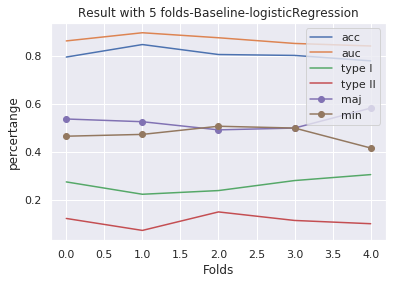

13_ALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Mean : [0.80697256 0.86675815 0.26432577 0.11136826]
Discretize_X_test_dataframe
[X_y_train_continuousData_dataframe]
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
C:\Users\La

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_ALL
1_NOTALL
2_NOTALL
3_NOTALL
-------------------------------NEXT ROUND-----------------------------4_NOTALL

Mean Accuracy: 0.8539136649514008
Mean Accuracy[0.8339622641509434, 0.8181818181818182, 0.8636363636363636, 0.8825757575757576, 0.8712121212121212]
Mean Auc: 0.8983841730339519
Mean Auc[0.8861159420289855, 0.8713416401043176, 0.9120967741935484, 0.9051541066406474, 0.9172124022022602]
Mean TypeII: 0.16214496286400387
Mean TypeII[0.25217391304347825, 0.17647058823529413, 0.10714285714285714, 0.10687022900763359, 0.16806722689075632]
Mean TypeI: 0.1359866016543026
Mean TypeI[0.1, 0.18620689655172415, 0.1693548387096774, 0.12781954887218044, 0.09655172413793103]
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
-------------------------------NEXT ROUND-----------------------------
12_NOTALL
13_ALL
14_NOTALL
15

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin


-------------------------------MDLP_R -----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_ALL
1_NOTALL
2_NOTALL
3_NOTALLMean Accuracy: 0.9182332761578044
Mean Accuracy[0.9320754716981132, 0.9128787878787878, 0.8977272727272727, 0.8901515151515151, 0.9583333333333334]

Mean Auc: 0.9697590061861089
Mean Auc[0.9798621396832631, 0.962789351851852, 0.9671689365401333, 0.9567661547377572, 0.9822084481175389]
Mean TypeII: 0.09943645029246434
Mean TypeII[0.07462686567164178, 0.125, 0.13445378151260504, 0.11764705882352941, 0.045454545454545456]
Mean TypeI: 0.0667626781104012
Mean TypeI[0.061068702290076333, 0.05555555555555555, 0.07586206896551724, 0.10344827586206896, 0.03787878787878788]
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An


-------------------------------NEXT ROUND-----------------------------10_NOTALL

11_NOTALL
[X_y_train_continuousData_dataframe]
-------------------------------MDLP_R -----------------------------
12_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packa

13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
-------------------------------NEXT ROUND-----------------------------
12_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


13_ALL
14_NOTALL
[X_y_train_continuousData_dataframe]
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fon

[X_y_train_disData_dataframe]15_NOTALL
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]

[Discretize_X_train_dataframe]
X_test_continuousData_dataframeX_test_disData_dataframe
0_ALL
1_NOTALL

X_test_categorialData_dataframe
2_NOTALL
Discretize_X_test_dataframe
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
Mean Accuracy: 0.8077444253859347
Mean Accuracy[0.7773584905660378, 0.8143939393939394, 0.8712121212121212, 0.8371212121212122, 0.7386363636363636]
Mean Auc: 0.8623053616324894
Mean Auc[0.8061656371539694, 0.8952927669345581, 0.9083743842364531, 0.8916474654377881, 0.8100465543996781]
Mean TypeII: 0.10818363038148185
Mean TypeII[0.08064516129032258, 0.13076923076923078, 0.07563025210084033, 0.08064516129032258, 0.1732283464566929]
Mean TypeI: 0.2675034945788197
Mean TypeI[0.3475177304964539, 0.23880597014925373, 0.1724137931034483, 0.2357142857142857, 0.34306569343065696]
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

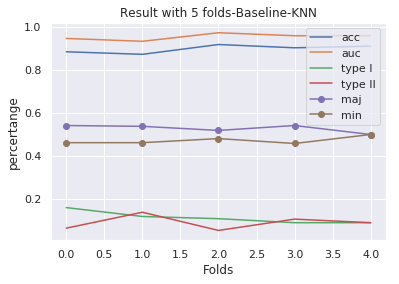

15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Mean : [0.89630074 0.95252521 0.11437294 0.09167665]
Discretize_X_test_dataframe[X_y_train_continuousData_dataframe]

-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-pac

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe-------------------------------NEXT ROUND-----------------------------

0_ALL
1_NOTALLMean Accuracy: 0.8819096626643796

Mean Accuracy[0.879245283018868, 0.9166666666666666, 0.8598484848484849, 0.8560606060606061, 0.8977272727272727]
Mean Auc: 0.9006378854825889
Mean Auc[0.8915040511240443, 0.9435631843740752, 0.8833043981481481, 0.8716969209558824, 0.9131208728107952]
Mean TypeII: 0.11662718805947998
Mean TypeII[0.09420289855072464, 0.09174311926605505, 0.11666666666666667, 0.1875, 0.09302325581395349]
Mean TypeI: 0.12016003277104592
Mean TypeI[0.14960629921259844, 0.07741935483870968, 0.1597222222222222, 0.10294117647058823, 0.1111111111111111]
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
-------------------------------NEXT ROUND-----------------------------
9_NOTALL
10_NOTALL[X_y_train_continuousData_dataframe]
-

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An


13_ALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_ALL
-------------------------------NEXT ROUND-----------------------------
1_NOTALL
2_NOTALL
3_NOTALL[X_y_train_continuousData_dataframe]
-------------------------------MDLP_R -----------------------------

4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
8_NOTALLX_test_continuousData_dataframe

0_ALL
9_NOTALL
10_NOTALL
1_NOTALL11_NOTALL

2_NOTALL
3_NOTALL
12_NOTALL
13_ALL
4_NOTALL14_NOTALL

15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
5_NOTALL
Discretize_X_test_dataframe6_NOTALL

7_NOTALL
8_NOTALL
9_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

10_NOTALL
11_NOTALL
12_NOTALL
13_ALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font fa

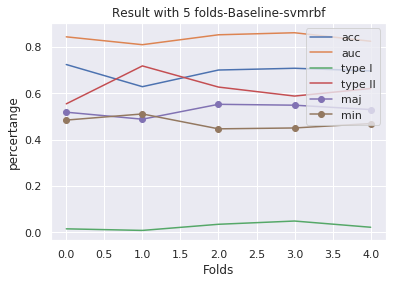

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Mean : [0.69187536 0.83886475 0.0252603  0.62190554]
[X_y_train_continuousData_dataframe]
-------------------------------MDLP_R -----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_ALL-------------------------------NEXT ROUND-----------------------------
1_NOTALL

Mean Accuracy: 0.8614608347627216
Mean Accuracy[0.8716981132075472, 0.875, 0.8712121212121212, 0.8636363636363636, 0.8257575757575758]
2_NOTALL
Mean Auc: 0.9323268842967426
Mean Auc[0.9550011392116656, 0.9288367773392152, 0.9426619985077197, 0.9280162515456634, 0.907118254879449]
Mean TypeII: 0.12982417306235328
Mean TypeII[0.12878787878787878, 0.1016949152542373, 0.10526315789473684, 0.14414414414414414, 0.16923076923076924]
Mean TypeI: 0.14683007057920675
Mean TypeI[0.12781954887218044, 0.14383561643835616, 0.15267175572519084, 0.13071895424836602, 0.1791044776119403]
3_NOTALL
4_NOTALL
5_NOT

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\An

15_NOTALL
[X_y_train_disData_dataframe]X_test_disData_dataframe
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe

X_test_categorialData_dataframe
0_ALL
1_NOTALL
Discretize_X_test_dataframe2_NOTALL

3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin


13_ALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
-------------------------------NEXT ROUND-----------------------------
Discretize_X_test_dataframe
[X_y_train_continuousData_dataframe]
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_ALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\User

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_ALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
-------------------------------NEXT ROUND-----------------------------
8_NOTALL
[X_y_train_continuousData_dataframe]
-------------------------------MDLP_R -----------------------------

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An


9_NOTALL[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_ALL

10_NOTALL
11_NOTALL
1_NOTALL
2_NOTALL
12_NOTALL
3_NOTALL
4_NOTALL13_ALL
14_NOTALL

15_NOTALL5_NOTALL

X_test_disData_dataframe
6_NOTALL
X_test_categorialData_dataframe7_NOTALL

Discretize_X_test_dataframe8_NOTALL

9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_ALL
14_NOTALL
15_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

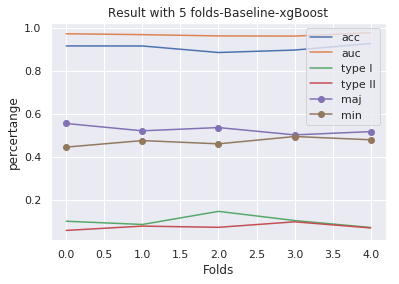

X_test_disData_dataframe
X_test_categorialData_dataframe
Mean : [0.9091538  0.96943983 0.1030281  0.07651208]
Discretize_X_test_dataframe
[X_y_train_continuousData_dataframe]
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_ALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
-------------------------------NEXT ROUND-----------------------------5_NOTALL

6_NOTALL
[X_y_train_continuousData_dataframe]7_NOTALL

8_NOTALL
9_NOTALL
-------------------------------MDLP_R -----------------------------
10_NOTALL

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An


11_NOTALL
12_NOTALL
13_ALL
14_NOTALL
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_ALL
1_NOTALL
2_NOTALL
3_NOTALL
15_NOTALL4_NOTALL

5_NOTALL
6_NOTALLX_test_disData_dataframe
-------------------------------NEXT ROUND-----------------------------
X_test_categorialData_dataframe

7_NOTALLDiscretize_X_test_dataframe
[X_y_train_continuousData_dataframe]
-------------------------------MDLP_R -----------------------------

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
8_NOTALLX_test_continuousData_dataframe
0_ALL

9_NOTALL1_NOTALL

2_NOTALL
10_NOTALL
3_NOTALL11_NOTALL

12_NOTALL
13_ALL
14_NOTALL4_NOTALL
15_NOTALL

5_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin


Discretize_X_test_dataframe
11_NOTALL
12_NOTALL
13_ALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
Mean Accuracy: 0.879631217838765
Mean Accuracy[0.8867924528301887, 0.8825757575757576, 0.8787878787878788, 0.8939393939393939, 0.8560606060606061]
Mean Auc: 0.9355556116760747
Mean Auc[0.9347293447293448, 0.93505859375, 0.9374706296992482, 0.9489148002770724, 0.9216046899247082]
Mean TypeII: 0.09544278191318982
Mean TypeII[0.0962962962962963, 0.09375, 0.0625, 0.10655737704918032, 0.11811023622047244]
Mean TypeI: 0.14169316236568635
Mean TypeI[0.13076923076923078, 0.13970588235294118, 0.16447368421052633, 0.1056338028169014, 0.1678832116788321]
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_ALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_ALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

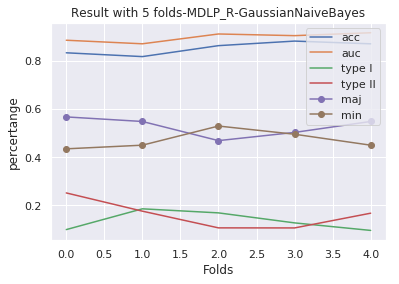

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


-------------------------------NEXT ROUND-----------------------------[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------



C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe][X_y_train_continuousData_dataframe]
-------------------------------MDLP_R -----------------------------

X_test_continuousData_dataframe
0_NOTALL
[X_y_train_disData_dataframe]1_NOTALL

[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
2_NOTALL
1_NOTALL
3_NOTALL
2_NOTALL
4_NOTALL
3_NOTALL
-------------------------------NEXT ROUND-----------------------------
5_NOTALLMean Accuracy: 0.8879731275014293
Mean Accuracy[0.8754716981132076, 0.8787878787878788, 0.8409090909090909, 0.9166666666666666, 0.928030303030303]
6_NOTALL

Mean Auc: 0.94372757636050224_NOTALL

Mean Auc[0.9377089818978438, 0.941733870967742, 0.9058467741935484, 0.960426267281106, 0.9729219874622708]
Mean TypeII: 0.09977114738733109
Mean TypeII[0.06779661016949153, 0.0967741935483871, 0.12096774193548387, 0.128571428571

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin


11_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
12_NOTALL
13_NOTALL
Discretize_X_test_dataframe
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL-------------------------------NEXT ROUND-----------------------------

2_NOTALL
3_NOTALL
4_NOTALL[X_y_train_continuousData_dataframe]

-------------------------------MDLP_R -----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_ALL
1_NOTALL
2_NOTALL5_NOTALL
3_NOTALL

6_NOTALL
4_NOTALL
5_NOTALL7_NOTALL

6_NOTALL
7_NOTALL
8_NOTALL
8_NOTALL
9_NOTALL
9_NOTALL
10_NOTALL
10_NOTALL11_NOTALL

12_NOTALL11_NOTALL

12_NOTALL
13_ALL
13_NOTALL
14_NOTALL
14_NOTALL15_NOTALL
X_test_disData_dataframe

X_test_categorialData_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

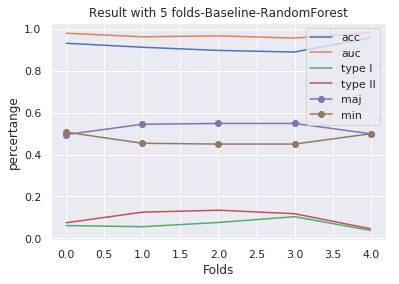

15_NOTALL
Discretize_X_test_dataframe
X_test_disData_dataframe
X_test_categorialData_dataframe
Mean : [0.91823328 0.96975901 0.06676268 0.09943645]
Discretize_X_test_dataframe
[X_y_train_continuousData_dataframe]
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL-------------------------------NEXT ROUND-----------------------------

13_ALL[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------

14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
Discretize_X_test_dataframe
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
-------------------------------NEXT ROUND-----------------------------Discretize_X_test_dataframe

[X_y_train_continuousData_dataframe]
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_ALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

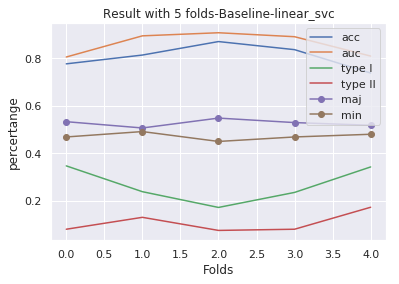


12_NOTALL
Mean : [0.80774443 0.86230536 0.26750349 0.10818363]
13_NOTALL
14_NOTALL
15_NOTALL
[X_y_train_continuousData_dataframe]
-------------------------------MDLP_R -----------------------------
X_test_disData_dataframe
-------------------------------NEXT ROUND-----------------------------
Mean Accuracy: 0.5276186392224128
Mean Accuracy[0.5433962264150943, 0.5757575757575758, 0.5227272727272727, 0.45454545454545453, 0.5416666666666666]
Mean Auc: 0.8588349526670683
Mean Auc[0.8301193755739209, 0.8985256109022556, 0.836783988957902, 0.8907986111111111, 0.837947176790152]
Mean TypeII: 1.0
Mean TypeII[1.0, 1.0, 1.0, 1.0, 1.0]X_test_categorialData_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An


Mean TypeI: 0.0
Mean TypeI[0.0, 0.0, 0.0, 0.0, 0.0]
[X_y_train_disData_dataframe]Discretize_X_test_dataframe

[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_ALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_ALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

[X_y_train_continuousData_dataframe]
-------------------------------MDLP_R -----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_ALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_ALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------MDLP_R -----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_ALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_ALL
14_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

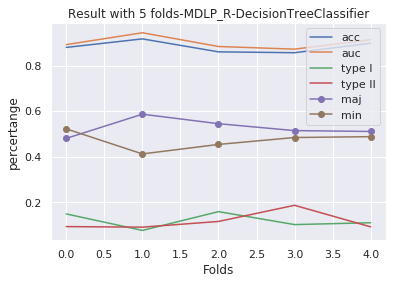

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe][X_y_train_continuousData_dataframe]
-------------------------------MDLP_R -----------------------------

-------------------------------CAIM_R -----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_ALL
1_NOTALL[X_y_train_disData_dataframe]

[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL2_NOTALL

3_NOTALL
4_NOTALL
5_NOTALL
3_NOTALL
6_NOTALL
4_NOTALL
7_NOTALL
5_NOTALL
8_NOTALL
6_NOTALL
9_NOTALL7_NOTALL

10_NOTALL
11_NOTALL8_NOTALL

9_NOTALL12_NOTALL

10_NOTALL13_NOTALL

14_NOTALL
11_NOTALL
12_NOTALL15_NOTALL

X_test_disData_dataframe
X_test_categorialData_dataframe
13_NOTALL
14_NOTALL

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  


Discretize_X_test_dataframe15_NOTALL

X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND------------------------------------------------------------NEXT ROUND-----------------------------
Mean Accuracy: 0.8940165809033733
Mean Accuracy[0.8981132075471698, 0.8901515151515151, 0.9015151515151515, 0.8825757575757576, 0.8977272727272727]
Mean Auc: 0.9520321060164758
Mean Auc[0.9593175853018372, 0.9481947991641514, 0.9575251798561152, 0.9490783410138249, 0.9460446247464502]
Mean TypeII: 0.09500374077127463
Mean TypeII[0.08695652173913043, 0.13559322033898305, 0.072, 0.10483870967741936, 0.07563025210084033]
Mean TypeI: 0.1164325699980352
Mean TypeI[0.11811023622047244, 0.08904109589041095, 0.1223021582733813, 0.12857142857142856, 0.12413793103448276]

13_NOTALL
[X_y_train_continuousData_dataframe]
14_NOTALL
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

[X_y_train_disData_dataframe]15_NOTALL

[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_ALL
X_test_disData_dataframe
X_test_categorialData_dataframe
1_NOTALL
Discretize_X_test_dataframe
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)



-------------------------------CAIM_R -----------------------------
[X_y_train_disData_dataframe]


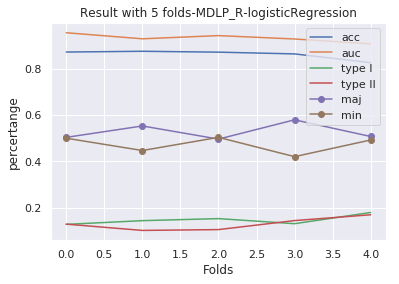

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------
1_NOTALL

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin


2_NOTALL
3_NOTALL
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
4_NOTALL[Discretize_X_train_dataframe]

X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
5_NOTALL
3_NOTALL
6_NOTALL
4_NOTALL
7_NOTALL5_NOTALL

8_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL9_NOTALL

10_NOTALL
10_NOTALL11_NOTALL

11_NOTALL
12_NOTALL
-------------------------------NEXT ROUND-----------------------------
12_NOTALL
13_NOTALL
13_NOTALL14_NOTALL
[X_y_train_continuousData_dataframe]

-------------------------------MDLP_R -----------------------------
14_NOTALL15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe

15_NOTALL[X_y_train_disData_dataframe]
Discretize_X_test_dataframe

X_test_disData_dataframe[X_train_disData_dataframe]
X_test_categorialData_dataframe

[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_ALL
1_NOTALL
2_NOTALLDiscretize_X_test_dataframe

3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_ALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font fa

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
-------------------------------NEXT ROUND-----------------------------
1_NOTALL
2_NOTALL
[X_y_train_continuousData_dataframe]3_NOTALL

4_NOTALL
-------------------------------CAIM_R -----------------------------
5_NOTALL
6_NOTALL
7_NOTALL
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
8_NOTALL
9_NOTALL
1_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
2_NOTALL
13_NOTALL
14_NOTALL
3_NOTALL15_NOTALL
X_test_disData_dataframe

X_test_categorialData_dataframe
4_NOTALL
Discretize_X_test_dataframe5_NOTALL

6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
-------------------------------NEXT ROUND-----------------------------
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
[X_y_train_continuousData_dataframe]8_NOTALL

9_NOTALL-------------------------------MDLP_R -----------------------------

-------------------------------NEXT ROUND-----------------------------10_NOTALL

11_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_ALL
1_NOTALL
12_NOTALL
2_NOTALL
13_NOTALL
[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


3_NOTALL
4_NOTALL14_NOTALL

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL5_NOTALL15_NOTALL

1_NOTALL

6_NOTALL
X_test_disData_dataframe2_NOTALL
7_NOTALL

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

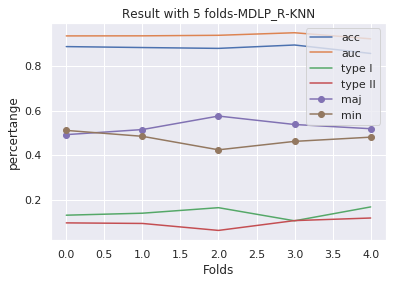

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)



X_test_categorialData_dataframe

3_NOTALL
8_NOTALL4_NOTALL

5_NOTALL
9_NOTALL6_NOTALL
7_NOTALL
Discretize_X_test_dataframe

10_NOTALL
8_NOTALL
9_NOTALL11_NOTALL

[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------12_NOTALL

10_NOTALL13_NOTALL

14_NOTALL
[X_y_train_disData_dataframe]15_NOTALL

11_NOTALL[X_train_disData_dataframe]
[X_train_categorialData_dataframe]

[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
-------------------------------NEXT ROUND-----------------------------1_NOTALL

12_NOTALLX_test_disData_dataframe
X_test_categorialData_dataframe
2_NOTALL

3_NOTALL13_NOTALL

Discretize_X_test_dataframe
4_NOTALL[X_y_train_continuousData_dataframe]14_NOTALL


-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


5_NOTALL15_NOTALL

X_test_disData_dataframe-------------------------------NEXT ROUND-----------------------------

X_test_categorialData_dataframe[X_y_train_disData_dataframe]

Discretize_X_test_dataframe[X_train_disData_dataframe]
[X_train_categorialData_dataframe]

[X_y_train_continuousData_dataframe][Discretize_X_train_dataframe]
X_test_continuousData_dataframe

-------------------------------CAIM_R -----------------------------
0_ALL6_NOTALL

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An



[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
1_NOTALL7_NOTALLX_test_continuousData_dataframe
0_NOTALL


8_NOTALL
1_NOTALL9_NOTALL

2_NOTALL
10_NOTALL
2_NOTALL
3_NOTALL
3_NOTALL11_NOTALL

4_NOTALL
4_NOTALL
5_NOTALL
5_NOTALL12_NOTALL6_NOTALL
7_NOTALL


8_NOTALL6_NOTALL

9_NOTALL
13_NOTALL
14_NOTALL
7_NOTALL
10_NOTALL8_NOTALL
15_NOTALL

9_NOTALL
11_NOTALL
X_test_disData_dataframe10_NOTALL

X_test_categorialData_dataframe
Discretize_X_test_dataframe
12_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL13_ALL

14_NOTALL
15_NOTALL15_NOTALL

X_test_disData_dataframe
X_test_categorialData_dataframe
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe-------------------------------NEXT ROUND-----------------------------
Mean Accuracy: 0.5336792452830189
Mean Accuracy[0.5433962264150943, 0.5681818181818182, 0.5378787878787878, 0.4696969696969697, 0.5492424242424242]

Mean Auc: 0.529175455

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font fa

-------------------------------NEXT ROUND-----------------------------
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
[X_y_train_continuousData_dataframe]-------------------------------CAIM_R -----------------------------

-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]

0_NOTALL
1_NOTALL[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
2_NOTALL

0_NOTALL
1_NOTALL3_NOTALL

2_NOTALL
3_NOTALL4_NOTALL

5_NOTALL4_NOTALL

6_NOTALL5_NOTALL

7_NOTALL
6_NOTALL
7_NOTALL8_NOTALL

8_NOTALL
9_NOTALL
10_NOTALL
9_NOTALL
10_NOTALL11_NOTALL

11_NOTALL
12_NOTALL12_NOTALL

13_NOTALL
13_NOTALL
14_NOTALL
14_NOTALL
15_NOTALL15_NOTALL
X_test_disData_dataframe

X_test_disData_dataframe
X_test_categorialData_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

X_test_categorialData_dataframe
Discretize_X_test_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
Mean Accuracy: 0.6873441966838193
Mean Accuracy[0.7056603773584905, 0.6363636363636364, 0.7840909090909091, 0.6363636363636364, 0.6742424242424242]
Mean Auc: 0.9025072963897566
Mean Auc[0.8930493530287416, 0.8907628437986508, 0.9083969465648855, 0.9065393518518519, 0.9137879867046533]
Mean TypeII: 0.6316059103124092
Mean TypeII[0.5070422535211268, 0.7560975609756098, 0.35877862595419846, 0.7583333333333333, 0.7777777777777778]
Mean TypeI: 0.038557557703421196
Mean TypeI[0.04878048780487805, 0.02127659574468085, 0.07518796992481203, 0.034722222222222224, 0.01282051282051282]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font fa

-------------------------------NEXT ROUND-----------------------------
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------MDLP_R -----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
3_NOTALL
X_test_continuousData_dataframe
0_ALL
1_NOTALL
4_NOTALL
2_NOTALL
5_NOTALL
6_NOTALL
3_NOTALL
7_NOTALL
4_NOTALL
5_NOTALL
8_NOTALL6_NOTALL

7_NOTALL
8_NOTALL
9_NOTALL
9_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


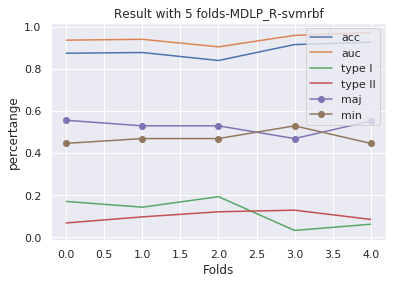

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


10_NOTALL
10_NOTALL
11_NOTALL
11_NOTALL12_NOTALL
13_ALL
14_NOTALL

12_NOTALL
15_NOTALL
X_test_disData_dataframe13_NOTALL
[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------
14_NOTALL

X_test_categorialData_dataframe
15_NOTALL
Discretize_X_test_dataframe
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALLX_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe

2_NOTALL
3_NOTALL
-------------------------------NEXT ROUND-----------------------------
4_NOTALL
[X_y_train_continuousData_dataframe]
-------------------------------MDLP_R -----------------------------
5_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

[X_y_train_disData_dataframe]
6_NOTALL
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
7_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
8_NOTALL
9_NOTALL5_NOTALL

6_NOTALL
7_NOTALL10_NOTALL

8_NOTALL
11_NOTALL
9_NOTALL12_NOTALL

10_NOTALL
13_NOTALL11_NOTALL

12_NOTALL
14_NOTALL
13_ALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
Discretize_X_test_dataframe-------------------------------NEXT ROUND-----------------------------

[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
Mean Accuracy: 0.8932532875929102
2_NOTALLMean Accuracy[0.9056603773584906, 0.890

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
-------------------------------NEXT ROUND-----------------------------

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

13_NOTALL

14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

[X_y_train_disData_dataframe]Discretize_X_test_dataframe

[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font fami

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
-------------------------------NEXT ROUND-----------------------------
6_NOTALL

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


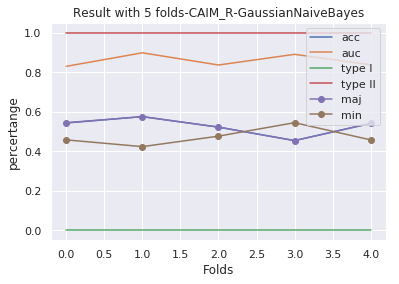

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)



[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------7_NOTALL

8_NOTALL
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


2_NOTALL9_NOTALL
3_NOTALL

10_NOTALL
4_NOTALL
11_NOTALL
[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------
5_NOTALL
12_NOTALL6_NOTALL

7_NOTALL
8_NOTALL
9_NOTALL
13_NOTALL
10_NOTALL14_NOTALL

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe11_NOTALL15_NOTALL

X_test_disData_dataframe
0_NOTALL

X_test_categorialData_dataframe
1_NOTALL
Discretize_X_test_dataframe12_NOTALL

2_NOTALL
-------------------------------NEXT ROUND-----------------------------
Mean Accuracy: 0.9038707833047456
Mean Accuracy[0.8905660377358491, 0.9053030303030303, 0.9015151515151515, 0.9204545454545454, 0.9015151515151515]
Mean Auc: 0.9482266096219838
Mean Auc[0.9431046391159204, 0.9446169772256728, 0.9429687500000001, 0.9584553545793857, 0.9519873271889402]
Mean TypeII: 0.10606959629730028
Mean TypeII[0.1092436974789916, 0.09523809523809523, 0.1166666

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\User

-------------------------------NEXT ROUND-----------------------------
Mean Accuracy: 0.5533762149799886
Mean Accuracy[0.5433962264150943, 0.553030303030303, 0.5492424242424242, 0.5643939393939394, 0.5568181818181818]
Mean Auc: 0.5472981310350491
Mean Auc[0.5768419251824817, 0.5301274289338638, 0.49034926470588236, 0.5669839795681448, 0.5721880567848727]
Mean TypeII: 0.8290810684823452
Mean TypeII[0.6953125, 0.943089430894309, 0.6953125, 0.8983050847457628, 0.9133858267716536]
Mean TypeI: 0.10745847609648713
Mean TypeI[0.23357664233576642, 0.014184397163120567, 0.22058823529411764, 0.06164383561643835, 0.0072992700729927005]
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
-------------------------------NEXT ROUND-----------------------------
10_NOTALL
11_NOTALL[X_y_train_continuousData_dataframe]

-------------------------------ChiMerge_R -----------------------------
12_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

13_NOTALL
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL14_NOTALL

3_NOTALL
15_NOTALL
4_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\User

12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An


X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
-------------------------------NEXT ROUND-----------------------------
9_NOTALL
[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------
10_NOTALL
11_NOTALL[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL

1_NOTALL
12_NOTALL
13_NOTALL2_NOTALL

14_NOTALL
3_NOTALL
15_NOTALL
4_NOTALL
X_test_disData_dataframe
5_NOTALLX_test_categorialData_dataframe

6_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

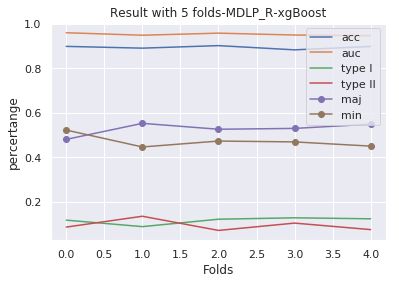

7_NOTALL
Discretize_X_test_dataframe
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
[X_y_train_continuousData_dataframe]
13_NOTALL
14_NOTALL-------------------------------CAIM_R -----------------------------

15_NOTALL
[X_y_train_disData_dataframe]X_test_disData_dataframe

X_test_categorialData_dataframe
Discretize_X_test_dataframe[X_train_disData_dataframe]

[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
-------------------------------NEXT ROUND-----------------------------
Mean Accuracy: 0.5503373356203545
Mean Accuracy[0.5547169811320755, 0.571969696969697, 0.4696969696969697, 0.5606060606060606, 0.5946969696969697]
Mean Auc: 0.6830999899640465
Mean Auc[0.7128568153158317, 0.6785006989748369, 0.7860311059907835, 0.8239889705882353, 0.4141223589505456]
15_NOTALL
Mean TypeII: 0.9460270034300716

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to De

X_test_disData_dataframe
X_test_categorialData_dataframe

-------------------------------NEXT ROUND-----------------------------
Mean TypeII[0.9672131147540983, 0.9655172413793104, 1.0, 0.890625, 0.9067796610169492]
Mean TypeI: 0.004292527821939587
Mean TypeI[0.0, 0.006756756756756757, 0.0, 0.014705882352941176, 0.0]
Discretize_X_test_dataframe
[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin


X_test_categorialData_dataframe
-------------------------------NEXT ROUND-----------------------------Discretize_X_test_dataframe

[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

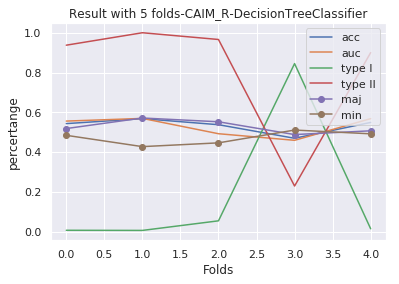

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------
4_NOTALL
5_NOTALL
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL6_NOTALL

2_NOTALL
7_NOTALL
8_NOTALL
3_NOTALL
9_NOTALL
10_NOTALL4_NOTALL

5_NOTALL
11_NOTALL
6_NOTALL
12_NOTALL
7_NOTALL-------------------------------NEXT ROUND-----------------------------

Mean Accuracy: 0.8304431103487706
Mean Accuracy[0.8150943396226416, 0.8484848484848485, 0.8560606060606061, 0.7954545454545454, 0.8371212121212122]
Mean Auc: 0.8914034081662108
Mean Auc[0.8912298732442617, 0.9243055555555556, 0.9155506811359964, 0.8285304247990815, 0.8974005060961584]
Mean TypeII: 0.161019936347805

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------
-------------------------------NEXT ROUND-----------------------------


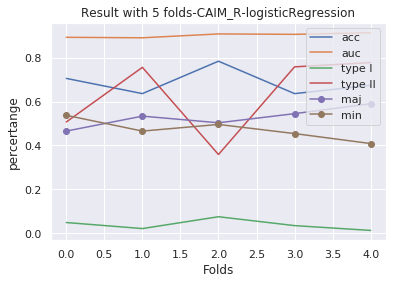

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
1_NOTALL2_NOTALL

2_NOTALL
3_NOTALL
3_NOTALL[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------
4_NOTALL



C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


4_NOTALL
5_NOTALL
5_NOTALL
[X_y_train_disData_dataframe]6_NOTALL
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
6_NOTALL

7_NOTALL2_NOTALL

7_NOTALL
8_NOTALL
9_NOTALL
3_NOTALL
10_NOTALL
8_NOTALL11_NOTALL4_NOTALL


12_NOTALL9_NOTALL

5_NOTALL
13_NOTALL
6_NOTALL10_NOTALL

11_NOTALL14_NOTALL

7_NOTALL12_NOTALL
15_NOTALL

X_test_disData_dataframe13_NOTALL

8_NOTALL
X_test_categorialData_dataframe
14_NOTALL
9_NOTALL15_NOTALL

X_test_disData_dataframeDiscretize_X_test_dataframe

X_test_categorialData_dataframe
10_NOTALL
Discretize_X_test_dataframe
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font fa

[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------
-------------------------------NEXT ROUND-----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL[X_y_train_continuousData_dataframe]

-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
2_NOTALL
3_NOTALL
1_NOTALL
4_NOTALL
2_NOTALL
5_NOTALL3_NOTALL

4_NOTALL
6_NOTALL
5_NOTALL
6_NOTALL7_NOTALL

7_NOTALL
8_NOTALL
8_NOTALL
9_NOTALL
9_NOTALL
10_NOTALL10_NOTALL

11_NOTALL
11_NOTALL
12_NOTALL
12_NOTALL13_NOTALL

13_NOTALL
14_NOTALL
15_NOTALL
14_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframeDiscretize_X_test_dataframe



C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font fa

-------------------------------NEXT ROUND------------------------------------------------------------NEXT ROUND-----------------------------

[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL[X_y_train_continuousData_dataframe]

-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
1_NOTALL0_NOTALL
1_NOTALL

2_NOTALL2_NOTALL

-------------------------------NEXT ROUND-----------------------------3_NOTALL

3_NOTALL4_NOTALL
5_NOTALL
6_NOTALL

4_NOTALL[X_y_train_continuousData_dataframe]
7_NOTALL
5_NOTALL

-------------------------------CAIM_R -----------------------------
6_NOTALL
7_NOTALL8_NOTALL

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


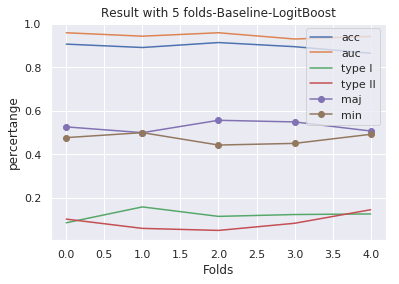



9_NOTALL
10_NOTALL[X_y_train_disData_dataframe]

[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
8_NOTALL[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL

1_NOTALL9_NOTALL

2_NOTALL
3_NOTALL
11_NOTALL10_NOTALL

4_NOTALL
Mean : [0.89325329 0.9456106  0.12241434 0.08905003]
5_NOTALL12_NOTALL
11_NOTALL

[X_y_train_continuousData_dataframe]13_NOTALL
-------------------------------MDLP_R -----------------------------

14_NOTALL
15_NOTALL
12_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-pac

Discretize_X_test_dataframe[X_y_train_disData_dataframe]6_NOTALL13_NOTALL



14_NOTALL[X_train_disData_dataframe]
7_NOTALL
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_ALL

15_NOTALL8_NOTALL

9_NOTALLX_test_disData_dataframe1_NOTALL

2_NOTALL
10_NOTALL
3_NOTALL

4_NOTALLX_test_categorialData_dataframe

11_NOTALL
12_NOTALL
5_NOTALL
6_NOTALL13_NOTALLDiscretize_X_test_dataframe


14_NOTALL7_NOTALL

15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_ALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe-------------------------------NEXT ROUND-----------------------------

[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------
-------------------------------NEXT ROUND-----------------------------
Mean Accuracy: 0.884928530588908
Mean Ac

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin


13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


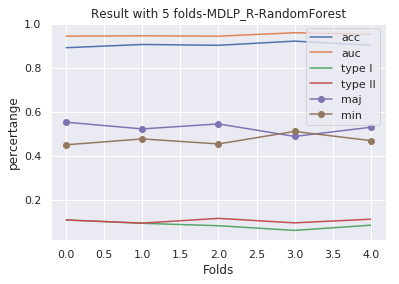

10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


15_NOTALL
X_test_disData_dataframe
[X_y_train_disData_dataframe]X_test_categorialData_dataframe

[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
-------------------------------NEXT ROUND-----------------------------
[Discretize_X_train_dataframe]
[X_y_train_continuousData_dataframe]X_test_continuousData_dataframeDiscretize_X_test_dataframe

-------------------------------CAIM_R -----------------------------

0_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-pac

1_NOTALL
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL2_NOTALL

2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
3_NOTALL7_NOTALL

8_NOTALL
4_NOTALL
9_NOTALL
5_NOTALL
10_NOTALL
11_NOTALL6_NOTALL

12_NOTALL
13_NOTALL
7_NOTALL14_NOTALL

8_NOTALL
9_NOTALL15_NOTALL

10_NOTALL
-------------------------------NEXT ROUND-----------------------------
X_test_disData_dataframe11_NOTALL
X_test_categorialData_dataframe
Mean Accuracy: 0.8493453401943969
Mean Accuracy[0.8641509433962264, 0.8446969696969697, 0.8409090909090909, 0.8636363636363636, 0.8333333333333334]
Mean Auc: 0.9262267976671685
Mean Auc[0.9364889496468443, 0.9180683349938463, 0.9154352343569615, 0.9426229508196721, 0.9185185185185184]
Mean TypeII: 0.16001844940043114
Mean TypeII[0.1590909090909091, 0.168141592920354, 0.1557377049180328, 0.13934426229508196, 0.17777777777777778]
Mean TypeI: 0.14185814534057503
Me

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin


14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

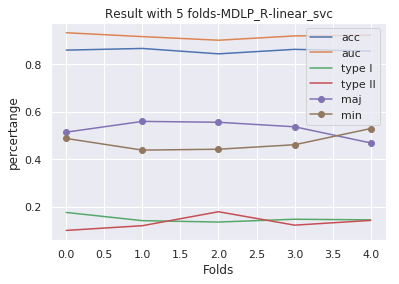

[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
-------------------------------NEXT ROUND-----------------------------
1_NOTALLMean Accuracy: 0.5442967409948543
2_NOTALL

Mean Accuracy[0.5283018867924528, 0.5189393939393939, 0.5568181818181818, 0.5984848484848485, 0.5189393939393939]
Mean Auc: 0.5706532970778622
Mean Auc[0.5989405331510594, 0.6009585031280491, 0.5579710144927535, 0.5708392687559354, 0.5245571658615137]
Mean TypeII: 0.8985534234228488
Mean TypeII[0.924812030075188, 0.9541984732824428, 0.6507936507936508, 0.9629629629629629, 1.0]
Mean TypeI: 0.060775837434876336
Mean TypeI[0.015151515151515152, 0.015037593984962405, 0.2536231884057971, 0.01282051282051282, 0.007246376811594203]
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL-------------------------------NEXT ROUND-----------------------------

8_NOTALL
9_NOTALL
[X_y_train_continuousData_dataframe]
----------

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
14_NOTALL
15_NOTALL
1_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
2_NOTALL
Discretize_X_test_dataframe
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


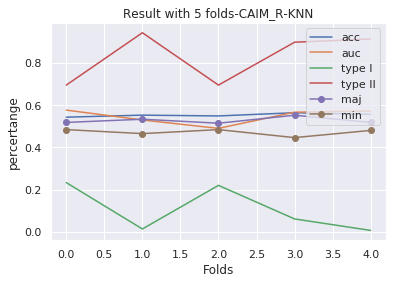

2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


6_NOTALL
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
7_NOTALLX_test_continuousData_dataframe
0_NOTALL

8_NOTALL
9_NOTALL
Mean Accuracy: 0.883419096626643810_NOTALL
1_NOTALL

11_NOTALL
Mean Accuracy[0.8867924528301887, 0.8939393939393939, 0.9015151515151515, 0.8712121212121212, 0.8636363636363636]
2_NOTALLMean Auc: 0.9544259069319004
Mean Auc[0.9639601139601139, 0.9653391449725339, 0.9563993566176471, 0.9482709099264707, 0.9381600091827365]
Mean TypeII: 0.09770260203632845
Mean TypeII[0.11538461538461539, 0.05660377358490566, 0.09375, 0.1015625, 0.12121212121212122]
Mean TypeI: 0.13184394202636943
Mean TypeI[0.1111111111111111, 0.13924050632911392, 0.10294117647058823, 0.15441176470588236, 0.15151515151515152]

12_NOTALL3_NOTALL

4_NOTALL
13_NOTALL
5_NOTALL
14_NOTALL
6_NOTALL
15_NOTALL
-------------------------------NEXT ROUND-----------------------------
X_test_disData_dataframe7_NOTALL
X_test_categorialDat

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

10_NOTALL
11_NOTALL
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_ALL
1_NOTALL
12_NOTALL2_NOTALL

13_NOTALL3_NOTALL

14_NOTALL
4_NOTALL15_NOTALL

5_NOTALL
X_test_disData_dataframe6_NOTALL

X_test_categorialData_dataframe
Discretize_X_test_dataframe
7_NOTALL
8_NOTALL
9_NOTALL
-------------------------------NEXT ROUND-----------------------------
10_NOTALL
11_NOTALL[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALLX_test_continuousData_dataframe
0_NOTALL

1_NOTALL
2_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
3_NOTALL
Discretize_X_test_dataframe
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin


10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarni

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL-------------------------------NEXT ROUND-----------------------------

[X_y_train_continuousData_dataframe]11_NOTALL

-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

12_NOTALL
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
13_NOTALL1_NOTALL

14_NOTALL2_NOTALL

3_NOTALL
4_NOTALL
15_NOTALL
5_NOTALL
6_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
7_NOTALL
Discretize_X_test_dataframe
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


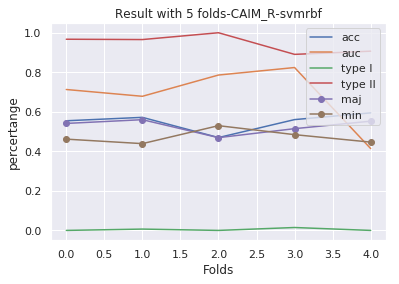

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------
[X_y_train_disData_dataframe]2_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin


3_NOTALL
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
4_NOTALL
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
5_NOTALL
6_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
7_NOTALL
5_NOTALL
8_NOTALL
6_NOTALL9_NOTALL

10_NOTALL
7_NOTALL
11_NOTALL
12_NOTALL
8_NOTALL
9_NOTALL
13_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL14_NOTALL

15_NOTALL
13_NOTALLX_test_disData_dataframe
X_test_categorialData_dataframe

Discretize_X_test_dataframe
14_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
4_NOTALL
-------------------------------ChiMerge_R -----------------------------
-------------------------------NEXT ROUND-----------------------------5_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
6_NOTALL
7_NOTALL
3_NOTALL8_NOTALL

4_NOTALL
9_NOTALL[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------5_NOTALL


6_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


7_NOTALL
10_NOTALL
11_NOTALL
8_NOTALL
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
9_NOTALL
12_NOTALL
13_NOTALLX_test_continuousData_dataframe

14_NOTALL
0_NOTALL10_NOTALL

15_NOTALL
11_NOTALL
1_NOTALL-------------------------------NEXT ROUND-----------------------------
X_test_disData_dataframe

X_test_categorialData_dataframe
12_NOTALL
13_NOTALL
[X_y_train_continuousData_dataframe]
Discretize_X_test_dataframe
2_NOTALL-------------------------------CAIM_R -----------------------------
14_NOTALL

3_NOTALL
4_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

5_NOTALL
6_NOTALL
15_NOTALL
7_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
8_NOTALL
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
Discretize_X_test_dataframeX_test_continuousData_dataframe
0_NOTALL

9_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL10_NOTALL

11_NOTALL
6_NOTALL
12_NOTALL7_NOTALL

13_NOTALL
14_NOTALL8_NOTALL

15_NOTALL
9_NOTALL
10_NOTALLX_test_disData_dataframe

X_test_categorialData_dataframe
Discretize_X_test_dataframe
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\User

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

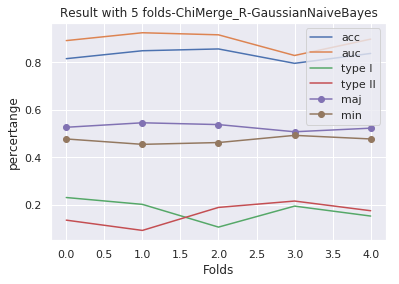


[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
[X_y_train_continuousData_dataframe]4_NOTALL

-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


5_NOTALL
6_NOTALL
-------------------------------NEXT ROUND-----------------------------[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe

0_NOTALL
7_NOTALL1_NOTALL

2_NOTALL
[X_y_train_continuousData_dataframe]
3_NOTALL
-------------------------------ChiMerge_R -----------------------------
8_NOTALL
4_NOTALL
9_NOTALL[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
5_NOTALL

1_NOTALL
6_NOTALL
10_NOTALL2_NOTALL
7_NOTALL

11_NOTALL3_NOTALL
8_NOTALL

9_NOTALL
10_NOTALL12_NOTALL

13_NOTALL
4_NOTALL11_NOTALL
14_NOTALL

12_NOTALL
15_NOTALL
13_NOTALL5_NOTALL

14_NOTALLX_test_disData_dataframe
6_NOTALL
X_test_categorialData_dataframe

Discretize_X_test_dataframe
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

7_NOTALL

8_NOTALL-------------------------------NEXT ROUND-----------------------------

9_NOTALL[X_y_train_continuousData_dataframe]

-------------------------------CAIM_R -----------------------------
10_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


11_NOTALL
12_NOTALL
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
13_NOTALL
X_test_continuousData_dataframe
0_NOTALL14_NOTALL

1_NOTALL
15_NOTALL
2_NOTALL
X_test_disData_dataframe3_NOTALL
X_test_categorialData_dataframe

Discretize_X_test_dataframe
4_NOTALL
5_NOTALL
-------------------------------NEXT ROUND-----------------------------
6_NOTALL
7_NOTALL
[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

8_NOTALL
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
9_NOTALL
1_NOTALL
-------------------------------NEXT ROUND-----------------------------
2_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL3_NOTALL

[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\User

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]13_NOTALL
14_NOTALL
15_NOTALL
-------------------------------NEXT ROUND-----------------------------4_NOTALL
5_NOTALL
Mean Accuracy: 0.9053744997141223
Mean Accuracy[0.9056603773584906, 0.9166666666666666, 0.9053030303030303, 0.8977272727272727, 0.9015151515151515]
Mean Auc: 0.958777266134548
Mean Auc[0.9620303756994405, 0.9684892086330935, 0.9521713087750824, 0.956686580882353, 0.9545088566827697]


[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
Mean TypeII: 0.08027106885919835
Mean TypeII[0.03968253968253968, 0.06474820143884892, 0.12380952380952381, 0.09375, 0.07936507936507936]
Mean TypeI: 0.1099185473664209
Mean TypeI[0.14388489208633093, 0.104, 0.07547169811320754, 0.11029411764705882, 0.11594202898550725]
1_NOTALL
6_NOTALL2_NOTALLX_test_disData_dataframe


X_test_categorialData_dataframe
7_NOTALL
Discretize_X_test_dataframe
8_NOTALL
3_NOTALL
9_NOTALL
4_NOTALL
10_N

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
-------------------------------NEXT ROUND-----------------------------5_NOTALL

[X_y_train_continuousData_dataframe]
6_NOTALL
-------------------------------ChiMerge_R -----------------------------
7_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

8_NOTALL[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]

[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
9_NOTALL
1_NOTALL
10_NOTALL
2_NOTALL
11_NOTALL
3_NOTALL
12_NOTALL
4_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL


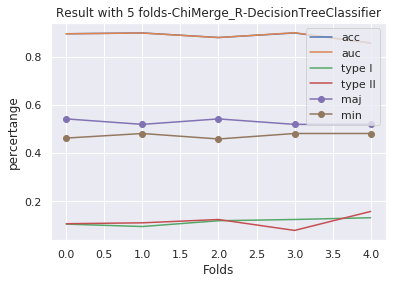

5_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
6_NOTALL
[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------
Discretize_X_test_dataframe7_NOTALL

8_NOTALL
9_NOTALL
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
10_NOTALL[Discretize_X_train_dataframe]

X_test_continuousData_dataframe-------------------------------NEXT ROUND-----------------------------

0_NOTALL
1_NOTALL
11_NOTALL-------------------------------NEXT ROUND-----------------------------

Mean Accuracy: 0.653256146369354
Mean Accuracy[0.7018867924528301, 0.571969696969697, 0.6856060606060606, 0.6477272727272727, 0.6590909090909091]
Mean Auc: 0.9047923575575412
Mean Auc[0.9299641286739181, 0.8955395683453238, 0.9174018335928039, 0.9078932261768083, 0.873163030998852]
Mean TypeII: 0.7051534277889199
Mean TypeII[0.6724137931034483, 0.888, 0.6422764227642277, 0.7, 0.6230769230769231]
Mean TypeI: 0.0263116490339306

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)



13_NOTALL4_NOTALL

14_NOTALL
5_NOTALL
6_NOTALL
15_NOTALL
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]X_test_disData_dataframe
X_test_categorialData_dataframe

7_NOTALL
X_test_continuousData_dataframe
0_ALL
Discretize_X_test_dataframe
1_NOTALL
8_NOTALL
9_NOTALL
2_NOTALL10_NOTALL

3_NOTALL
11_NOTALL
12_NOTALL
4_NOTALL
13_NOTALL
14_NOTALL
5_NOTALL15_NOTALL

X_test_disData_dataframe
6_NOTALL
X_test_categorialData_dataframe
7_NOTALL
8_NOTALL
Discretize_X_test_dataframe
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_ALL
14_NOTALL
-------------------------------NEXT ROUND-----------------------------
15_NOTALL

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))



[X_y_train_continuousData_dataframe]X_test_disData_dataframe

-------------------------------CACC_R -----------------------------
X_test_categorialData_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

Discretize_X_test_dataframe[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL

1_NOTALL
-------------------------------NEXT ROUND-----------------------------
2_NOTALL
[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------
3_NOTALL
4_NOTALL
5_NOTALL-------------------------------NEXT ROUND-----------------------------

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
6_NOTALL
[Discretize_X_train_dataframe]
7_NOTALLX_test_continuousData_dataframe[X_y_train_continuousData_dataframe]

-------------------------------ChiMerge_R -----------------------------
0_NOTALL



C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


8_NOTALL
1_NOTALL
9_NOTALL
2_NOTALL
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
10_NOTALL
3_NOTALL
4_NOTALL
11_NOTALL
5_NOTALL1_NOTALL

6_NOTALL
12_NOTALL
2_NOTALL
13_NOTALL
3_NOTALL
4_NOTALL
14_NOTALL5_NOTALL
7_NOTALL

15_NOTALL
6_NOTALL
8_NOTALL
7_NOTALL
-------------------------------NEXT ROUND-----------------------------9_NOTALL

Mean Accuracy: 0.5465666094911378
Mean Accuracy[0.5320754716981132, 0.5075757575757576, 0.5984848484848485, 0.5606060606060606, 0.5340909090909091]
Mean Auc: 0.5701836663754875
Mean Auc[0.5843397516235616, 0.5762055109070034, 0.5476608187134503, 0.574529121993625, 0.568183128639797]
Mean TypeII: 0.9128587491555932
Mean TypeII[0.7686567164179104, 0.9253731343283582, 0.9122807017543859, 0.957983193277311, 1.0]
Mean TypeI: 0.04671712528938114
Mean TypeI[0.16030534351145037, 0.046153846153846156, 0.013333333333333334, 0.013793103448275862, 

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An


10_NOTALL13_NOTALL

14_NOTALL11_NOTALL

12_NOTALL
15_NOTALL
13_NOTALL
X_test_disData_dataframe14_NOTALL
X_test_categorialData_dataframe

15_NOTALL
Discretize_X_test_dataframe
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
-------------------------------NEXT ROUND-----------------------------
8_NOTALL
9_NOTALL
[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------
10_NOTALL
11_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\User

12_NOTALL[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]

[Discretize_X_train_dataframe]
13_NOTALL
X_test_continuousData_dataframe
0_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe1_NOTALL
X_test_categorialData_dataframe

Discretize_X_test_dataframe
2_NOTALL
3_NOTALL
4_NOTALL-------------------------------NEXT ROUND-----------------------------

Mean Accuracy: 0.57988850771869655_NOTALL
Mean Accuracy[0.5471698113207547, 0.625, 0.5606060606060606, 0.5681818181818182, 0.5984848484848485]
Mean Auc: 0.9238769098061832
Mean Auc[0.8992592592592593, 0.9219356708200522, 0.9336978417266187, 0.9220149253731343, 0.9424768518518517]
Mean TypeII: 0.8871147597500538
Mean TypeII[0.9230769230769231, 0.8319327731092437, 0.928, 0.8692307692307693, 0.8833333333333333]
Mean TypeI: 0.0014925373134328358
Mean TypeI[0.0, 0.0, 0.0, 0.007462686567164179, 0.0]

6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

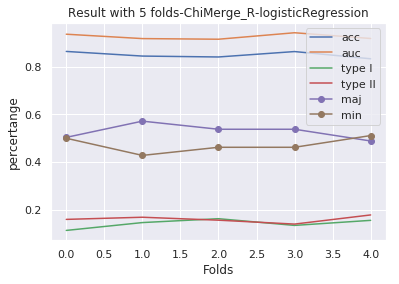

[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
-------------------------------NEXT ROUND-----------------------------
7_NOTALL
[X_y_train_continuousData_dataframe]
8_NOTALL-------------------------------CACC_R -----------------------------



C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
9_NOTALL[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL

3_NOTALL
4_NOTALL10_NOTALL

5_NOTALL
11_NOTALL
6_NOTALL
12_NOTALL
7_NOTALL13_NOTALL

8_NOTALL14_NOTALL

9_NOTALL
10_NOTALL
15_NOTALL
11_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
12_NOTALL
Discretize_X_test_dataframe
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin


-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
-------------------------------NEXT ROUND-----------------------------5_NOTALL

6_NOTALL
7_NOTALL
[X_y_train_continuousData_dataframe]
8_NOTALL
-------------------------------CACC_R -----------------------------9_NOTALL

10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
15_NOTALLX_test_continuousData_dataframe
0_NOTALL

X_test_disData_dataframe
X_test_categorialData_dataframe
1_NOTALL
2_NOTALLDiscretize_X_test_dataframe

3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
-------------------------------NEXT ROUND-----------------------------

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin


-------------------------------NEXT ROUND-----------------------------
Mean Accuracy: 0.5450600343053174
Mean Accuracy[0.5207547169811321, 0.6401515151515151, 0.42045454545454547, 0.4810606060606061, 0.6628787878787878]
Mean Auc: 0.5458526272077899
Mean Auc[0.5140123034859878, 0.6442982456140351, 0.4149816176470589, 0.4968286916911722, 0.6591422776006954]
Mean TypeII: 0.47561772404141969_NOTALL

Mean TypeII[0.9545454545454546, 0.2894736842105263, 0.40441176470588236, 0.2926829268292683, 0.4369747899159664]
Mean TypeI: 0.43159232017130134
Mean TypeI[0.007518796992481203, 0.41333333333333333, 0.765625, 0.7163120567375887, 0.25517241379310346]
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font fa

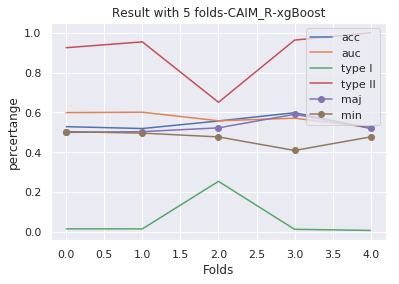

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_continuousData_dataframe][X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]

[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

1_NOTALL
2_NOTALL[X_y_train_disData_dataframe]

[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
3_NOTALL1_NOTALL

4_NOTALL
2_NOTALL
5_NOTALL
3_NOTALL
6_NOTALL
4_NOTALL
7_NOTALL5_NOTALL

8_NOTALL
9_NOTALL
10_NOTALL6_NOTALL

7_NOTALL
11_NOTALL
8_NOTALL12_NOTALL

13_NOTALL
9_NOTALL14_NOTALL

15_NOTALL
10_NOTALL
11_NOTALLX_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe

12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin


X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------MDLP_R -----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_ALL
1_NOTALL
2_NOTALL
-------------------------------NEXT ROUND-----------------------------3_NOTALL

Mean Accuracy: 0.5912492853058892
Mean Accuracy[0.5509433962264151, 0.6098484848484849, 0.5833333333333334, 0.6098484848484849, 0.6022727272727273]
Mean Auc: 0.9099849786380748
Mean Auc[0.8856922901459854, 0.903155353755963, 0.9173842686239381, 0.9295726102941176, 0.9141203703703703]
Mean TypeII: 0.8516820269625388
Mean TypeII[0.8984375, 0.7795275590551181, 0.9090909090909091, 0.8046875, 0.8666666666666667]
4_NOTALLMean TypeI: 0.01306772100567721
Mean Typ

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

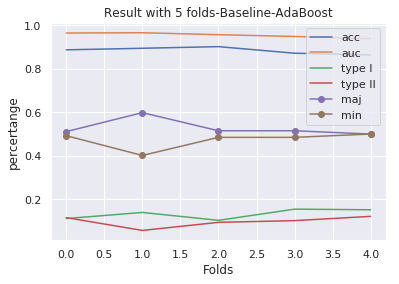

-------------------------------NEXT ROUND-----------------------------
Mean : [0.8834191  0.95442591 0.13184394 0.0977026 ]
[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
[X_y_train_continuousData_dataframe]
-------------------------------MDLP_R -----------------------------
1_NOTALL
2_NOTALL
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]3_NOTALL

[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]4_NOTALL

X_test_continuousData_dataframe
0_ALL
5_NOTALL
1_NOTALL
6_NOTALL
2_NOTALL
7_NOTALL
8_NOTALL
3_NOTALL
4_NOTALL
9_NOTALL5_NOTALL

6_NOTALL10_NOTALL

11_NOTALL
7_NOTALL
12_NOTALL
8_NOTALL
13_NOTALL9_NOTALL

14_NOTALL
15_NOTALL
10_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
11_NOTALL
12_NOTALL
13_ALL
14_NOTALL
15_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


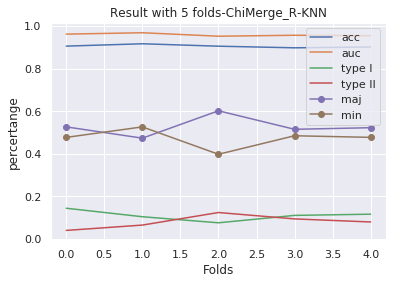

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------
4_NOTALL
5_NOTALL
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
6_NOTALL
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL7_NOTALL

2_NOTALL8_NOTALL

3_NOTALL
9_NOTALL
4_NOTALL10_NOTALL

5_NOTALL11_NOTALL

6_NOTALL
12_NOTALL
7_NOTALL
13_NOTALL
8_NOTALL
14_NOTALL
9_NOTALL
10_NOTALL
15_NOTALL
11_NOTALL
12_NOTALLX_test_disData_dataframe
X_test_categorialData_dataframe



C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

Discretize_X_test_dataframe13_NOTALL

14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


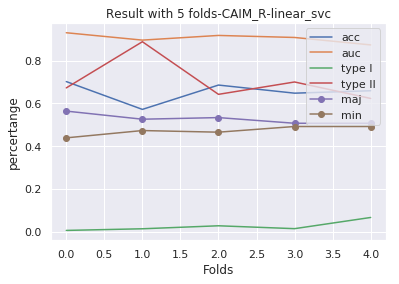

15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_y_train_disData_dataframe][X_train_categorialData_dataframe]

[X_train_disData_dataframe]
[X_train_categorialData_dataframe][Discretize_X_train_dataframe]

[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALLX_test_continuousData_dataframe
0_NOTALL

1_NOTALL2_NOTALL

3_NOTALL2_NOTALL

3_NOTALL4_NOTALL

5_NOTALL4_NOTALL

6_NOTALL
5_NOTALL
7_NOTALL
8_NOTALL
6_NOTALL
9_NOTALL
7_NOTALL
10_NOTALL
11_NOTALL
8_NOTALL
9_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
10_NOTALL
Discretize_X_test_dataframe
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL-------------------------------NEXT ROUND-----------------------------

[X_y_train_continuousData_dataframe]4_NOTALL



C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

-------------------------------MDLP_R -----------------------------
5_NOTALL
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_ALL
1_NOTALL
2_NOTALL6_NOTALL

7_NOTALL3_NOTALL

4_NOTALL
5_NOTALL
8_NOTALL
6_NOTALL
7_NOTALL9_NOTALL

10_NOTALL8_NOTALL

9_NOTALL11_NOTALL

12_NOTALL
13_NOTALL10_NOTALL

14_NOTALL
11_NOTALL15_NOTALL

12_NOTALLX_test_disData_dataframe

X_test_categorialData_dataframe
13_NOTALL
14_NOTALLDiscretize_X_test_dataframe

15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font fami

-------------------------------NEXT ROUND-----------------------------
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]1_NOTALL
[X_train_categorialData_dataframe]



C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


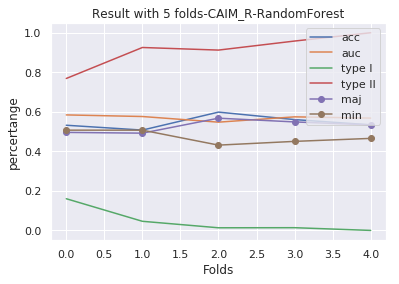

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
2_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
3_NOTALL
[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------
4_NOTALL
4_NOTALL5_NOTALL



C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

6_NOTALL
5_NOTALL
7_NOTALL
[X_y_train_disData_dataframe]
8_NOTALL
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
6_NOTALL
X_test_continuousData_dataframe
0_NOTALL
9_NOTALL
1_NOTALL
7_NOTALL
2_NOTALL
8_NOTALL
10_NOTALL
9_NOTALL3_NOTALL11_NOTALL

4_NOTALL12_NOTALL


10_NOTALL13_NOTALL5_NOTALL


6_NOTALL
14_NOTALL11_NOTALL
15_NOTALL

7_NOTALL
8_NOTALL
9_NOTALL12_NOTALLX_test_disData_dataframe


X_test_categorialData_dataframe13_NOTALL

10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL-------------------------------NEXT ROUND-----------------------------

14_NOTALL14_NOTALLDiscretize_X_test_dataframe

15_NOTALL

15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
[X_y_train_continuousData_dataframe]X_test_disData_dataframe
Discretize_X_test_dataframe-------------------------------ChiMerge_R -----------------------------




C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


X_test_categorialData_dataframe
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
Discretize_X_test_dataframe
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
Mean Accuracy: 0.5465237278444826
Mean Accuracy[0.5886792452830188, 0.5568181818181818, 0.49242424242424243, 0.5795454545454546, 0.5151515151515151]
Mean Auc: 0.5958044880511298
Mean Auc[0.7647428571428572, 0.5941294964028777, 0.5122021246052253, 0.4543291823308271, 0.6536187797738621]
Mean TypeII: 0.9113781255464242
Mean TypeII[0.832, 0.848, 0.9534883720930233, 0.9910714285714286, 0.9323308270676691]
Mean TypeI: 0.045373361797657476
Mean TypeI[0.03571428571428571, 0.07913669064748201, 0.08148148148148149, 0.0, 0.030534351145038167]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning

-------------------------------NEXT ROUND-----------------------------
Mean Accuracy: 0.9053573470554603
Mean Accuracy[0.9283018867924528, 0.9128787878787878, 0.9015151515151515, 0.8787878787878788, 0.9053030303030303]
Mean Auc: 0.976123413096062
Mean Auc[0.981811942347289, 0.9828883146712605, 0.976978417266187, 0.9713242654419125, 0.9676141257536606]
Mean TypeII: 0.07945664163788695
Mean TypeII[0.07258064516129033, 0.07751937984496124, 0.064, 0.07207207207207207, 0.1111111111111111]
Mean TypeI: 0.10621936198651949
Mean TypeI[0.07092198581560284, 0.0962962962962963, 0.12949640287769784, 0.1568627450980392, 0.07751937984496124]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

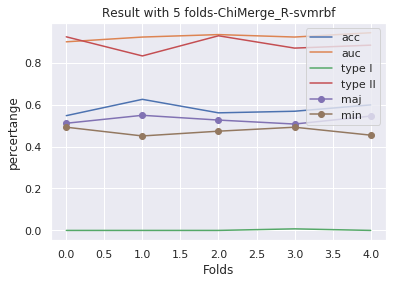

[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packa

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL-------------------------------NEXT ROUND-----------------------------

10_NOTALL
11_NOTALL
12_NOTALL
[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------
13_NOTALL[X_y_train_disData_dataframe]

[X_train_disData_dataframe]14_NOTALL
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]

X_test_continuousData_dataframe
0_NOTALL
15_NOTALL
1_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
2_NOTALL
3_NOTALL
Discretize_X_test_dataframe4_NOTALL

5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
-------------------------------NEXT ROUND-----------------------------
13_NOTALL
-------------------------------NEXT ROUND-----------------------------
14_NOTALL
[X_y_train_continuousData_dataframe][X_y_train_continuousData_dataframe]
-------------------------------MDLP_R -----------------------------
15_NOTALL



C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


-------------------------------ChiMerge_R -----------------------------
X_test_disData_dataframe[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL

X_test_categorialData_dataframe
2_NOTALL
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
3_NOTALL
X_test_continuousData_dataframe
0_ALL
1_NOTALL4_NOTALL

Discretize_X_test_dataframe
2_NOTALL5_NOTALL

3_NOTALL6_NOTALL

4_NOTALL
5_NOTALL-------------------------------NEXT ROUND-----------------------------

7_NOTALL
6_NOTALL
[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

7_NOTALL
8_NOTALL
8_NOTALL
9_NOTALL
[X_y_train_disData_dataframe]
9_NOTALL10_NOTALL

[X_train_disData_dataframe]
[X_train_categorialData_dataframe]10_NOTALL

11_NOTALL
[Discretize_X_train_dataframe]
11_NOTALLX_test_continuousData_dataframe
0_NOTALL
1_NOTALL

2_NOTALL
12_NOTALL
3_NOTALL
13_ALL
12_NOTALL
4_NOTALL
14_NOTALL
13_NOTALL5_NOTALL
15_NOTALL

6_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
7_NOTALL14_NOTALL

8_NOTALL
15_NOTALL
Discretize_X_test_dataframe
9_NOTALLX_test_disData_dataframe

X_test_categorialData_dataframe
10_NOTALL
Discretize_X_test_dataframe
11_NOTALL
12_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_

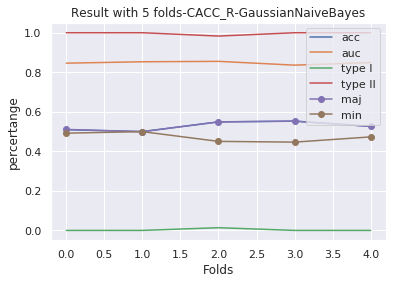

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), se

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[X_y_train_disData_dataframe][Discretize_X_train_dataframe]

[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframeX_test_continuousData_dataframe
0_NOTALL

0_NOTALL
1_NOTALL1_NOTALL

2_NOTALL2_NOTALL

3_NOTALL
3_NOTALL
4_NOTALL
4_NOTALL5_NOTALL

6_NOTALL
5_NOTALL
7_NOTALL
6_NOTALL
8_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
9_NOTALL
11_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
12_NOTALL14_NOTALL

15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. Da

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------
X_test_continuousData_dataframe
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
0_NOTALL
1_NOTALL
[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------
2_NOTALL
1_NOTALL
-------------------------------NEXT ROUND-----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
Mean Accuracy: 0.8788507718696398
Mean Accuracy[0.9169811320754717, 0.8636363636363636, 0.9053030303030303, 0.84469696

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
-------------------------------NEXT ROUND-----------------------------
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

Discretize_X_test_dataframe
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


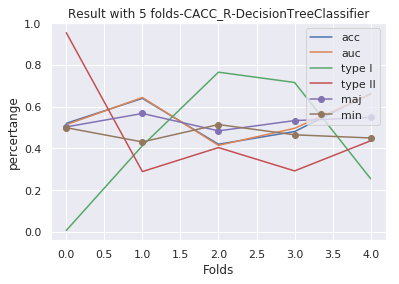


12_NOTALL
13_NOTALL
-------------------------------NEXT ROUND-----------------------------
14_NOTALL
15_NOTALL
[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------
X_test_disData_dataframe
X_test_categorialData_dataframe
[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled featur

[X_y_train_disData_dataframe]Discretize_X_test_dataframe

[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[X_y_train_disData_dataframe][Discretize_X_train_dataframe]

[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
X_test_continuousData_dataframe
0_NOTALL
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
1_NOTALL
2_NOTALL
2_NOTALL
3_NOTALL
3_NOTALL
4_NOTALL
4_NOTALL
5_NOTALL
5_NOTALL
6_NOTALL
6_NOTALL
7_NOTALL7_NOTALL

8_NOTALL8_NOTALL

9_NOTALL
9_NOTALL
10_NOTALL
10_NOTALL
11_NOTALL
11_NOTALL
12_NOTALL

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font fami


12_NOTALL
13_NOTALL
14_NOTALL
13_NOTALL
-------------------------------NEXT ROUND-----------------------------14_NOTALL

Mean Accuracy: 0.5465494568324758
Mean Accuracy[0.5547169811320755, 0.5643939393939394, 0.5340909090909091, 0.5492424242424242, 0.5303030303030303]
Mean Auc: 0.8170875637917281
Mean Auc[0.900721401580213, 0.8528053567305471, 0.6139652885890561, 0.8713522518382353, 0.8465935202205883]
Mean TypeII: 0.9584426646008264
Mean TypeII[0.959349593495935, 0.9344262295081968, 1.0, 0.9296875, 0.96875]
Mean TypeI: 0.0014084507042253522
Mean TypeI[0.0, 0.007042253521126761, 0.0, 0.0, 0.0]
15_NOTALL
15_NOTALL
X_test_disData_dataframeX_test_disData_dataframe
X_test_categorialData_dataframe

X_test_categorialData_dataframe
Discretize_X_test_dataframeDiscretize_X_test_dataframe



C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------
[X_y_train_disData_dataframe]-------------------------------NEXT ROUND-----------------------------

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL

-------------------------------NEXT ROUND-----------------------------
1_NOTALL[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------



C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key

1_NOTALL2_NOTALL

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
3_NOTALL
4_NOTALL
1_NOTALL
X_test_continuousData_dataframe
0_NOTALL
5_NOTALL
2_NOTALL1_NOTALL

2_NOTALL
3_NOTALL
2_NOTALL
4_NOTALL6_NOTALL
3_NOTALL
3_NOTALL

4_NOTALL5_NOTALL

7_NOTALL
5_NOTALL
4_NOTALL8_NOTALL6_NOTALL6_NOTALL



7_NOTALL7_NOTALL

8_NOTALL8_NOTALL5_NOTALL
9_NOTALL


9_NOTALL
10_NOTALL
11_NOTALL10_NOTALL

9_NOTALL
11_NOTALL6_NOTALL
10_NOTALL

12_NOTALL
11_NOTALL7_NOTALL
13_NOTALL
12_NOTALL

14_NOTALL
8_NOTALL
12_NOTALL15_NOTALL

13_NOTALL
13_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
14_NOTALL
14_NOTALL
9_NOTALL
15_NOTALL
10_NOTALL
Discretiz

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

Discretize_X_test_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
12_NOTALL

13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------
-------------------------------NEXT ROUND-----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[X_y_train_continuousData_dataframe]3_NOTALL

-------------------------------Chi2_R -----------------------------4_NOTALL

5_NOTALL


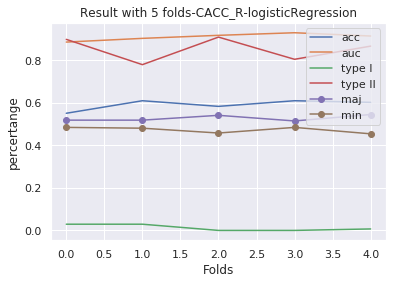

6_NOTALL
[X_y_train_disData_dataframe][X_y_train_continuousData_dataframe]7_NOTALL

-------------------------------Chi2_R -----------------------------
[X_train_disData_dataframe]

[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


X_test_continuousData_dataframe
0_NOTALL
8_NOTALL
1_NOTALL
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
9_NOTALL
2_NOTALL
10_NOTALL
3_NOTALL
11_NOTALL
2_NOTALL
12_NOTALL4_NOTALL

3_NOTALL
4_NOTALL5_NOTALL

6_NOTALL
5_NOTALL
7_NOTALL
13_NOTALL
14_NOTALL6_NOTALL

7_NOTALL
8_NOTALL
9_NOTALL15_NOTALL

8_NOTALL10_NOTALL

11_NOTALLX_test_disData_dataframe
X_test_categorialData_dataframe

9_NOTALL
Discretize_X_test_dataframe
12_NOTALL
10_NOTALL
13_NOTALL
14_NOTALL
11_NOTALL
15_NOTALL
12_NOTALL
13_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
14_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Discretize_X_test_dataframe
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
-------------------------------NEXT ROUND-----------------------------
Mean Accuracy: 0.844802744425386
Mean Accuracy[0.8603773584905661, 0.821969696969697, 0.8409090909090909, 0.8295454545454546, 0.8712121212121212]6_NOTALL

Mean Auc: 0.8988413253517178
Mean Auc[0.9035718361291796, 0.8714343109682603, 0.9076304041353384, 0.9005795421616922, 0.9109905333641191]
Mean TypeII: 0.15462030537540444
Mean TypeII[0.13768115942028986, 0.15037593984962405, 0.16964285714285715, 0.15966386554621848, 0.1557377049180328]
7_NOTALL
8_NOTALL
Mean TypeI: 0.15681981816234927
Mean TypeI[0.14173228346456693, 0.20610687022900764, 0.1513157894736842, 0.1793103448275862, 0.1056338028169014]
-------------------------------NEXT ROUND-----------------------------
9_NOTALL
10_NOTALL
11_NOTALL
[X_y_train_con

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packa

12_NOTALL
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]13_NOTALL

14_NOTALL
[X_train_categorialData_dataframe]-------------------------------NEXT ROUND-----------------------------

[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
15_NOTALL2_NOTALL

[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


3_NOTALL
4_NOTALL
[X_y_train_disData_dataframe]5_NOTALL

[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
6_NOTALL[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL

7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
2_NOTALL
11_NOTALL
3_NOTALL
12_NOTALL
4_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
5_NOTALL
X_test_disData_dataframe6_NOTALL

X_test_categorialData_dataframe
7_NOTALL

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-pac

-------------------------------NEXT ROUND-----------------------------

8_NOTALL
9_NOTALLDiscretize_X_test_dataframe
[X_y_train_continuousData_dataframe]

10_NOTALL-------------------------------Chi2_R -----------------------------



C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


11_NOTALL
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]12_NOTALL
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]

X_test_continuousData_dataframe
0_NOTALL
1_NOTALL13_NOTALL

14_NOTALL
2_NOTALL
15_NOTALL
3_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
4_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

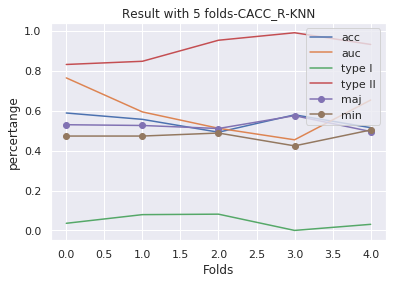

Discretize_X_test_dataframe
5_NOTALL
6_NOTALL
[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------7_NOTALL

8_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe9_NOTALL
0_NOTALL

10_NOTALL1_NOTALL

2_NOTALL11_NOTALL

12_NOTALL3_NOTALL

13_NOTALL
4_NOTALL
14_NOTALL
5_NOTALL
15_NOTALL
6_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe7_NOTALL

8_NOTALL
-------------------------------NEXT ROUND-----------------------------
Mean Accuracy: 0.6881818181818182
Mean Accuracy[0.6, 0.5643939393939394, 0.6477272727272727, 0.8560606060606061, 0.7727272727272727]
Mean Auc: 0.6748374411391963
Mean Auc[0.5776109136764873, 0.570321469575201, 0.6069248212105355, 0.8507178688808165, 0.7686121323529412]
Mean TypeII: 0.5745560167468923
Mean TypeII[0.7049180327868853, 0.8208955223880597, 0.7521367521367521, 0.22764227642276422, 0.3671875]
Mean TypeI: 0.07576910097471515
Mean TypeI[0.13986013986013987, 0.038461538461538464, 0.034013605442176874, 0.07092198581560284, 0.0

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font fa

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
-------------------------------NEXT ROUND-----------------------------
Discretize_X_test_dataframe
[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
-------------------------------NEXT ROUND-----------------------------
-------------------------------NEXT ROUND-----------------------------
10_NOTALL
11_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

12_NOTALL
13_NOTALL
[X_y_train_continuousData_dataframe]
[X_y_train_continuousData_dataframe]
-------------------------------MDLP_R -----------------------------
14_NOTALL-------------------------------Chi2_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe

0_NOTALL
[X_y_train_disData_dataframe]1_NOTALL15_NOTALL


[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_ALL
1_NOTALLX_test_disData_dataframe
X_test_categorialData_dataframe

2_NOTALL
2_NOTALL
-------------------------------NEXT ROUND-----------------------------
Mean Accuracy: 0.9106575185820468
Mean Accuracy[0.9320754716981132, 0.8825757575757576, 0.8939393939393939, 0.9090909090909091, 0.9356060606060606]
Mean Auc: 0.9679855438442638
Mean Auc[0.9872958775836473, 0.957375919117647, 0.9621865654474351, 0.9503436626281454, 0.9827256944444445]
Mean TypeII: 0.10278437811906371
Mean TypeII[0.09523809523809523, 0.15441176470588236, 0.1111111111111111, 0.09482758620689655, 0.058333333333333334]
Mean TypeI: 0.07600440505410008
Mean TypeI[0.04316546762589928,

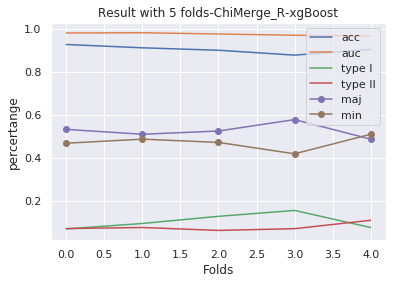

5_NOTALL
4_NOTALL
6_NOTALL
7_NOTALL5_NOTALL

[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


6_NOTALL[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
8_NOTALL

1_NOTALL
7_NOTALL9_NOTALL
2_NOTALL

8_NOTALL
3_NOTALL
10_NOTALL9_NOTALL

4_NOTALL
11_NOTALL
5_NOTALL
12_NOTALL
10_NOTALL6_NOTALL

13_NOTALL7_NOTALL

14_NOTALL
15_NOTALL
11_NOTALL8_NOTALL

X_test_disData_dataframe
X_test_categorialData_dataframe
12_NOTALL9_NOTALL

10_NOTALL
13_NOTALL
11_NOTALL
14_NOTALL12_NOTALL

13_NOTALL
14_NOTALL15_NOTALL

X_test_disData_dataframe15_NOTALL

Discretize_X_test_dataframe
X_test_categorialData_dataframe
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframeDiscretize_X_test_dataframe

-------------------------------NEXT ROUND-----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-pac

[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
-------------------------------NEXT ROUND-----------------------------
Mean Accuracy: 0.8432818753573471
Mean Accuracy[0.8679245283018868, 0.8143939393939394, 0.8636363636363636, 0.8598484848484849, 0.8106060606060606]
Mean Auc: 0.9012119731364898
Mean Auc[0.9024154038965478, 0.8790832758224063, 0.9200877192982456, 0.9113186876549616, 0.893154779010288]
Mean TypeII: 0.1714336172121186
Mean TypeII[0.1417910447761194, 0.1984126984126984, 0.16666666666666666, 0.12195121951219512, 0.2283464566929134]
Mean TypeI: 0.14373936434378398
Mean TypeI[0.12213740458015267, 0.17391304347826086, 0.11333333333333333, 0.15602836879432624, 0.15328467153284672]

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL-------------------------------NEXT ROUND-----------------------------

4_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


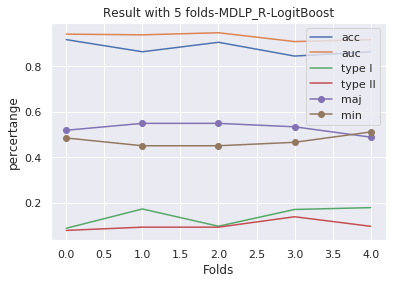

5_NOTALL
6_NOTALL
[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------
7_NOTALL[X_y_train_continuousData_dataframe]
8_NOTALL

-------------------------------CAIM_R -----------------------------[X_y_train_disData_dataframe]

[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


1_NOTALL

0_NOTALL
9_NOTALL
2_NOTALL
1_NOTALL3_NOTALL
10_NOTALL

4_NOTALL
11_NOTALL
5_NOTALL
2_NOTALL
3_NOTALL12_NOTALL6_NOTALL


4_NOTALL
7_NOTALL
5_NOTALL8_NOTALL13_NOTALL


14_NOTALL9_NOTALL

6_NOTALL
10_NOTALL
7_NOTALL
11_NOTALL
8_NOTALL
15_NOTALL
X_test_disData_dataframe9_NOTALL

12_NOTALLX_test_categorialData_dataframe

Discretize_X_test_dataframe
10_NOTALL
13_NOTALL
11_NOTALL
12_NOTALL
14_NOTALL13_NOTALL

14_NOTALL15_NOTALL

X_test_disData_dataframe
X_test_categorialData_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

15_NOTALL
X_test_disData_dataframeDiscretize_X_test_dataframe

X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin


9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
Mean Accuracy: 0.8349685534591196
Mean Accuracy[0.8415094339622642, 0.8181818181818182, 0.8446969696969697, 0.8598484848484849, 0.8106060606060606]
Mean Auc: 0.8635617462721837
Mean Auc[0.8832646991535118, 0.8406258972150445, 0.8700215128786558, 0.8931359044995408, 0.8307607176141658]
Mean TypeII: 0.19384439644728854
Mean TypeII[0.16129032258064516, 0.23703703703703705, 0.23076923076923078, 0.1590909090909091, 0.1810344827586207]
Mean TypeI: 0.13849110778848533
Mean TypeI[0.15602836879432624, 0.12403100775193798, 0.09523809523809523, 0.12121212121212122, 0.19594594594594594]
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

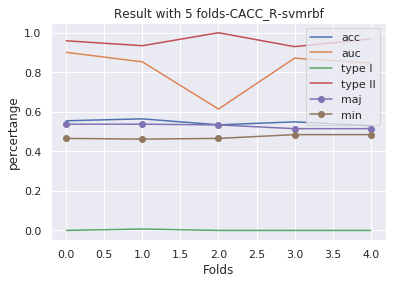

2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------
8_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
9_NOTALL
10_NOTALL
1_NOTALL
11_NOTALL
2_NOTALL
12_NOTALL
3_NOTALL13_NOTALL

14_NOTALL4_NOTALL

15_NOTALL
5_NOTALL
6_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL-------------------------------NEXT ROUND-----------------------------

[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
3_NOTALL
4_NOTALL
2_NOTALL
5_NOTALL
3_NOTALL
6_NOTALL4_NOTALL

5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
7_NOTALL
8_NOTALL9_NOTALL



C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

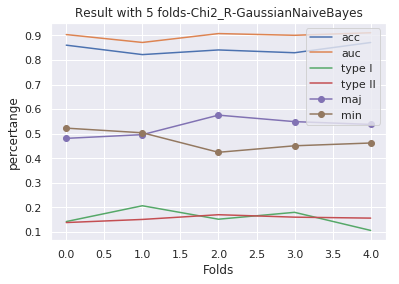

9_NOTALL
10_NOTALL10_NOTALL

11_NOTALL11_NOTALL

12_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
15_NOTALLDiscretize_X_test_dataframe

X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\User

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]-------------------------------NEXT ROUND-----------------------------

[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
[X_y_train_continuousData_dataframe]
3_NOTALL
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


4_NOTALL
5_NOTALL
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]6_NOTALL

X_test_continuousData_dataframe
7_NOTALL0_NOTALL

1_NOTALL8_NOTALL

9_NOTALL
10_NOTALL
2_NOTALL
11_NOTALL
3_NOTALL
12_NOTALL
4_NOTALL
13_NOTALL
5_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

14_NOTALL
6_NOTALL
15_NOTALL
7_NOTALL
X_test_disData_dataframe8_NOTALL
X_test_categorialData_dataframe

9_NOTALL
10_NOTALL
11_NOTALL
Discretize_X_test_dataframe
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe-------------------------------NEXT ROUND-----------------------------

[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

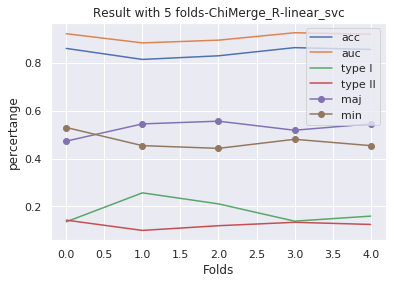

[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
-------------------------------NEXT ROUND-----------------------------
5_NOTALL
6_NOTALL
7_NOTALL
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  

-------------------------------Chi2_R -----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
8_NOTALL
9_NOTALL
1_NOTALL
10_NOTALL[X_y_train_continuousData_dataframe]
2_NOTALL

11_NOTALL
-------------------------------MDLP_R -----------------------------
12_NOTALL3_NOTALL

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_ALL
1_NOTALL
2_NOTALL4_NOTALL

3_NOTALL
13_NOTALL
4_NOTALL
5_NOTALL14_NOTALL

15_NOTALL5_NOTALL

6_NOTALL
6_NOTALLX_test_disData_dataframe
7_NOTALL

X_test_categorialData_dataframe
-------------------------------NEXT ROUND-----------------------------8_NOTALL

Mean Accuracy: 0.5375385934819896
Mean Accuracy[0.4490566037735849, 0.4431818181818182, 0.625, 0.5606060606060606, 0.6098484848484849]
Mean Auc: 0.583446801058467
Mean 

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base

12_NOTALL
8_NOTALL13_NOTALL

14_NOTALL
15_NOTALL
9_NOTALL
10_NOTALLX_test_disData_dataframe
X_test_categorialData_dataframe

11_NOTALL
Discretize_X_test_dataframe
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------

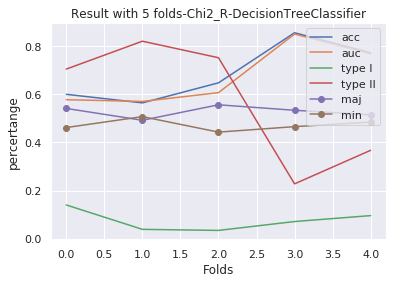


[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
-------------------------------NEXT ROUND-----------------------------
8_NOTALL
9_NOTALL[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------

10_NOTALL
11_NOTALL[X_y_train_disData_dataframe]

[X_train_disData_dataframe]12_NOTALL

[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
13_NOTALL
14_NOTALL
3_NOTALL
15_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
X_test_disData_dataframe7_NOTALL
X_test_categorialData_dataframe

8_NOTALL
9_NOTALL
10_NOTALLDiscretize_X_test_dataframe

11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
Mean Accuracy: 0.5276300743281875
Mean Accuracy[0.5283018867924528, 0.48484848484848486, 0.5643939393939394, 0.5454545454545454, 0.5151515151515151]
Mean Auc: 0.5230807771934276
Mean Auc[0.5285714285714286, 0.53515625, 0.5234899328859061, 0.5208333333333333, 0.5073529411764706]
Mean TypeII: 1.0
Mean TypeII[1.0, 1.0, 1.0, 1.0, 1.0]
Mean TypeI: 0.0
Mean TypeI[0.0, 0.0, 0.0, 0.0, 0.0]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

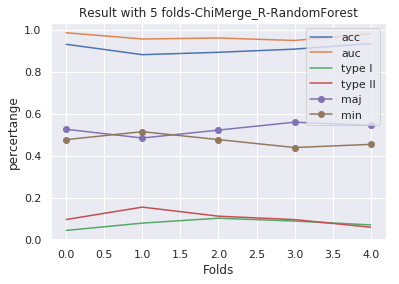

[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin


-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


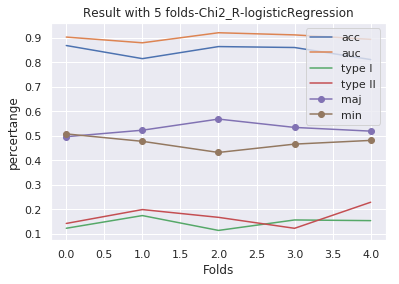

-------------------------------NEXT ROUND-----------------------------
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

[X_y_train_disData_dataframe]
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe[X_train_disData_dataframe]
0_NOTALL

[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
1_NOTALLX_test_continuousData_dataframe

0_NOTALL
2_NOTALL1_NOTALL

3_NOTALL2_NOTALL
4_NOTALL
5_NOTALL

6_NOTALL
3_NOTALL
7_NOTALL
8_NOTALL4_NOTALL

5_NOTALL9_NOTALL

10_NOTALL
6_NOTALL
11_NOTALL
7_NOTALL
8_NOTALL12_NOTALL

13_NOTALL
9_NOTALL
10_NOTALL14_NOTALL

15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
11_NOTALLDiscretize_X_test_dataframe

12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

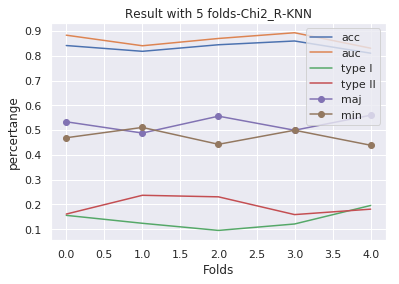

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
-------------------------------NEXT ROUND-----------------------------10_NOTALL

11_NOTALL
12_NOTALL
13_NOTALL
[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

14_NOTALL
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
15_NOTALL1_NOTALL

2_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: Fut

15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
Compare Result-Bankruptcy-GaussianNaiveBayes
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_ALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_ALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
Mean Accuracy: 0.5586563750714694
Mean Accuracy[0.5735849056603773, 0.5568181818181818, 0.5113636363636364, 0.6098484848484849, 0.5416666666666666]
Mean Auc: 0.8918453841809612
Mean Auc[0.8883087983567272, 0.9277303163241746, 0.8710686409550047, 0.8935087719298245, 0.8786103933390754]
Mean TypeII: 0.9272295471354008
Mean TypeII[0.8818897637795275, 0.9508196721311475, 0.9696969696969697, 0.9035087719298246, 0.9302325581395349]
Mean TypeI: 0.00585435906317719
Mean TypeI[0.007246376811594203, 0.007042253521126761, 0.007575757575757576, 0.0, 0.007407407407407408]
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))



-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

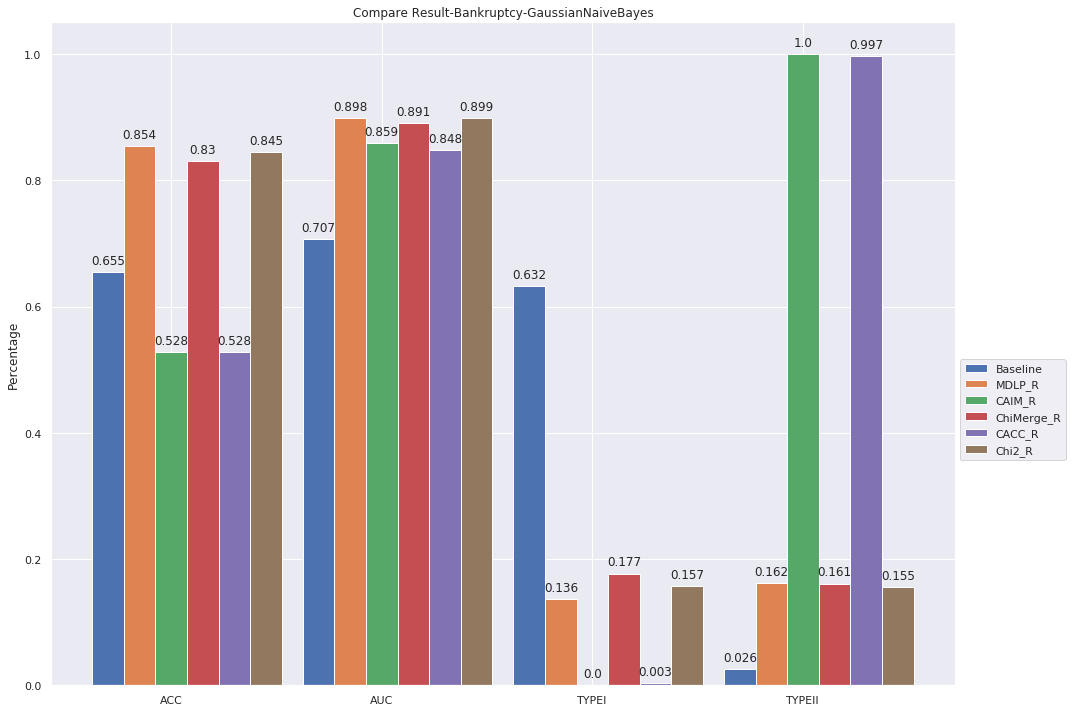

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
Mean Accuracy: 0.5904431103487707
Mean Accuracy[0.6150943396226415, 0.49242424242424243, 0.6212121212121212, 0.5303030303030303, 0.6931818181818182]
Mean Auc: 0.6282640111682511
Mean Auc[0.7128857142857143, 0.481378240128743, 0.5954636807349986, 0.5950368069933286, 0.756555613698471]
Mean TypeII: 0.6169529549414552
Mean TypeII[0.584, 0.6692913385826772, 0.4883720930232558, 0.9841269841269841, 0.358974358974359]
Mean TypeI: 0.22083745744851066
Mean TypeI[0.20714285714285716, 0.35766423357664234, 0.2740740740740741, 0.0, 0.2653061224489796]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

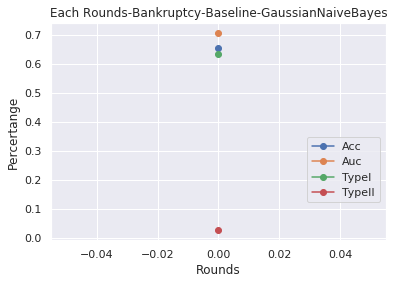

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
Mean Accuracy: 0.8743310463121784
Mean Accuracy[0.8830188679245283, 0.8712121212121212, 0.8787878787878788, 0.875, 0.8636363636363636]
Mean Auc: 0.9371344926277327
Mean Auc[0.947894550601557, 0.952782754435647, 0.9150215827338128, 0.9453125, 0.924661075367647]
Mean TypeII: 0.10809609233359233
Mean TypeII[0.06481481481481481, 0.14685314685314685, 0.096, 0.1, 0.1328125]
Mean TypeI: 0.13794567326794951
Mean TypeI[0.15286624203821655, 0.10743801652892562, 0.14388489208633093, 0.14583333333333334, 0.13970588235294118]


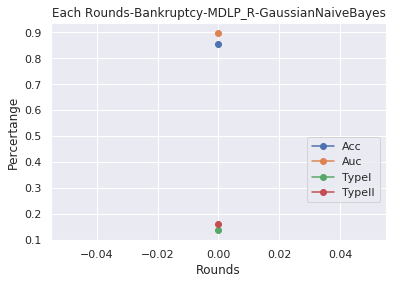

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


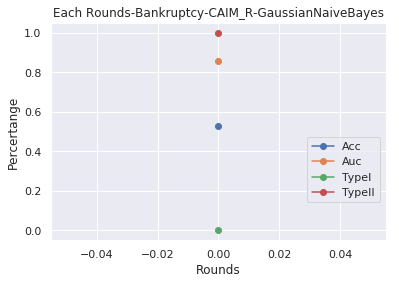

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

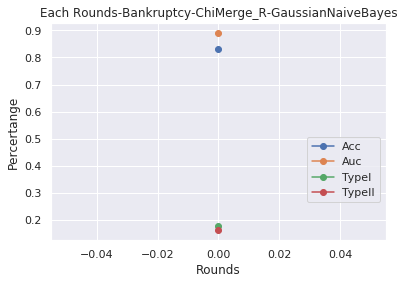

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


-------------------------------NEXT ROUND-----------------------------
Mean Accuracy: 0.548093196112064
Mean Accuracy[0.5169811320754717, 0.5492424242424242, 0.5643939393939394, 0.5643939393939394, 0.5454545454545454]
Mean Auc: 0.5679879301702339
Mean Auc[0.5366867950324712, 0.5729639634461751, 0.5731419016317822, 0.5839120370370369, 0.5732349537037037]
Mean TypeII: 0.9476263105444547
Mean TypeII[0.9402985074626866, 0.9291338582677166, 0.9186991869918699, 0.95, 1.0]
Mean TypeI: 0.008739057450615359
Mean TypeI[0.015267175572519083, 0.0072992700729927005, 0.014184397163120567, 0.006944444444444444, 0.0]


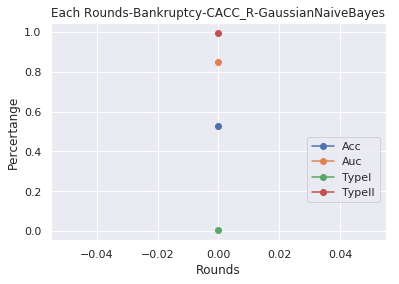

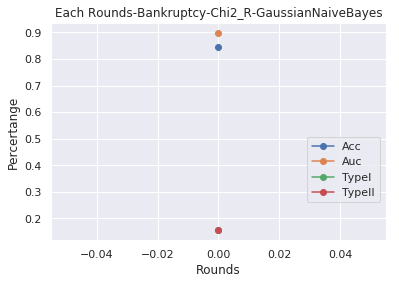

            Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline        0.65 0.71   0.63    0.03          1.67
MDLP_R          0.85 0.90   0.14    0.16        185.91
CAIM_R          0.53 0.86   0.00    1.00        255.66
ChiMerge_R      0.83 0.89   0.18    0.16       6195.13
CACC_R          0.53 0.85   0.00    1.00       3807.46
Chi2_R          0.84 0.90   0.16    0.15       7579.57


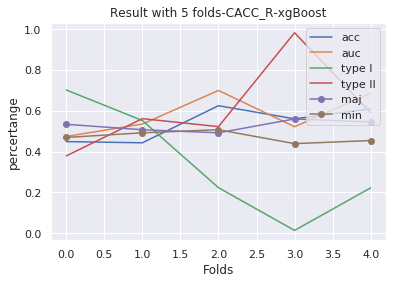

[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
Compare Result-Bankruptcy-DecisionTreeClassifier


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL

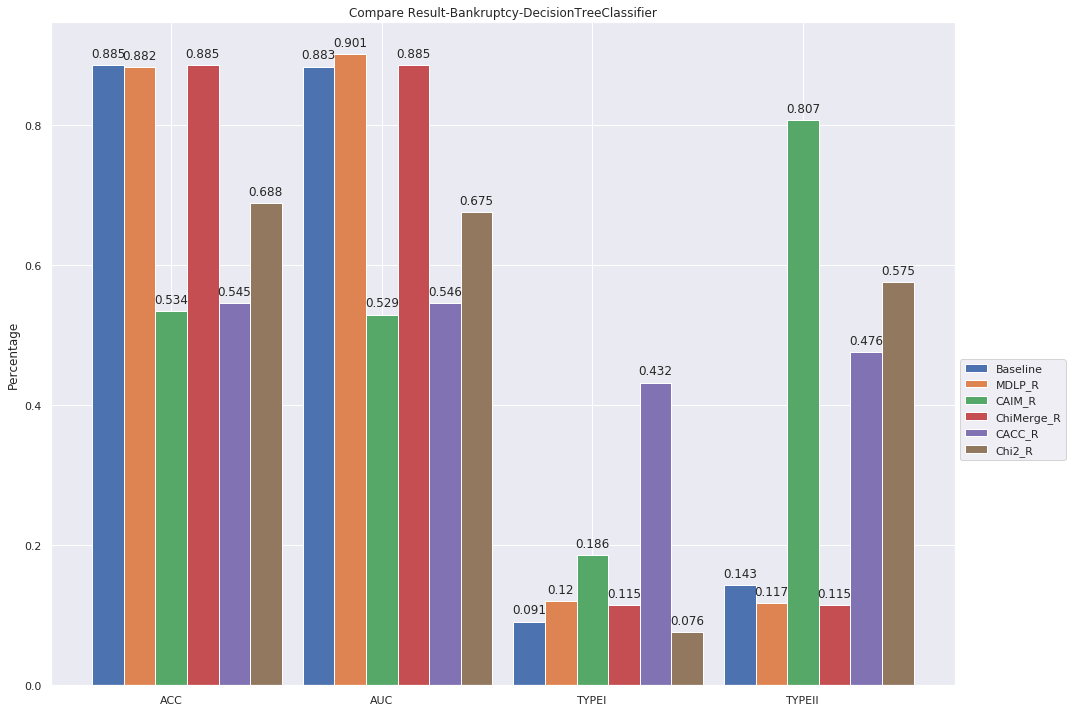


11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


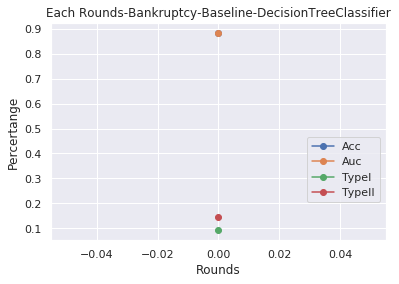

2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


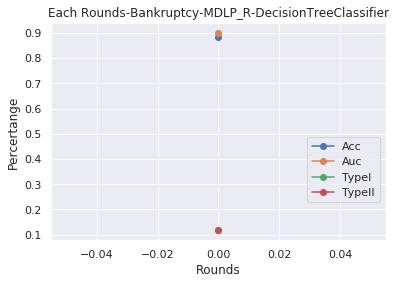

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


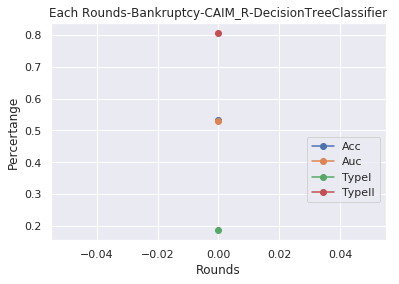

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


-------------------------------NEXT ROUND-----------------------------
Mean Accuracy: 0.8523699256718125
Mean Accuracy[0.8716981132075472, 0.8409090909090909, 0.8333333333333334, 0.875, 0.8409090909090909]
Mean Auc: 0.9177037157133187
Mean Auc[0.9257986946066643, 0.9356452726017943, 0.9040351183208326, 0.934827526832348, 0.8882119662049545]
Mean TypeII: 0.19179457006955808
Mean TypeII[0.13821138211382114, 0.2222222222222222, 0.2564102564102564, 0.13740458015267176, 0.2047244094488189]
Mean TypeI: 0.10919519130293405
Mean TypeI[0.11971830985915492, 0.10144927536231885, 0.09523809523809523, 0.11278195488721804, 0.11678832116788321]


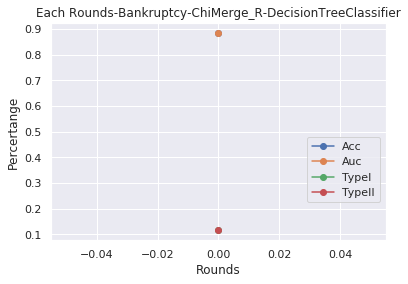

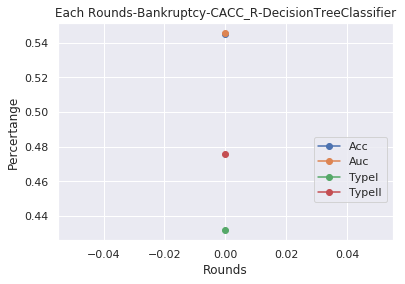

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Mean Accuracy: 0.8327301315037164
Mean Accuracy[0.7962264150943397, 0.875, 0.7992424242424242, 0.8333333333333334, 0.8598484848484849]
Mean Auc: 0.8980450233455587
Mean Auc[0.8940229885057471, 0.9294002757352942, 0.8699763593380615, 0.8677662037037037, 0.9290592894449865]
Mean TypeII: 0.21010668821443854
Mean TypeII[0.30833333333333335, 0.0859375, 0.2682926829268293, 0.2, 0.18796992481203006]
Mean TypeI: 0.13026839982958138
Mean TypeI[0.11724137931034483, 0.16176470588235295, 0.14184397163120568, 0.1388888888888889, 0.0916030534351145]


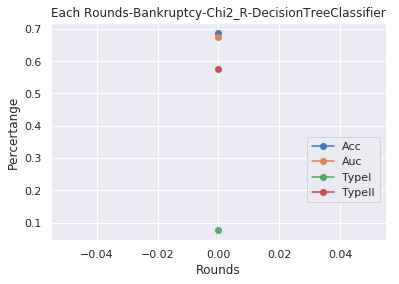

            Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline        0.88 0.88   0.09    0.14         23.50
MDLP_R          0.88 0.90   0.12    0.12        248.65
CAIM_R          0.53 0.53   0.19    0.81       1570.57
ChiMerge_R      0.88 0.88   0.11    0.12       5382.31
CACC_R          0.55 0.55   0.43    0.48       4352.07
Chi2_R          0.69 0.67   0.08    0.57       7032.35


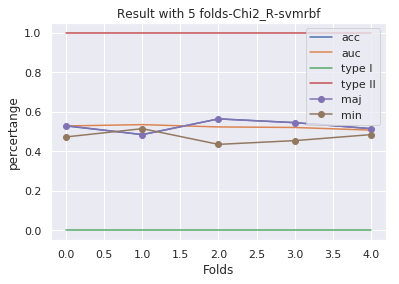

Compare Result-Bankruptcy-logisticRegression


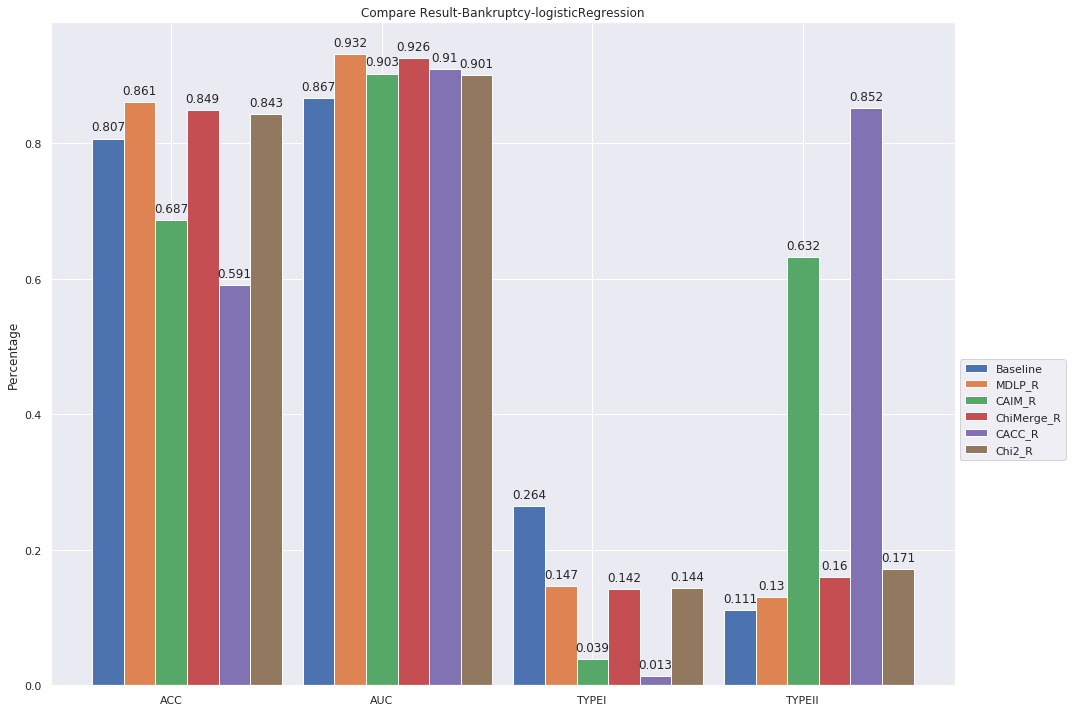

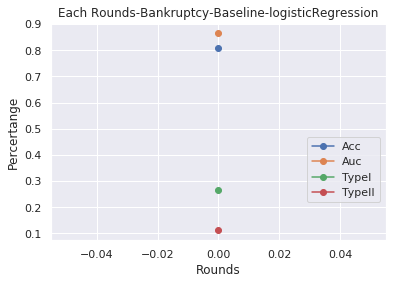

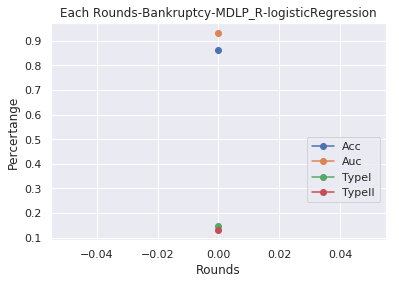

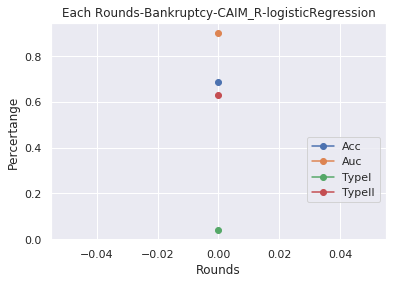

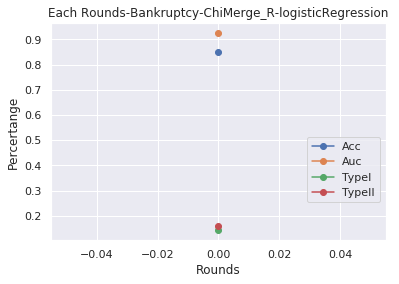

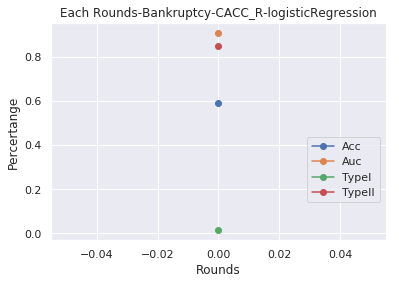

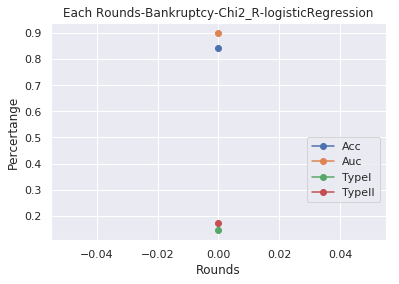

            Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline        0.81 0.87   0.26    0.11         59.64
MDLP_R          0.86 0.93   0.15    0.13        246.89
CAIM_R          0.69 0.90   0.04    0.63       2373.02
ChiMerge_R      0.85 0.93   0.14    0.16       4862.89
CACC_R          0.59 0.91   0.01    0.85       6251.36
Chi2_R          0.84 0.90   0.14    0.17       5122.69
Compare Result-Bankruptcy-KNN


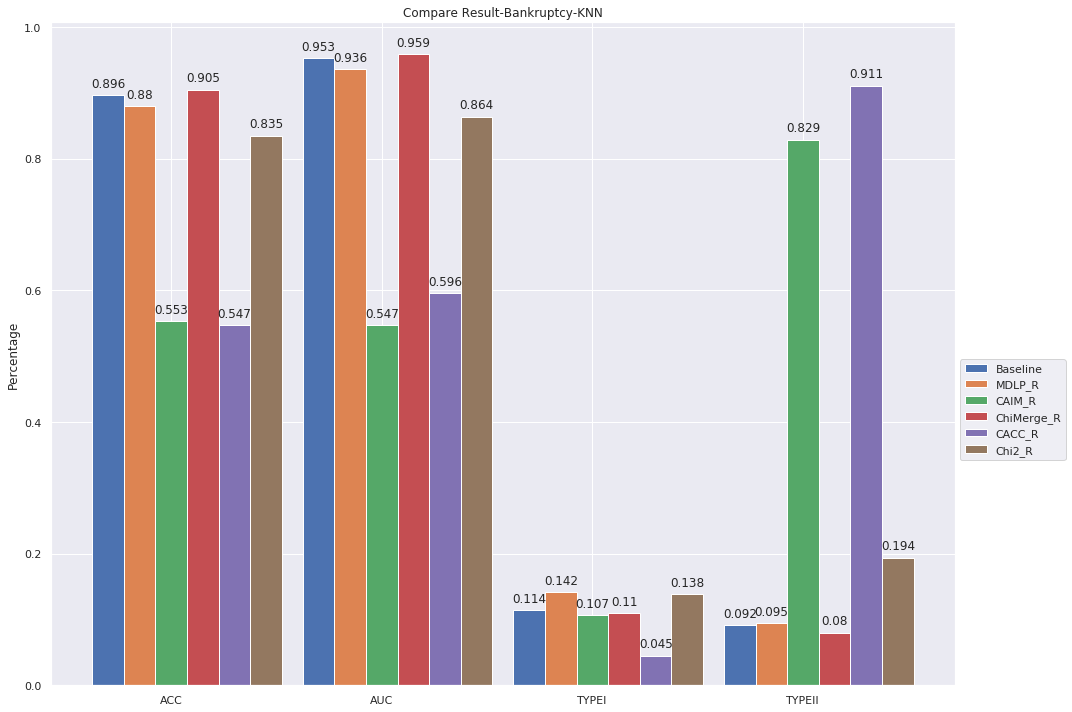

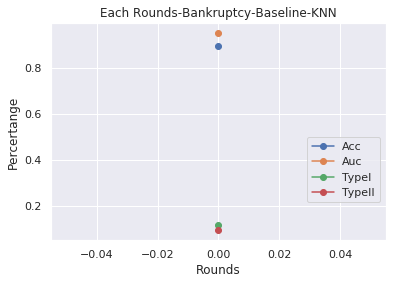

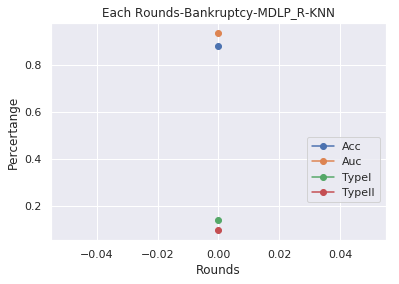

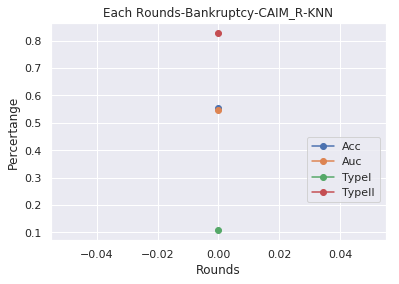

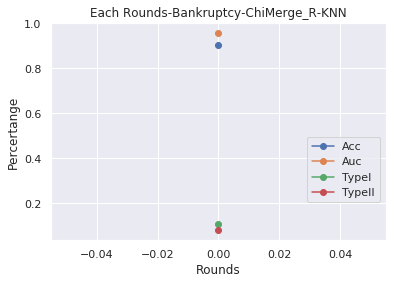

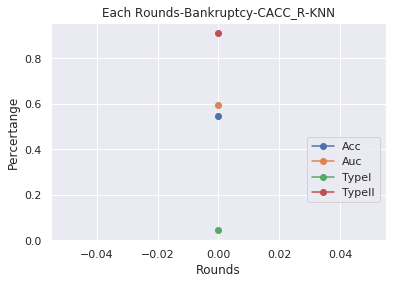

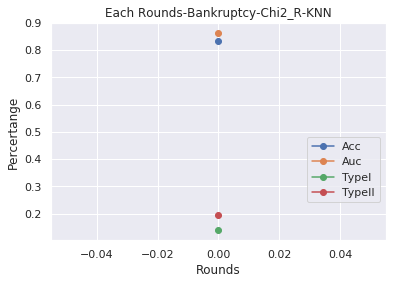

            Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline        0.90 0.95   0.11    0.09         94.70
MDLP_R          0.88 0.94   0.14    0.10        259.83
CAIM_R          0.55 0.55   0.11    0.83       4315.46
ChiMerge_R      0.91 0.96   0.11    0.08       3774.09
CACC_R          0.55 0.60   0.05    0.91       7025.23
Chi2_R          0.83 0.86   0.14    0.19       3462.59


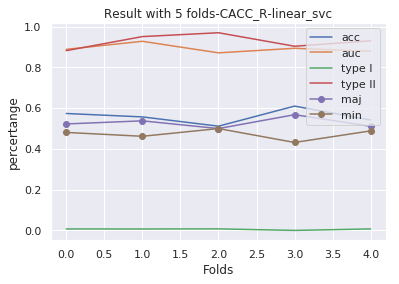

[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base

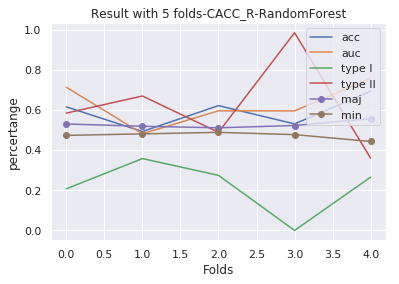

[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font fami

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe


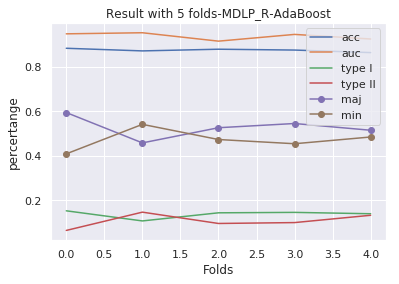

Discretize_X_test_dataframe
[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font fami

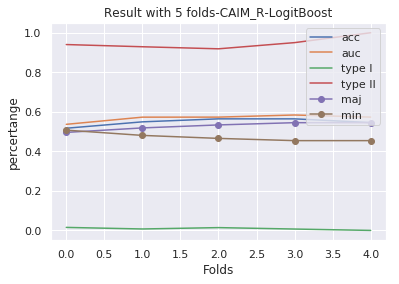

[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
-------------------------------NEXT ROUND-----------------------------
4_NOTALL
5_NOTALL
[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------
6_NOTALL
7_NOTALL
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
8_NOTALL
9_NOTALL
2_NOTALL
3_NOTALL
10_NOTALL
4_NOTALL11_NOTALL

12_NOTALL
13_NOTALL5_NOTALL
6_NOTALL
14_NOTALL

15_NOTALL
X_test_disData_dataframe7_NOTALL

X_test_categorialData_dataframe
8_NOTALLDiscretize_X_test_dataframe
9_NOTALL

10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

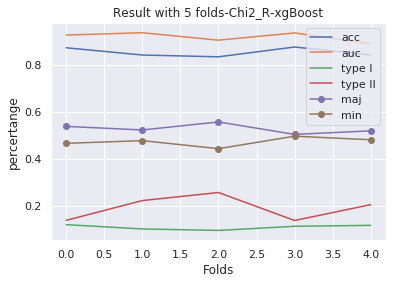

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

9_NOTALL
10_NOTALL
-------------------------------NEXT ROUND-----------------------------
11_NOTALL
12_NOTALL
13_NOTALL
[X_y_train_continuousData_dataframe]
14_NOTALL
-------------------------------Chi2_R -----------------------------
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

Discretize_X_test_dataframe
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_

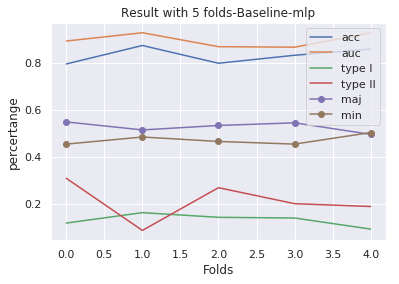

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Mean : [0.83273013 0.89804502 0.1302684  0.21010669]
[X_y_train_continuousData_dataframe]
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_ALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font fami

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
-------------------------------NEXT ROUND-----------------------------5_NOTALL
Compare Result-Bankruptcy-svmrbf

6_NOTALL
7_NOTALL
[X_y_train_continuousData_dataframe]8_NOTALL

9_NOTALL-------------------------------Chi2_R -----------------------------



C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


10_NOTALL
11_NOTALL[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe

0_NOTALL
1_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL2_NOTALL

15_NOTALL
3_NOTALL
X_test_disData_dataframe4_NOTALL

X_test_categorialData_dataframe
5_NOTALL
6_NOTALL
Discretize_X_test_dataframe
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packa

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND------------------------------------------------------------NEXT ROUND-----------------------------

Mean Accuracy: 0.8335048599199542
Mean Accuracy[0.7735849056603774, 0.8484848484848485, 0.8409090909090909, 0.8257575757575758, 0.8787878787878788]
Mean Auc: 0.9017306428787883
Mean Auc[0.8706090328467153, 0.9257921714818267, 0.9068472708488778, 0.8825748781054099, 0.9228298611111111]
Mean TypeII: 0.16791859184408311
Mean TypeII[0.145985401459854, 0.11206896551724138, 0.20300751879699247, 0.211864406779661, 0.16666666666666666]
Mean TypeI: 0.16732103979960303
Mean TypeI[0.3125, 0.18243243243243243, 0.11450381679389313, 0.14383561643835616, 0.08333333333333333]
[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
Mean Accuracy: 0.7690623213264722
Mean Accuracy[0.8377358490566038, 0.875, 0.7121212121212122, 0.8143939393939394, 0.6060606060606061]
Mean Auc: 0.8735684788098791
Mean Auc[0.9107895636322205, 0.8889177189644237, 0.894135303625029, 0.8673227891941815, 0.8066770186335405]
Mean TypeII: 0.40785025139344483
Mean TypeII[0.1984732824427481, 0.18699186991869918, 0.5819672131147541, 0.26229508196721313, 0.8095238095238095]
Mean TypeI: 0.07344199770907421
Mean TypeI[0.12686567164179105, 0.07092198581560284, 0.035211267605633804, 0.11971830985915492, 0.014492753623188406]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

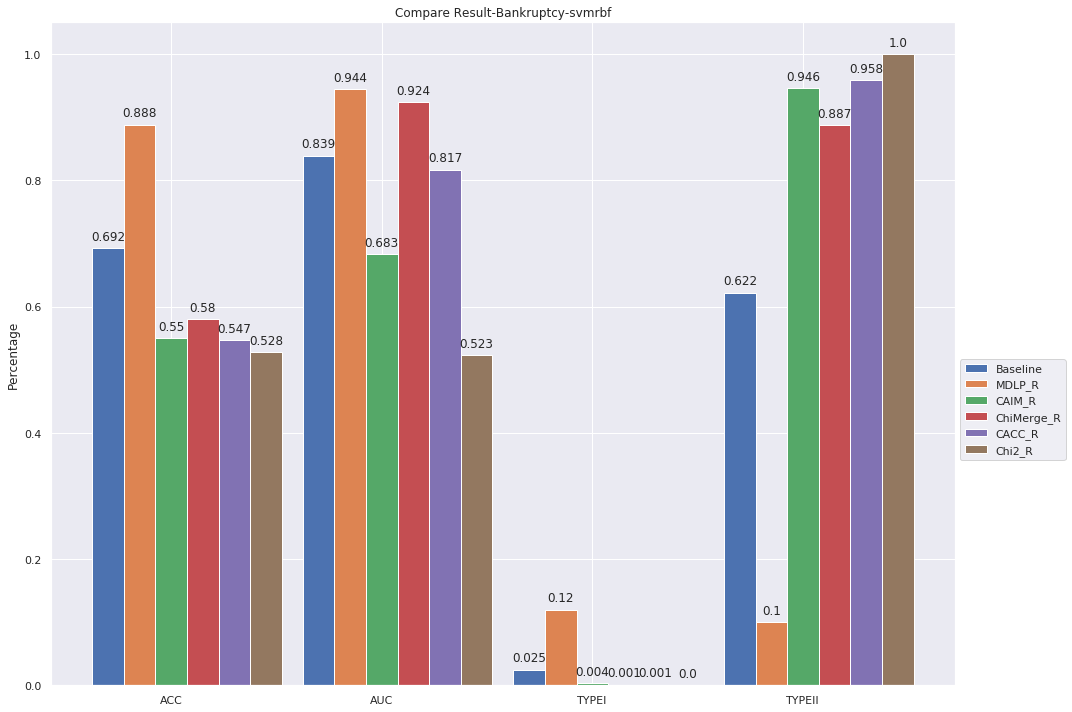

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

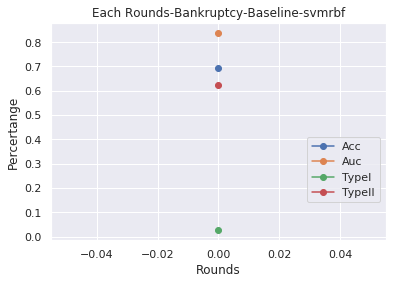

Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


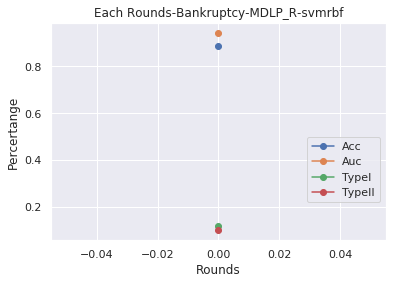

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

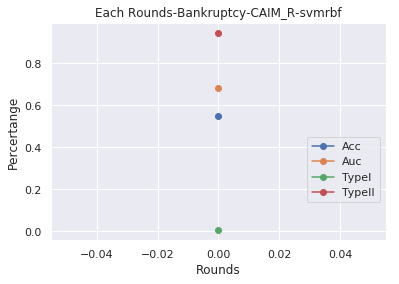

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

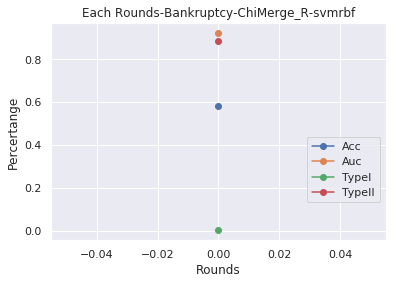

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

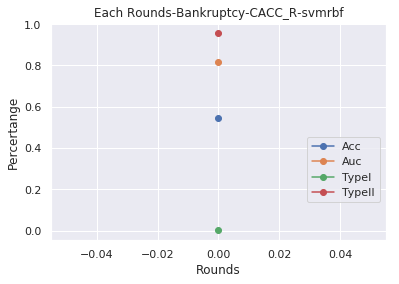

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

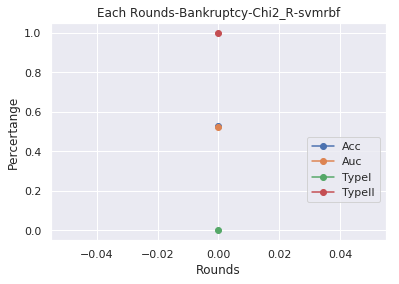

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


            Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline        0.69 0.84   0.03    0.62        123.64
MDLP_R          0.89 0.94   0.12    0.10        279.11
CAIM_R          0.55 0.68   0.00    0.95       5117.19
ChiMerge_R      0.58 0.92   0.00    0.89       4351.26
CACC_R          0.55 0.82   0.00    0.96       7591.95
Chi2_R          0.53 0.52   0.00    1.00       2930.76


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

Compare Result-Bankruptcy-xgBoost


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

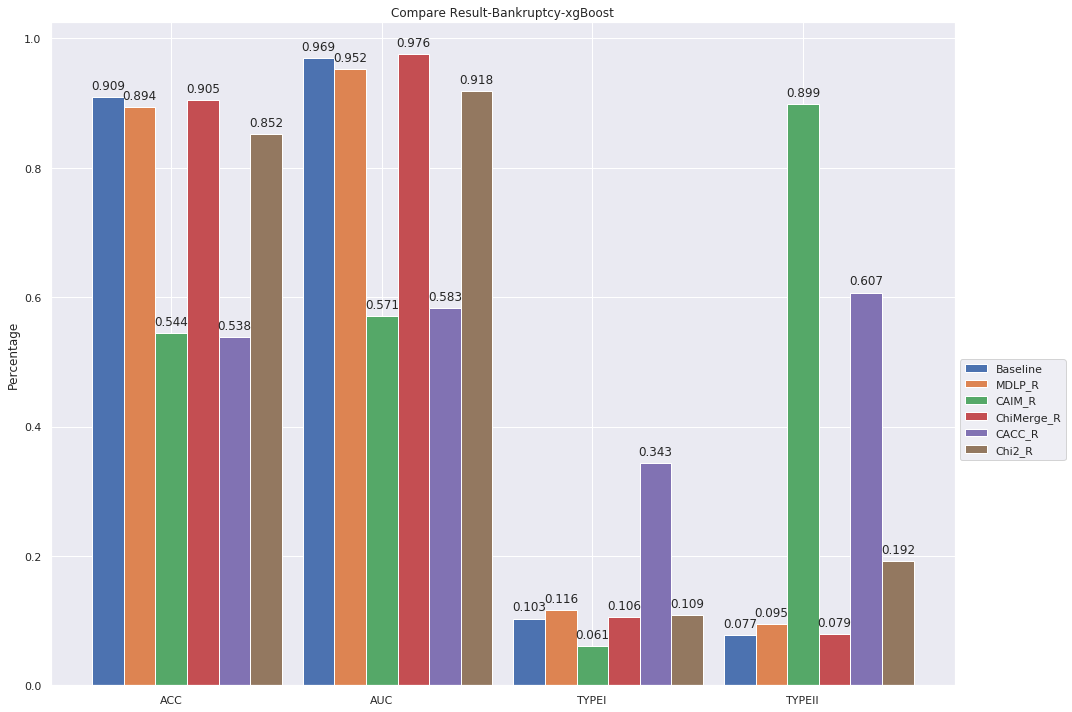

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


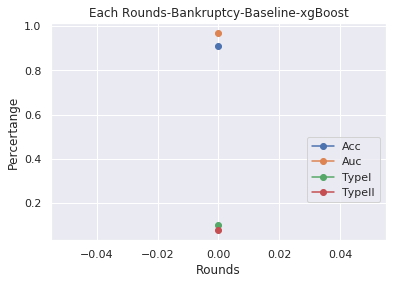

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
Mean Accuracy: 0.8947827329902802
Mean Accuracy[0.8867924528301887, 0.928030303030303, 0.8863636363636364, 0.8560606060606061, 0.9166666666666666]
Mean Auc: 0.9441510361792179
Mean Auc[0.9420929702631878, 0.9637496377861489, 0.9296640498730085, 0.928998161764706, 0.956250361209039]
Mean TypeII: 0.09012349872354049
Mean TypeII[0.12686567164179105, 0.05042016806722689, 0.10655737704918032, 0.1171875, 0.049586776859504134]
Mean TypeI: 0.1179231764882515
Mean TypeI[0.09923664122137404, 0.0896551724137931, 0.11971830985915492, 0.16911764705882354, 0.11188811188811189]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

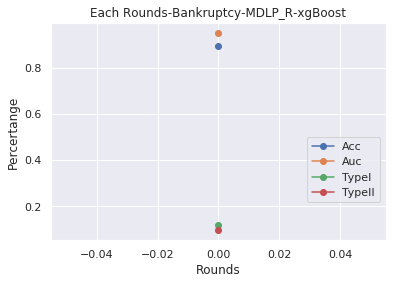

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


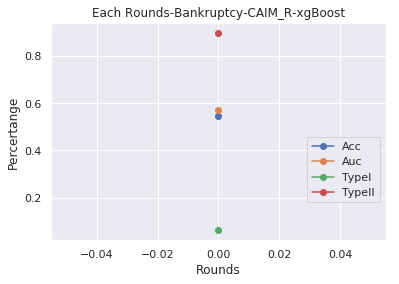

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

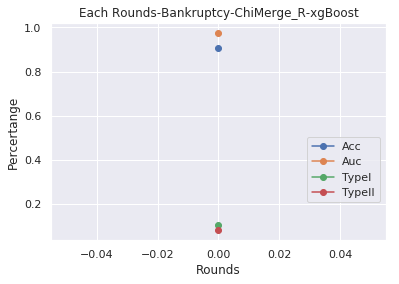

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

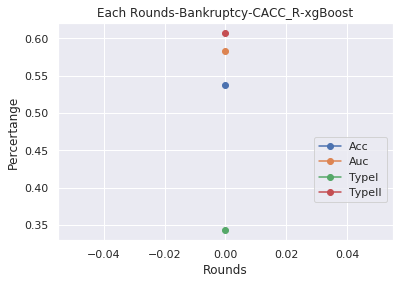

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

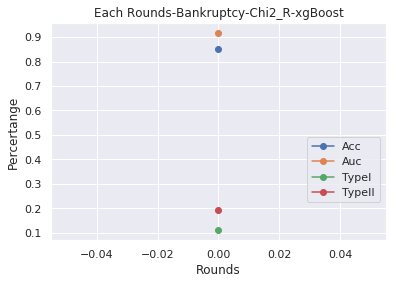

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

            Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline        0.91 0.97   0.10    0.08        159.12
MDLP_R          0.89 0.95   0.12    0.10       1122.38
CAIM_R          0.54 0.57   0.06    0.90       6298.34
ChiMerge_R      0.91 0.98   0.11    0.08       9015.27
CACC_R          0.54 0.58   0.34    0.61       2393.52
Chi2_R          0.85 0.92   0.11    0.19       3095.12


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

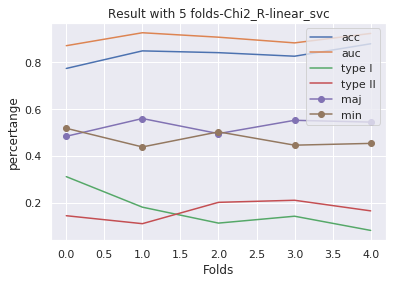

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


-------------------------------NEXT ROUND-----------------------------
Mean Accuracy: 0.5374585477415665
Mean Accuracy[0.5547169811320755, 0.5340909090909091, 0.5378787878787878, 0.5340909090909091, 0.5265151515151515]
Mean Auc: 0.5124544195197245
Mean Auc[0.45264367816091955, 0.5389640287769785, 0.494758064516129, 0.5250574052812859, 0.5508489208633094]
Mean TypeII: 0.8095713813068652
Mean TypeII[0.8083333333333333, 0.776, 0.7096774193548387, 0.7538461538461538, 1.0]
Mean TypeI: 0.15226045059107482
Mean TypeI[0.14482758620689656, 0.18705035971223022, 0.24285714285714285, 0.1865671641791045, 0.0]


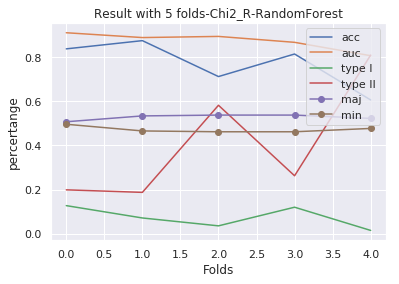

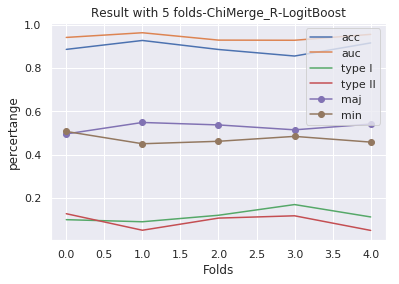

[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

Compare Result-Bankruptcy-linear_svc


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

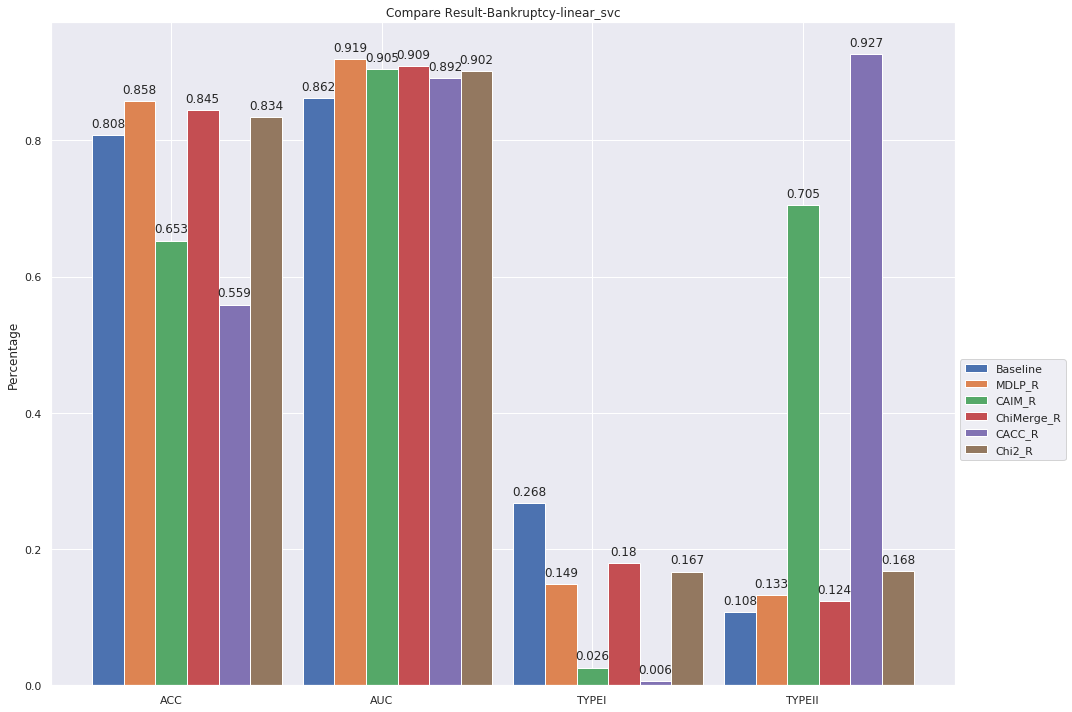

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

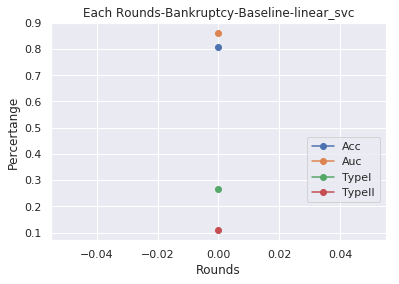

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


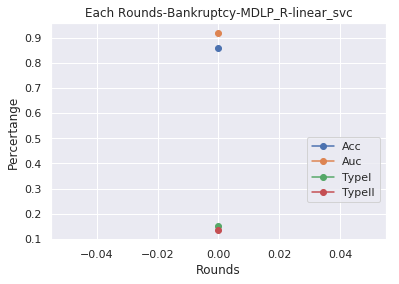

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


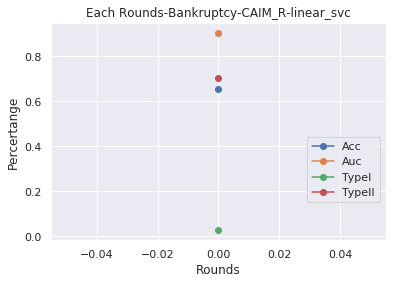

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

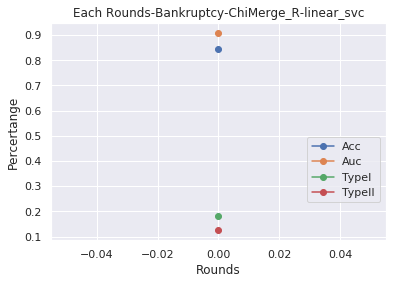

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

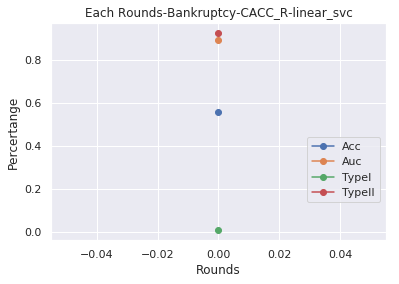

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

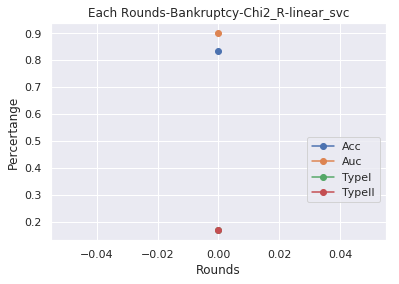

            Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline        0.81 0.86   0.27    0.11        250.41
MDLP_R          0.86 0.92   0.15    0.13       4398.95
CAIM_R          0.65 0.90   0.03    0.71       3809.84
ChiMerge_R      0.84 0.91   0.18    0.12       9858.50
CACC_R          0.56 0.89   0.01    0.93       2087.31
Chi2_R          0.83 0.90   0.17    0.17       4230.70
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

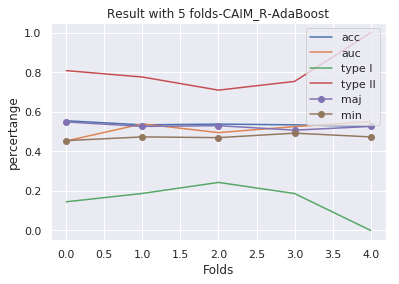

[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

Compare Result-Bankruptcy-RandomForest


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


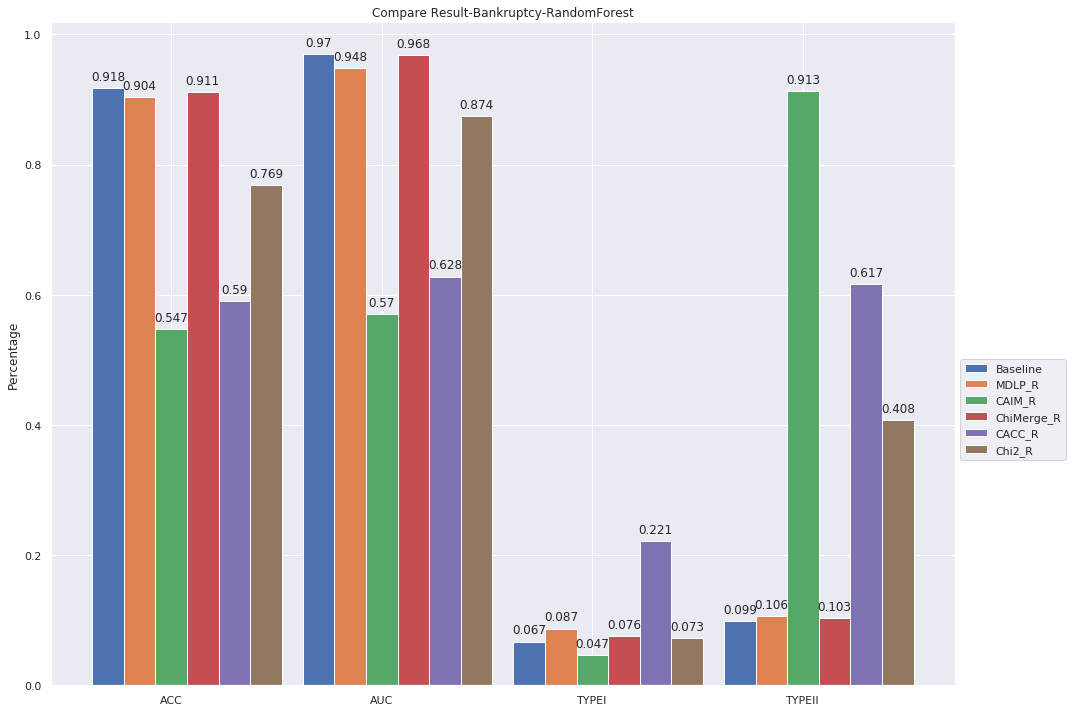

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
Mean Accuracy: 0.5434962835906233
Mean Accuracy[0.5849056603773585, 0.5265151515151515, 0.5492424242424242, 0.5075757575757576, 0.5492424242424242]
Mean Auc: 0.5635622529008211
Mean Auc[0.586935052863948, 0.5301751363766868, 0.4909842223891811, 0.679242032730405, 0.5304748201438849]
Mean TypeII: 0.9501101986820469
Mean TypeII[0.9649122807017544, 0.9689922480620154, 0.9090909090909091, 0.9555555555555556, 0.952]
Mean TypeI: 0.014137800184311813
Mean TypeI[0.0, 0.0, 0.06293706293706294, 0.007751937984496124, 0.0]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

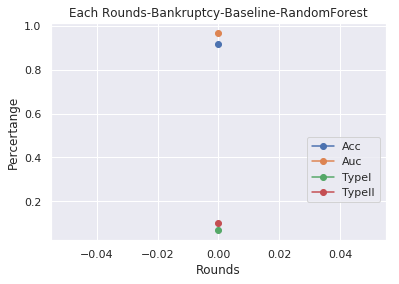

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

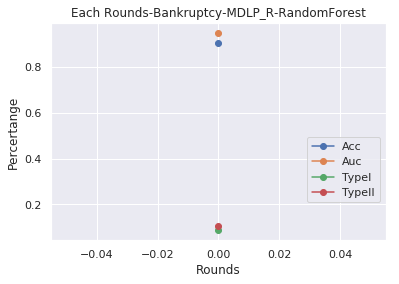

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\An

[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_ALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_ALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

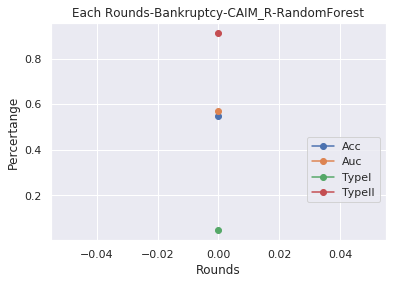

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

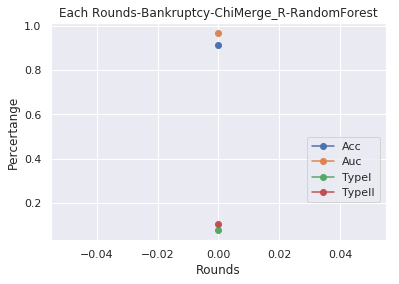

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

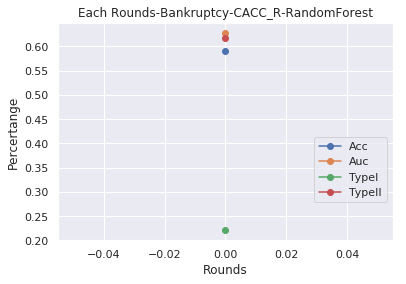

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

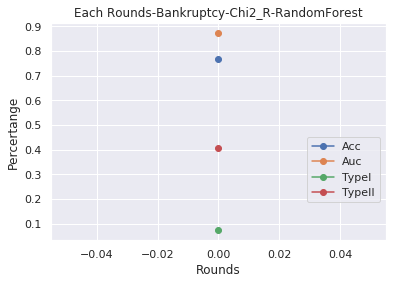

            Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline        0.92 0.97   0.07    0.10        222.49
MDLP_R          0.90 0.95   0.09    0.11       4412.77
CAIM_R          0.55 0.57   0.05    0.91       4676.14
ChiMerge_R      0.91 0.97   0.08    0.10       9583.01
CACC_R          0.59 0.63   0.22    0.62       1789.22
Chi2_R          0.77 0.87   0.07    0.41       3952.96
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

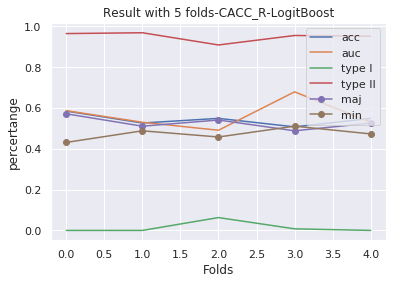

[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
Mean Accuracy: 0.8796340766152086
Mean Accuracy[0.8830188679245283, 0.8674242424242424, 0.875, 0.8977272727272727, 0.875]
Mean Auc: 0.9498856358362024
Mean Auc[0.9557714285714285, 0.9343382141831754, 0.9544749540441175, 0.9500434656621269, 0.9548001167201635]
Mean TypeII: 0.10636847620746984
Mean TypeII[0.12, 0.08527131782945736, 0.15441176470588236, 0.05042016806722689, 0.12173913043478261]
Mean TypeI: 0.13163157135877573
Mean TypeI[0.11428571428571428, 0.17777777777777778, 0.09375, 0.14482758620689656, 0.12751677852348994]


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

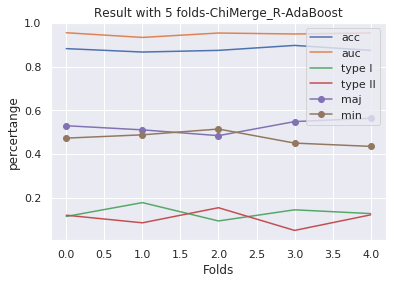

[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
-------------------------------NEXT ROUND-----------------------------
6_NOTALL
7_NOTALL
[X_y_train_continuousData_dataframe]8_NOTALL

-------------------------------Chi2_R -----------------------------9_NOTALL

10_NOTALL
[X_y_train_disData_dataframe]
11_NOTALL[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL

1_NOTALL
12_NOTALL
13_NOTALL2_NOTALL

3_NOTALL
14_NOTALL
4_NOTALL
15_NOTALL
5_NOTALLX_test_disData_dataframe

X_test_categorialData_dataframe
6_NOTALL
Discretize_X_test_dataframe7_NOTALL

8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

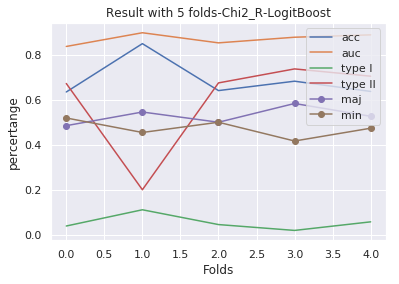

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
Compare Result-Bankruptcy-LogitBoost


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

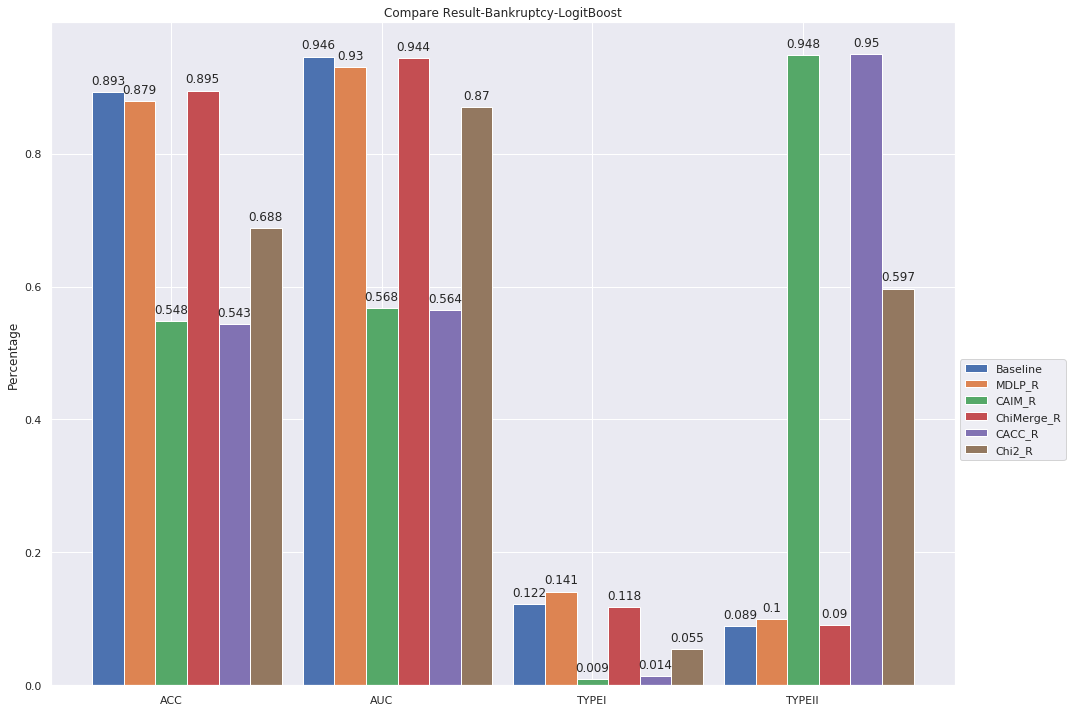

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

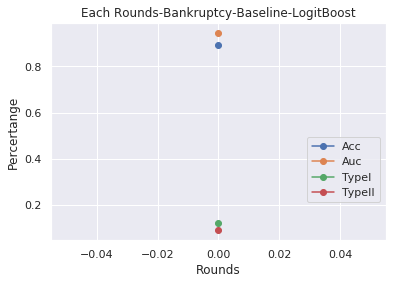

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)



1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL

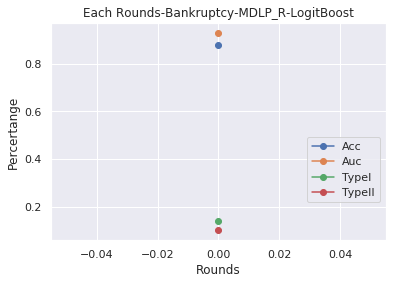


12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

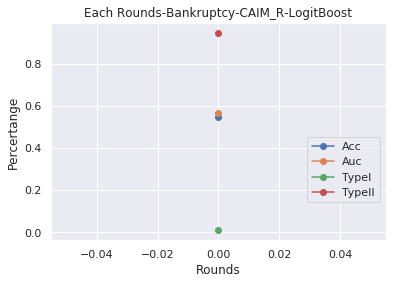

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

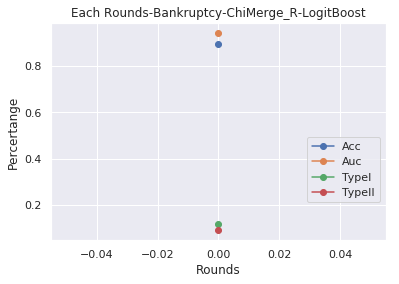

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

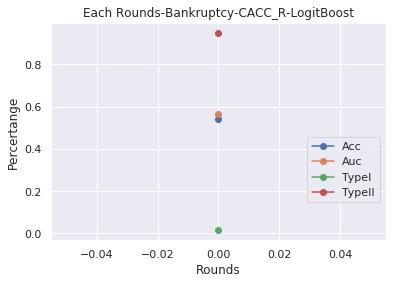

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarnin

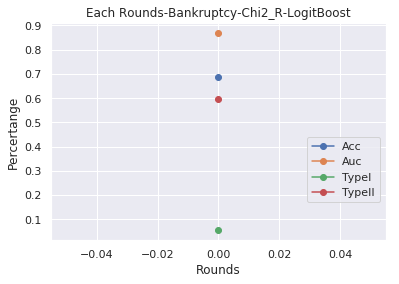

            Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline        0.89 0.95   0.12    0.09       4071.47
MDLP_R          0.88 0.93   0.14    0.10      13088.85
CAIM_R          0.55 0.57   0.01    0.95       4368.92
ChiMerge_R      0.89 0.94   0.12    0.09       3108.23
CACC_R          0.54 0.56   0.01    0.95        884.15
Chi2_R          0.69 0.87   0.05    0.60       1952.69
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
Mean Accuracy: 0.5359662664379645
Mean Accuracy[0.5245283018867924, 0.6287878787878788, 0.5643939393939394, 0.5075757575757576, 0.45454545454545453]
Mean Auc: 0.503357513003308
Mean Auc[0.5774506427915519, 0.5631378654212075, 0.47847577446979717, 0.4324099086154377, 0.4653133737185462]
Mean TypeII: 0.650274460764792
Mean TypeII[0.6198347107438017, 0.5121951219512195, 0.8582677165354331, 0.7007299270072993, 0.5603448275862069]
Mean TypeI: 0.2895379113352175
Mean TypeI[0.3541666666666667, 0.24822695035460993, 0.043795620437956206, 0.2

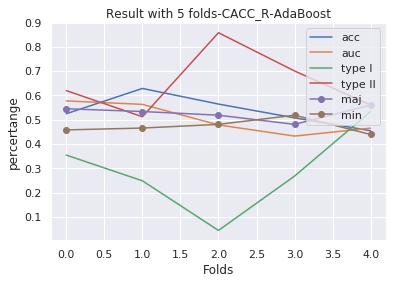

[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_ALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_ALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-

C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
Mean Accuracy: 0.6427044025157232
Mean Accuracy[0.630188679245283, 0.6553030303030303, 0.6477272727272727, 0.7386363636363636, 0.5416666666666666]
Mean Auc: 0.7125126528464747
Mean Auc[0.5810057471264368, 0.737261329652634, 0.8282436162870945, 0.7868055555555555, 0.6292470156106521]
Mean TypeII: 0.7050505050505051
Mean TypeII[0.7666666666666667, 0.7063492063492064, 0.6825396825396826, 0.48333333333333334, 0.8863636363636364]
Mean TypeI: 0.042657724168218926
Mean TypeI[0.041379310344827586, 0.014492753623188406, 0.050724637681159424,

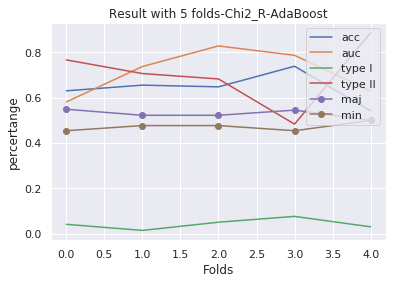

Compare Result-Bankruptcy-AdaBoost


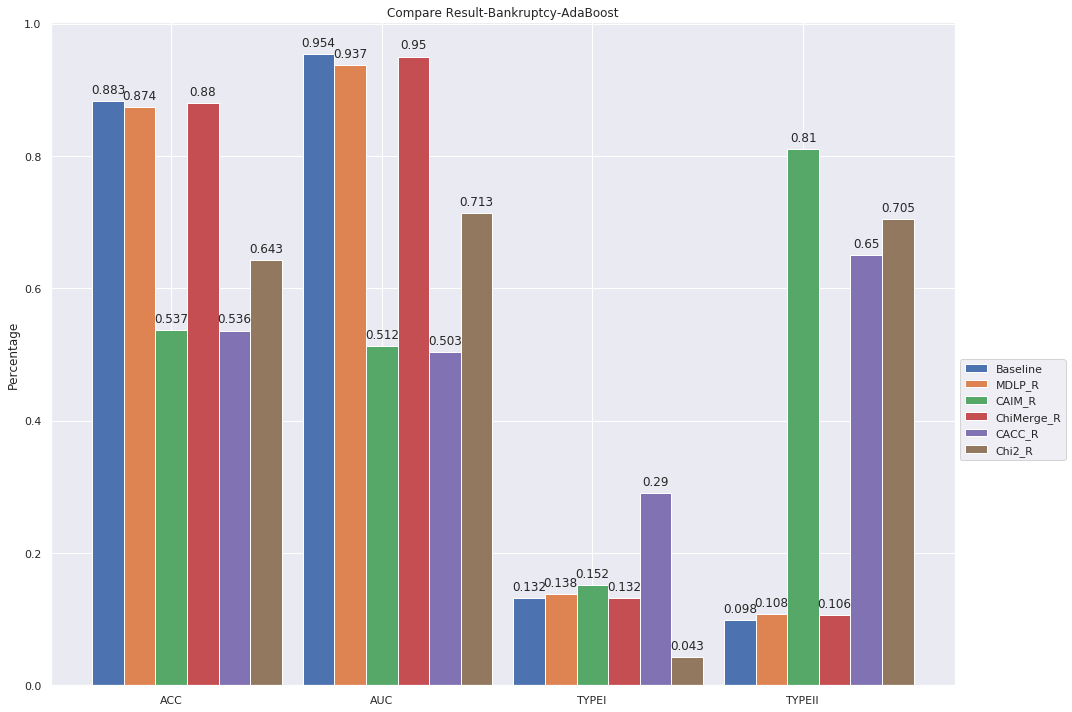

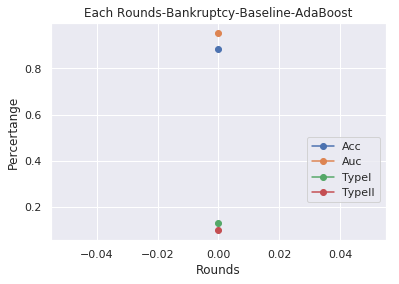

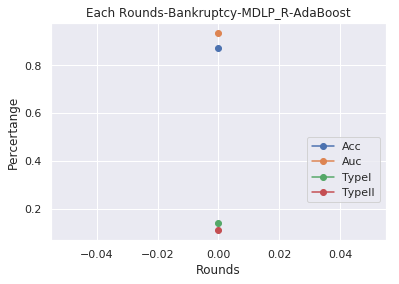

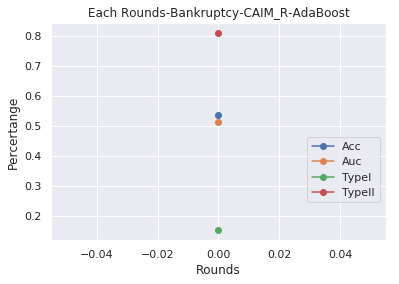

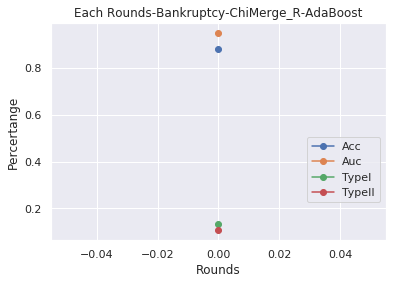

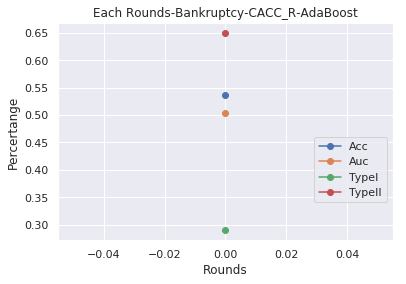

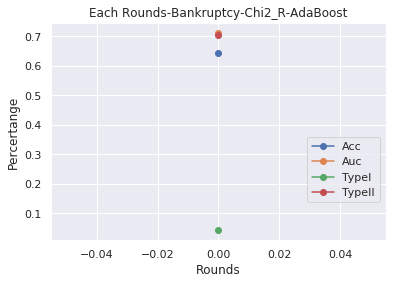

            Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline        0.88 0.95   0.13    0.10       7880.01
MDLP_R          0.87 0.94   0.14    0.11      13361.97
CAIM_R          0.54 0.51   0.15    0.81       3431.55
ChiMerge_R      0.88 0.95   0.13    0.11       2512.66
CACC_R          0.54 0.50   0.29    0.65        323.68
Chi2_R          0.64 0.71   0.04    0.71       1396.72
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_ALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_ALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------MDLP_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_ALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_ALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


-------------------------------NEXT ROUND-----------------------------
Mean Accuracy: 0.8751057747284163
Mean Accuracy[0.8603773584905661, 0.875, 0.8863636363636364, 0.8446969696969697, 0.9090909090909091]
Mean Auc: 0.9406817629181221
Mean Auc[0.9441118913318752, 0.9429692911567767, 0.9469288174512055, 0.919642857142857, 0.9497559575078954]
Mean TypeII: 0.09607280654925884
Mean TypeII[0.08403361344537816, 0.08196721311475409, 0.09230769230769231, 0.12903225806451613, 0.09302325581395349]
Mean TypeI: 0.14973840270090064
Mean TypeI[0.18493150684931506, 0.1619718309859155, 0.13432835820895522, 0.17857142857142858, 0.08888888888888889]


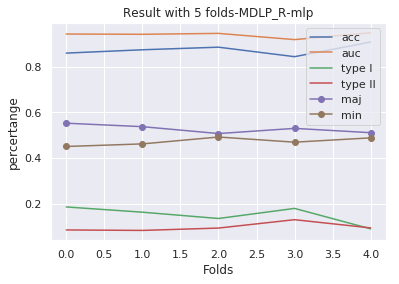

[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CAIM_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


-------------------------------NEXT ROUND-----------------------------
Mean Accuracy: 0.703893653516295
Mean Accuracy[0.8603773584905661, 0.7045454545454546, 0.7083333333333334, 0.6401515151515151, 0.6060606060606061]
Mean Auc: 0.9005622554563437
Mean Auc[0.9231729987219705, 0.9168532873959231, 0.9072064312374389, 0.8549861973775017, 0.9005923625488843]
Mean TypeII: 0.5592255833381904
Mean TypeII[0.14035087719298245, 0.5813953488372093, 0.5426356589147286, 0.7063492063492064, 0.8253968253968254]
Mean TypeI: 0.051325036525151704
Mean TypeI[0.1390728476821192, 0.022222222222222223, 0.05185185185185185, 0.043478260869565216, 0.0]


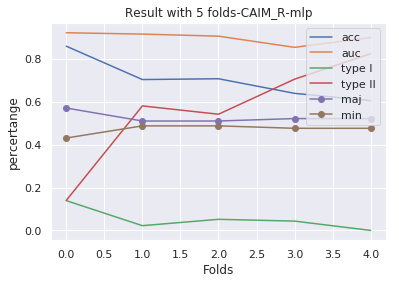

[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------
[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------ChiMerge_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
Mean Accuracy: 0.8720583190394511
Mean Accuracy[0.8830188679245283, 0.8409090909090909, 0.8598484848484849, 0.8712121212121212, 0.9053030303030303]
Mean Auc: 0.9428145653905649
Mean Auc[0.9411731142302864, 0.9293778801843318, 0.9338886300093197, 0.9412878787878789, 0.9683453237410071]
Mean TypeII: 0.14008171236154385
Mean TypeII[0.12598425196850394, 0.18548387096774194, 0.23275862068965517, 0.06818181818181818, 0.088]
Mean TypeI: 0.1204181738620275
Mean TypeI[0.10869565217391304, 0.1357142857142857, 0.06756756756756757, 0.1893939393

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


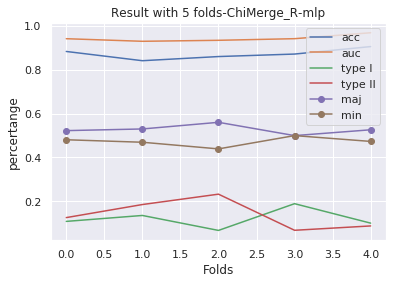

[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------CACC_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


-------------------------------NEXT ROUND-----------------------------
Mean Accuracy: 0.6745340194396798
Mean Accuracy[0.6150943396226415, 0.678030303030303, 0.6742424242424242, 0.7310606060606061, 0.6742424242424242]
Mean Auc: 0.9220855771238107
Mean Auc[0.9189489900718932, 0.9202952665441175, 0.9450272519486609, 0.9376688315420427, 0.8884875455123389]
Mean TypeII: 0.6710956725044136
Mean TypeII[0.8031496062992126, 0.6029411764705882, 0.7610619469026548, 0.5354330708661418, 0.6528925619834711]
Mean TypeI: 0.01885727183400541
Mean TypeI[0.0, 0.0234375, 0.0, 0.021897810218978103, 0.04895104895104895]


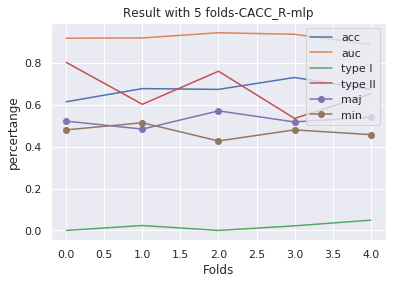

[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
[X_y_train_continuousData_dataframe]
-------------------------------Chi2_R -----------------------------


C:\Users\Lab-722\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[X_y_train_disData_dataframe]
[X_train_disData_dataframe]
[X_train_categorialData_dataframe]
[Discretize_X_train_dataframe]
X_test_continuousData_dataframe
0_NOTALL
1_NOTALL
2_NOTALL
3_NOTALL
4_NOTALL
5_NOTALL
6_NOTALL
7_NOTALL
8_NOTALL
9_NOTALL
10_NOTALL
11_NOTALL
12_NOTALL
13_NOTALL
14_NOTALL
15_NOTALL
X_test_disData_dataframe
X_test_categorialData_dataframe
Discretize_X_test_dataframe
-------------------------------NEXT ROUND-----------------------------
Mean Accuracy: 0.8039479702687249
Mean Accuracy[0.7886792452830189, 0.7613636363636364, 0.8446969696969697, 0.7462121212121212, 0.8787878787878788]
Mean Auc: 0.8599926968687093
Mean Auc[0.8471747550694919, 0.8075200918484501, 0.9024497450624157, 0.8421339608563393, 0.9006849315068494]
Mean TypeII: 0.2860490004112403
Mean TypeII[0.29545454545454547, 0.3076923076923077, 0.2920353982300885, 0.37404580152671757, 0.16101694915254236]
Mean TypeI: 0.11536418282447206
Mean TypeI[0.12781954887218044, 0.17164179104477612, 0.052980132450331126

C:\Users\Lab-722\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Droid Sans Fallback'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


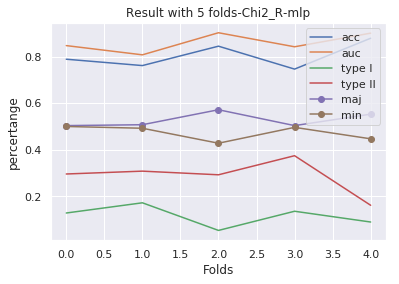

Compare Result-Bankruptcy-mlp


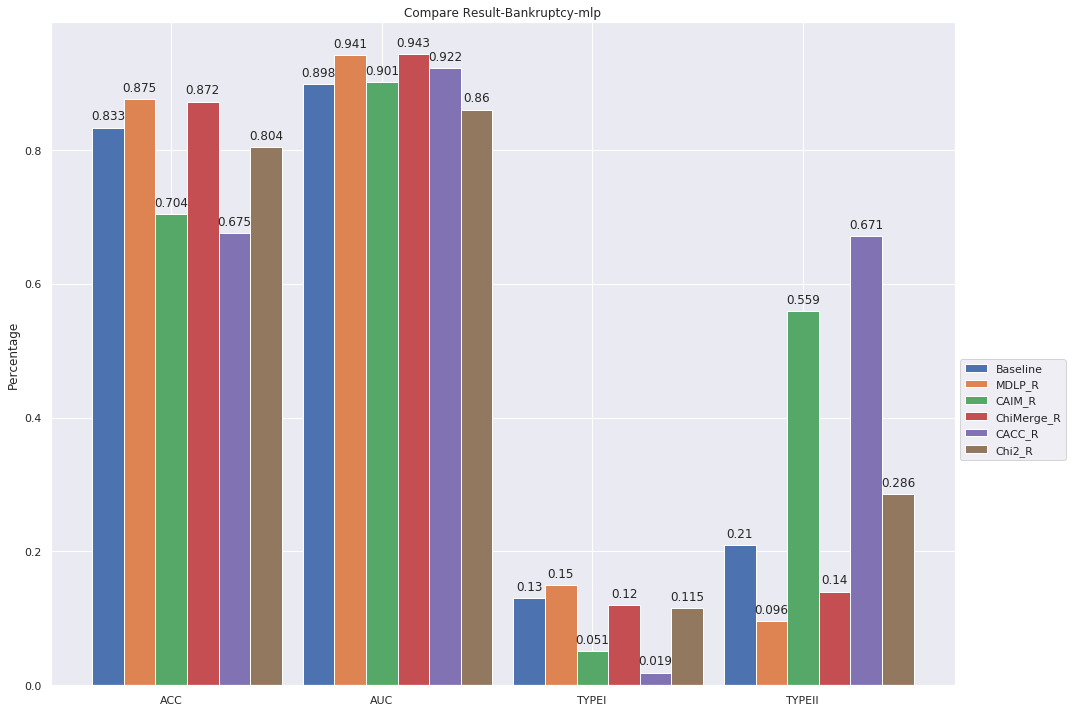

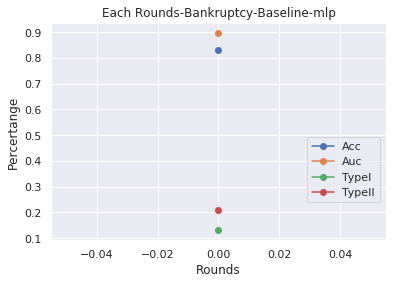

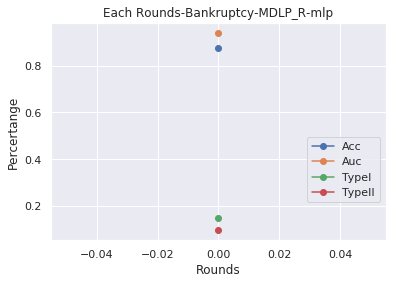

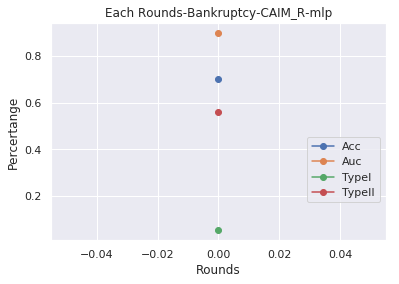

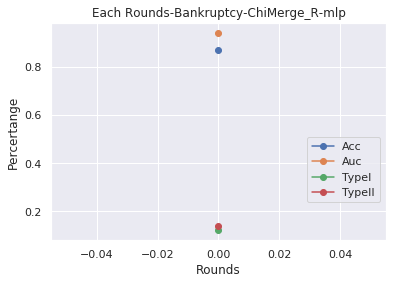

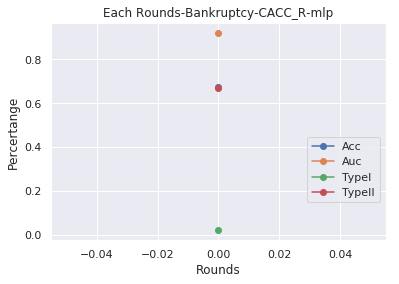

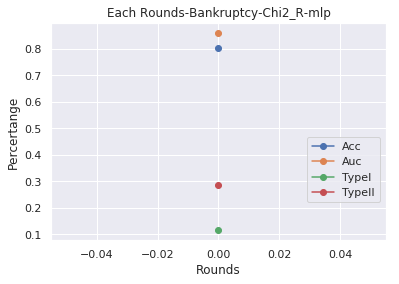

            Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline        0.83 0.90   0.13    0.21      22642.92
MDLP_R          0.88 0.94   0.15    0.10       6285.10
CAIM_R          0.70 0.90   0.05    0.56         35.08
ChiMerge_R      0.87 0.94   0.12    0.14       1380.35
CACC_R          0.67 0.92   0.02    0.67         38.66
Chi2_R          0.80 0.86   0.12    0.29       1403.38

程式結束
Wall time: 8h 49min 50s


In [11]:
%%time

# Classifcation Method
linear_svc = CalibratedClassifierCV(LinearSVC(max_iter=7000))
svmlinear = SVC(kernel='linear', probability=True)
svmrbf = SVC(kernel='rbf', probability=True)
DecisionTreeClassifier = tree.DecisionTreeClassifier()
RandomForest = RandomForestClassifier()
logisticRegression = LogisticRegression()
mlp = MLPClassifier()
xgBoost = xgb.XGBClassifier()
GaussianNaiveBayes = GaussianNB()
MultinomialNaiveBayes = MultinomialNB()
ComplementNaiveBayes = ComplementNB()
lboost = LogitBoost()
ada = AdaBoostClassifier()
knn = KNeighborsClassifier()

##########################################
#svmpoly = SVC(kernel='poly', probability=True)
#neigh = KNeighborsRegressor(n_neighbors=5)
#linearRegression= LinearRegression()

#DecisionTreeClassifier,logisticRegression,mlp,xgBoost
# classifier_list = [svmrbf,DecisionTreeClassifier,RandomForest,logisticRegression,mlp,xgBoost ]
# classifier_name_list = ['svmrbf','DecisionTreeClassifier','RandomForest','LogisticRegression','MLPClassifier','xgBoost' ]
def run10times(classifier_list,classifier_name_list):

    classifier_list = [classifier_list]
    classifier_name_list = [classifier_name_list]
    classifier_result_list = []
    
    for idx,classifi in enumerate(classifier_list):
        result_list = []
        rounds = 2
        clf_name = classifier_name_list[idx]
        for i in range(1,rounds):

            result_list.clear()
            result_10times_baseline = []
            result_10times_MDLP = []
            result_10times_CAIM = []
            result_10times_ChiMerge_SC = []
            result_10times_ChiMerge_RG = []
            result_10times_CACC = []
            result_10times_Chi2 = []
            runnung_time_list = []
            #Method Select

            clf = classifi
            fold = 5

            start_time = time.time()
            result_eachtimes_baseline = KFoldFuntion(clf, clf_name, 'Baseline', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_baseline.append(result_eachtimes_baseline)
            print("Mean : {0}".format(np.mean(result_10times_baseline, axis=0)))
            runnung_time_list.append(time.time() - start_time)

            start_time = time.time()
            result_eachtimes_MDLP = KFoldFuntion(clf, clf_name, 'MDLP_R', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_MDLP.append(result_eachtimes_MDLP)
            runnung_time_list.append(time.time() - start_time)

            start_time = time.time()
            result_eachtimes_CAIM = KFoldFuntion(clf, clf_name, 'CAIM_R', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_CAIM.append(result_eachtimes_CAIM)
            runnung_time_list.append(time.time() - start_time)

            start_time = time.time()
            result_eachtimes_ChiMerge_SC = KFoldFuntion(clf, clf_name, 'ChiMerge_R', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_ChiMerge_SC.append(result_eachtimes_ChiMerge_SC)
            runnung_time_list.append(time.time() - start_time)
            
            start_time = time.time()
            result_eachtimes_CACC = KFoldFuntion(clf, clf_name, 'CACC_R', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_CACC.append(result_eachtimes_CACC)
            runnung_time_list.append(time.time() - start_time)
            
            start_time = time.time()
            result_eachtimes_Chi2 = KFoldFuntion(clf, clf_name, 'Chi2_R', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_Chi2.append(result_eachtimes_Chi2)
            runnung_time_list.append(time.time() - start_time)
    
        
        # Thread Lock
        lock.acquire()
        
        
        # Compare Chart (Same Classifier)
        CompareMethodMeanResult(data_name, clf_name, rounds,result_10times_baseline,result_10times_MDLP,result_10times_CAIM,result_10times_ChiMerge_SC,result_10times_CACC,result_10times_Chi2)


        # Compare Chart (Same Classifier)
        ResultEachMethodLineChart(result_10times_baseline,"Baseline",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_MDLP,"MDLP_R",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_CAIM,"CAIM_R",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_ChiMerge_SC,"ChiMerge_R",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_CACC,"CACC_R",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_Chi2,"Chi2_R",data_name,clf_name)

        result_list.append(np.mean(result_10times_baseline, axis=0))
        result_list.append(np.mean(result_10times_MDLP, axis=0))
        result_list.append(np.mean(result_10times_CAIM, axis=0))
        result_list.append(np.mean(result_10times_ChiMerge_SC, axis=0))
        result_list.append(np.mean(result_10times_CACC, axis=0))
        result_list.append(np.mean(result_10times_Chi2, axis=0))

        # Single Classify Method 
        result_with_method = pd.DataFrame(result_list, index=['Baseline','MDLP_R','CAIM_R','ChiMerge_R','CACC_R','Chi2_R'], columns=['Accuracy','AUC','TypeI','TypeII'])
        result_with_method['Time(Second)'] = runnung_time_list
        print(result_with_method)

        file_time = time.strftime("%Y-%m-%d-%H%M%S", time.localtime()) 
        file_name = "Classifier_result_list_{fold}Fold_{data_name}_{method}_{file_timeA}.xlsx".format(fold = fold, file_timeA = file_time,data_name=data_name,method=clf_name)
        pd.DataFrame(result_with_method).to_excel("resultsexcel/"+file_name)
        
        
        # Thread Unlock
        lock.release()
    


t0 = Thread(target=run10times,args=(svmlinear,"svmlinear"))
t1 = Thread(target=run10times,args=(linear_svc,"linear_svc"))
t2 = Thread(target=run10times,args=(svmrbf,"svmrbf"))
t3 = Thread(target=run10times,args=(DecisionTreeClassifier,"DecisionTreeClassifier"))
t4 = Thread(target=run10times,args=(RandomForest,"RandomForest"))
t5 = Thread(target=run10times,args=(logisticRegression,"logisticRegression"))
t6 = Thread(target=run10times,args=(mlp,"mlp"))
t7 = Thread(target=run10times,args=(xgBoost,"xgBoost"))
t8 = Thread(target=run10times,args=(GaussianNaiveBayes,"GaussianNaiveBayes"))
t9 = Thread(target=run10times,args=(lboost,"LogitBoost"))
t10 = Thread(target=run10times,args=(ada,"AdaBoost"))
t11 = Thread(target=run10times,args=(knn,"KNN"))


#thread_list = [t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t0]
#thread_list = [t7]
thread_list = [t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11]
#thread_list = [t11,t10,t9,t7,t8]

#程式開始
for item in thread_list:
    item.start()
print("\n程式開始")


#程式結束
for item in thread_list:
    item.join()
print("\n程式結束")
    


#############################################################################YEE

## Record Result

## Compare result

print("Mean : {0}".format(np.mean(result_10times_baseline, axis=0))) 

print("Mean : {0}".format(np.mean(result_10times_MDLP, axis=0))) 

print("Mean : {0}".format(np.mean(result_10times_CAIM, axis=0)))

print("Mean : {0}".format(np.mean(result_10times_ChiMerge_SC, axis=0)))

In [12]:

#ResultEachMethodLineChart(result_10times_ChiMerge_RG,"ChiMerge_RG",data_name,clf_name)